In [1]:
import os
import sys 
import numpy as np
import matplotlib.pyplot as plt
import sys 
import mdtraj
from nglview import show_ase, show_file, show_mdtraj
import torch

import matplotlib
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rc('lines', linewidth=3, color='g')
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams["xtick.major.size"] = 6
matplotlib.rcParams["ytick.major.size"] = 6
matplotlib.rcParams["ytick.major.width"] = 2
matplotlib.rcParams["xtick.major.width"] = 2
matplotlib.rcParams['text.usetex'] = False

_ColormakerRegistry()

In [2]:
def plot(vacf_sim, vacf_target, g_sim, rdf_target, dt=0.01):

    t_range = np.array([0] + vacf_obs.t_window) 

    plt.plot(t_range, vacf_sim.detach().cpu().numpy(), label='simulation', linewidth=4, alpha=0.6, )
    plt.plot(t_range, vacf_target.detach().cpu().numpy(), label='target', linewidth=2,linestyle='--', c='black' )

    plt.legend()
    plt.show()

    bins = np.linspace(0.5, 2.5, obs.nbins)

    plt.plot(bins, g_sim.detach().cpu().numpy() , label='simulation', linewidth=4, alpha=0.6)
    plt.plot(bins, rdf_target.detach().cpu().numpy() , label='target', linewidth=2,linestyle='--', c='black')
    
    plt.xlabel("$\AA$")
    plt.ylabel("g(r)")

    plt.show()
    
from scipy import interpolate

def get_exp_rdf(data, nbins, r_range, obs):
    # load RDF data 
    f = interpolate.interp1d(data[0], data[1])
    start = r_range[0]
    end = r_range[1]
    xnew = np.linspace(start, end, nbins)
    g_obs = torch.Tensor(f(xnew)).to(obs.device)
    
    return g_obs

def JS_rdf(g_obs, g):
    e0 = 1e-4
    g_m = 0.5 * (g_obs + g)
    loss_js =  ( -(g_obs + e0 ) * (torch.log(g_m + e0 ) - torch.log(g_obs +  e0)) ).mean()
    loss_js += ( -(g + e0 ) * (torch.log(g_m + e0 ) - torch.log(g + e0) ) ).mean()

    return loss_js

## Set up systems

In [3]:
from ase.lattice.cubic import FaceCenteredCubic
from ase import units

from torchmd.interface import GNNPotentials,PairPotentials, Stack
from torchmd.system import System
from torchmd.potentials import ExcludedVolume, LennardJones
from nff.train import get_model

size = 4
L = 1.679
device = 0

atoms = FaceCenteredCubic(directions=[[1, 0, 0], 
                                    [0, 1, 0], 
                                    [0, 0, 1]],
                          symbol='H',
                          size=(size, size, size),
                          latticeconstant=L,
                          pbc=True)

from torchmd.system import System
system = System(atoms, device=device)
system.set_temperature(1.0 /units.kB)

In [4]:
from nff.nn.layers import GaussianSmearing
from torch import nn

nlr = nn.Tanh()

class MLP(nn.Module):
    def __init__(self, n_gauss, r_start, r_end):
        super(MLP, self).__init__()
        
        self.smear = GaussianSmearing(
            start=r_start,
            stop=r_end,
            n_gaussians=n_gauss,
            trainable=False
        )
        
        self.layers = nn.Sequential(
            nn.Linear(n_gauss, n_gauss),
            nlr,
            nn.Linear(n_gauss, 64),
            nlr,
            nn.Linear(64, 64),
            nlr,
            nn.Linear(64, 64),
            nlr,
            nn.Linear(64, 32),
            nlr,
            nn.Linear(32, 1)
        )
        
    def forward(self, r):
        r = self.smear(r)
        r = self.layers(r)
        return r

In [6]:
mlp_parmas = {'n_gauss': 32, 
              'r_start': 0.0,
              'r_end': 2.5}

In [7]:
pairNN = PairPotentials(system, MLP, mlp_parmas,
                cutoff=2.5,
                ).to(device)

## Set up equations of motions

In [8]:
cutoff = 2.5

# parameter for SchNet 
params = {
    'n_atom_basis': 64,
    'n_filters': 64,
    'n_gaussians': 64,
    'n_convolutions': 2,
    'cutoff': cutoff,
    'trainable_gauss': False
}


# Define prior potential 
lj_params = {'epsilon': 1.0, 
             'sigma': 1.0,
            "power": 12}

from torchmd.potentials import ExcludedVolume
from nff.train import get_model



pair = PairPotentials(system, ExcludedVolume, lj_params,
                cutoff=2.5,
                ).to(device)

model = get_model(params)
GNN = GNNPotentials(system, model,  cutoff=cutoff)


model = Stack({
                'gnn': pairNN, 
                'pair': pair
})


from torchmd.md import NoseHooverChain 
diffeq =NoseHooverChain(model, 
            system,
            Q=50.0, 
            T=1.0,
            num_chains=5, 
            adjoint=False).to(device)

The input temperature is 11604.522060401008 K, it seems too high.


In [29]:
pair_true = LennardJones(1.0, 1.0).to(device)

## Set up observation function

In [9]:
from torchmd.observable import rdf, vacf

# Set up observable 
obs = rdf(system, nbins=100, r_range=(0.75, 2.5))
vacf_obs = vacf(system, t_range=30) 

In [10]:
# Get Target observable 

In [11]:
nbins = 100

vacf_target = np.loadtxt('../data/LJ_data/vacf_rho0.884_T1.0_dt0.01.csv', delimiter=',')
rdf_target = np.loadtxt('../data/LJ_data/rdf_rho0.884_T1.0_dt0.01.csv', delimiter=',')
rdf_target = get_exp_rdf(rdf_target, nbins, (0.75, 2.5), obs)

vacf_target = torch.Tensor(vacf_target).to(device)
rdf_target = rdf_target#.to(device)

In [14]:
from torchmd.md import Simulations

optimizer = torch.optim.Adam(list(pairNN.parameters()), lr=1e-2)


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                              'min', 
                                              min_lr=1e-8, 
                                              verbose=True, factor = 0.5, patience= 20,
                                              threshold=5e-5)

# Set up simulations 
sim = Simulations(system, diffeq)

## Simulate

0.04691873863339424 0.2201440930366516


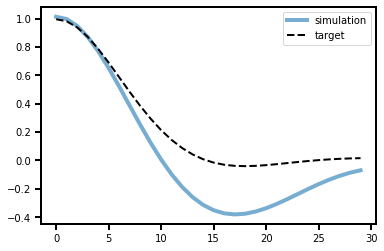

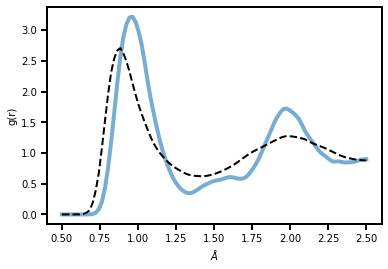

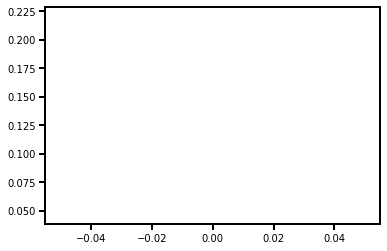

0.020899178460240364 0.13603219389915466
0.020345546305179596 0.06611721217632294
0.029933523386716843 0.048893291503190994
0.024954551830887794 0.04320726916193962
0.031055770814418793 0.05390144884586334


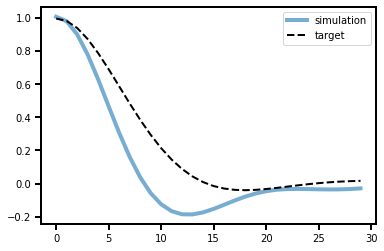

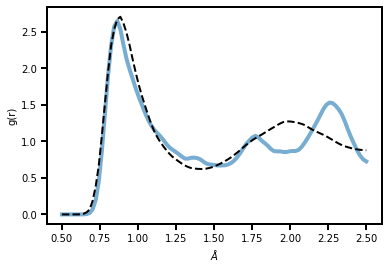

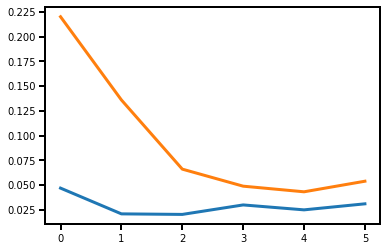

0.042421892285346985 0.08535542339086533
0.03505069017410278 0.09084830433130264
0.007964203134179115 0.05732404440641403
0.005941984709352255 0.018872510641813278
0.011950855143368244 0.025136347860097885


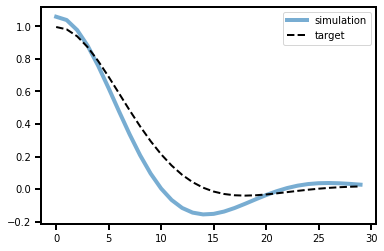

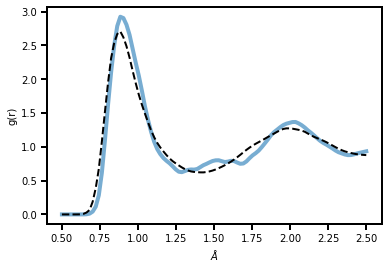

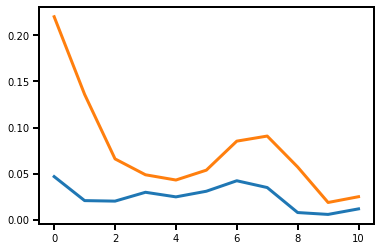

0.030461149290204048 0.04517984017729759
0.037648189812898636 0.08291337639093399
0.05023714154958725 0.09645947813987732
0.05782472714781761 0.10650210827589035
0.05567741394042969 0.10699354857206345


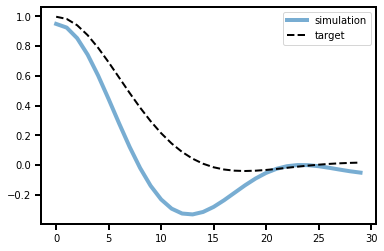

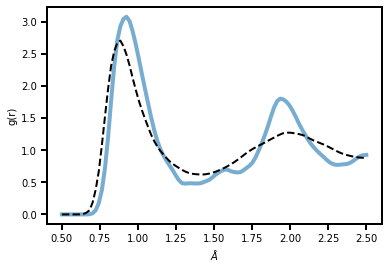

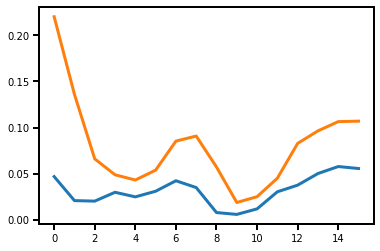

0.048029784113168716 0.09616006910800934
0.037775956094264984 0.08300681412220001
0.02539028786122799 0.06323837488889694
0.02455543726682663 0.045592039823532104
0.010728269815444946 0.0272245891392231


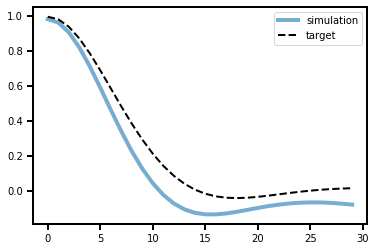

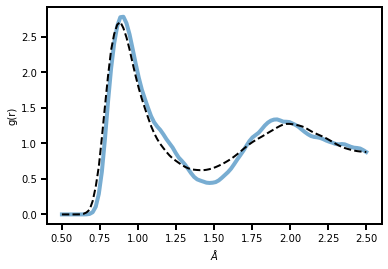

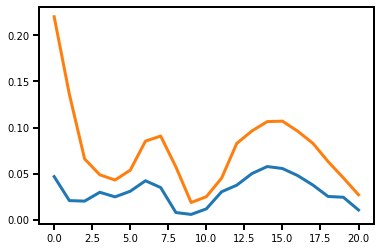

0.011441141366958618 0.014744495041668415
0.01006498746573925 0.017395298928022385
0.01619652658700943 0.02686307579278946
0.010120805352926254 0.026898236945271492
0.013827277347445488 0.019820868968963623


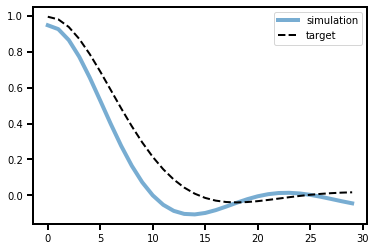

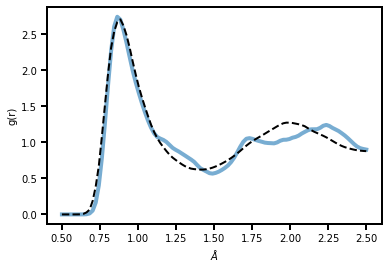

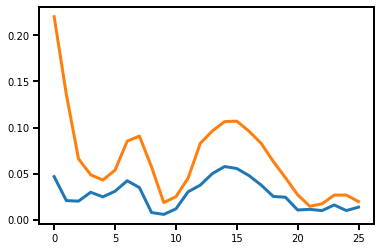

0.012075933627784252 0.013507228344678879
0.013545598834753036 0.022876443341374397
0.009600061923265457 0.047591861337423325
0.010171097703278065 0.05033526197075844
0.011695181019604206 0.04927591606974602
Epoch    31: reducing learning rate of group 0 to 5.0000e-03.


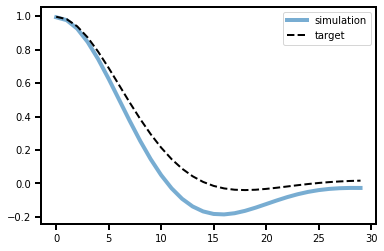

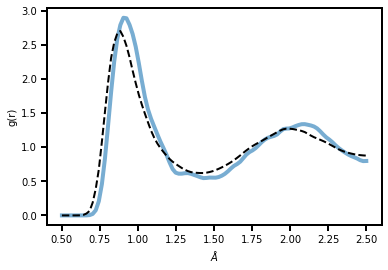

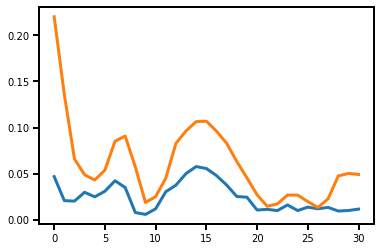

0.016248395666480064 0.05050109326839447
0.007192474789917469 0.030847366899251938
0.010033128783106804 0.0282445028424263
0.008092720992863178 0.02496621385216713
0.007695007137954235 0.010397533886134624


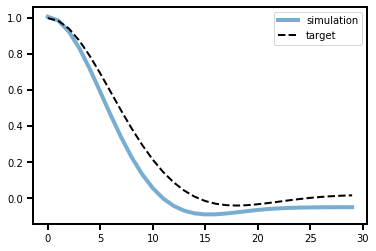

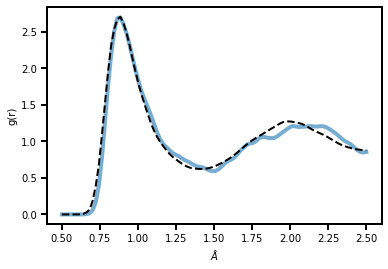

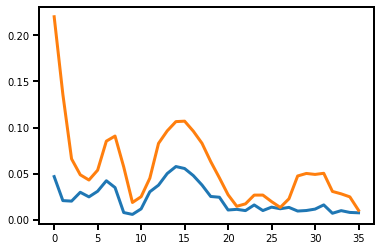

0.00985830370336771 0.013229947537183762
0.009534832090139389 0.021884746849536896
0.011101089417934418 0.02490461990237236
0.010174558497965336 0.03305396810173988
0.012072219513356686 0.021252881735563278


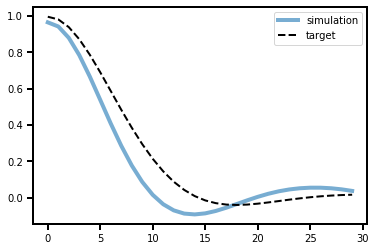

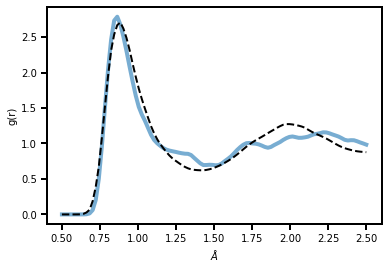

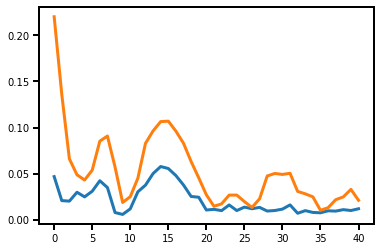

0.009305770508944988 0.013407078571617603
0.00965771172195673 0.009655319154262543
0.007286080624908209 0.011233067139983177
0.004351272247731686 0.011866772547364235
0.010296063497662544 0.01328621618449688


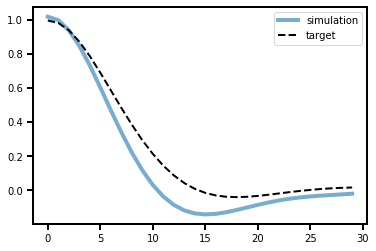

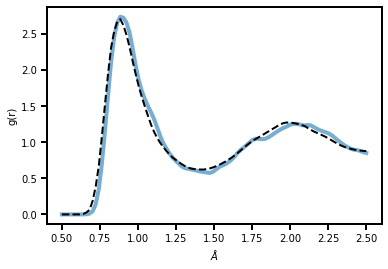

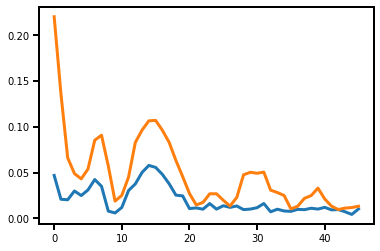

0.007516297046095133 0.012546403333544731
0.009169401600956917 0.01455757301300764
0.005958512891083956 0.011904601939022541
0.009832502342760563 0.013769528828561306
0.0071008834056556225 0.013185106217861176


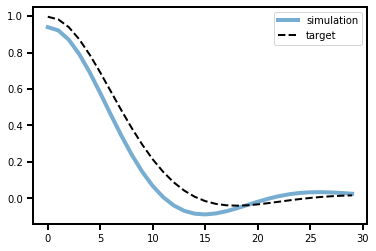

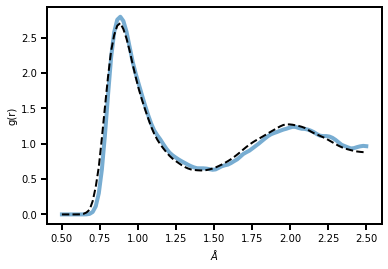

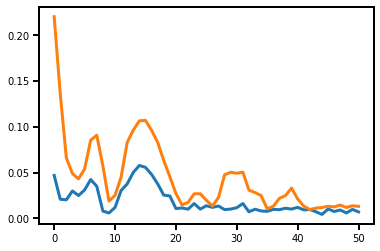

0.005500013940036297 0.009756877087056637
0.004414030816406012 0.009084231220185757
0.00609423266723752 0.008321689441800117
0.004071597009897232 0.005658427719026804
0.006996072828769684 0.008833345025777817


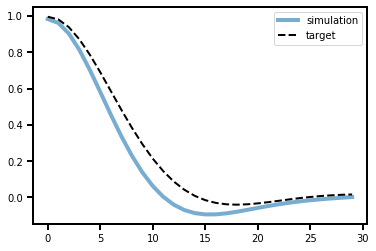

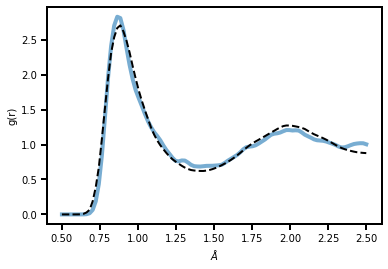

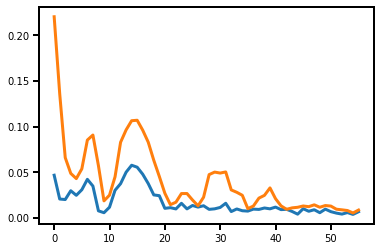

0.004992845002561808 0.008901292458176613
0.004963776562362909 0.011139370501041412
0.00463300384581089 0.01215759851038456
0.004871527198702097 0.008021526038646698
0.005036813206970692 0.0064903078600764275


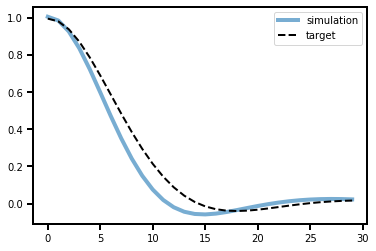

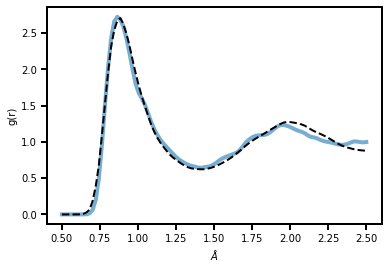

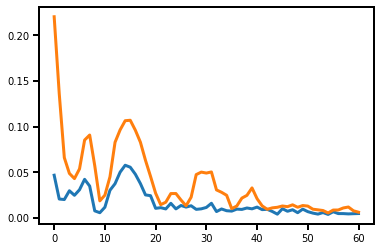

0.005545325577259064 0.009987193159759045
0.005206423345953226 0.006637714337557554
0.005912419408559799 0.006516508292406797
0.003476725658401847 0.008899960666894913
0.0035388153046369553 0.00894407369196415


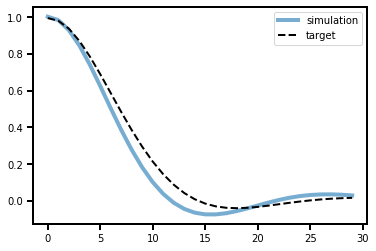

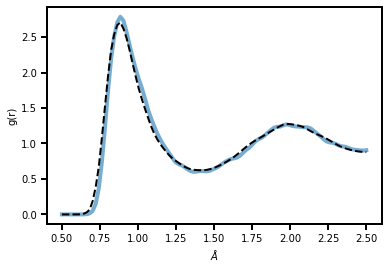

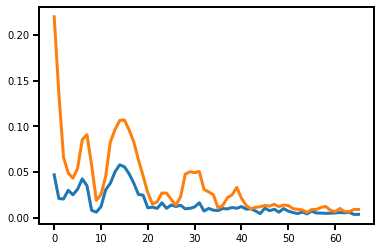

0.007975190877914429 0.009033369831740856
0.0087929992005229 0.01262515690177679
0.005154815968126059 0.008141622878611088
0.005109166260808706 0.007111737504601479
0.006521181669086218 0.00825770664960146


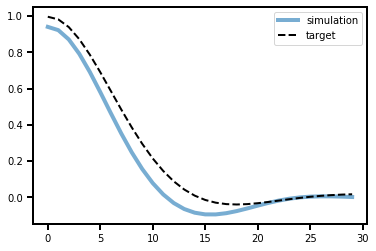

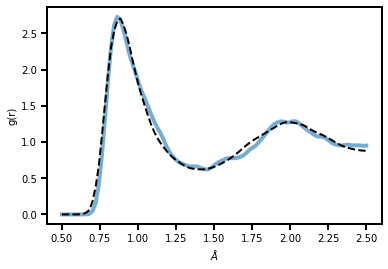

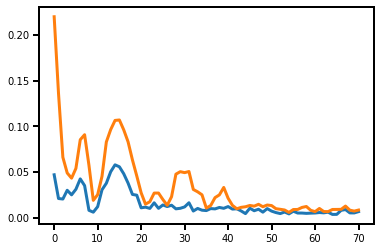

0.005137795582413673 0.0064750248566269875
0.002807525685057044 0.006141980644315481
0.0033414666540920734 0.005986017175018787
0.004950608592480421 0.00738123245537281
0.002070542424917221 0.009440499357879162


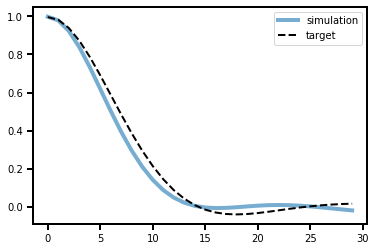

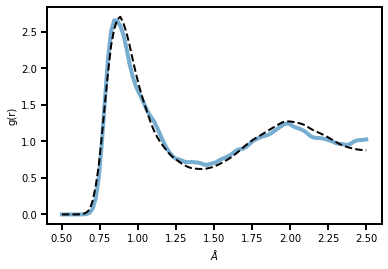

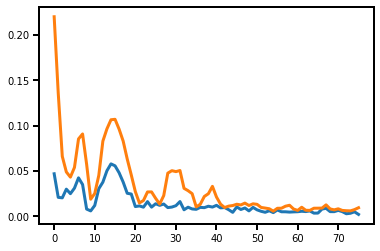

0.006650732830166817 0.011918075382709503
0.0026615336537361145 0.007685174234211445
0.004402766469866037 0.006949499249458313
0.00276249460875988 0.006276634056121111
0.0015699183568358421 0.006527488119900227


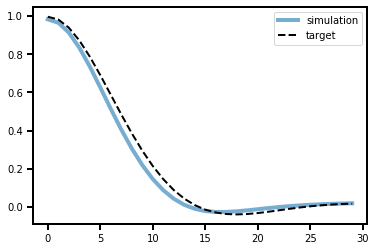

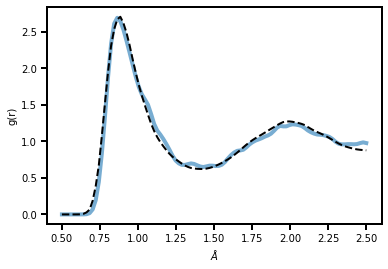

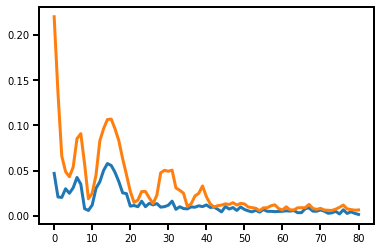

0.0068456572480499744 0.006194625981152058
0.0049592275172472 0.006760448217391968
0.00377801526337862 0.009156562387943268
0.0026968501042574644 0.010224681347608566
0.0027578624431043863 0.005843108054250479


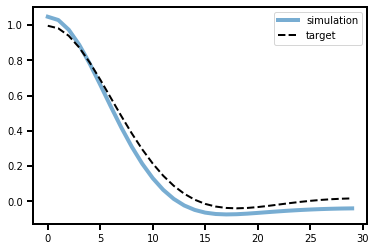

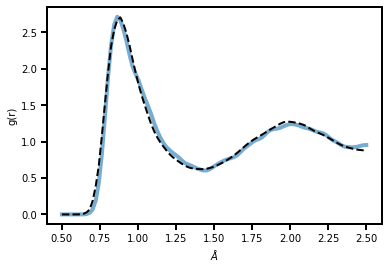

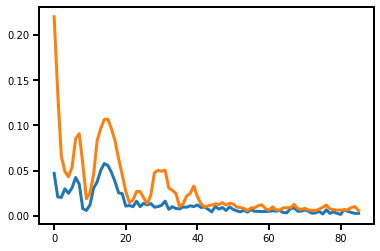

0.0032666621264070272 0.008275882340967655
0.004567807074636221 0.008985708467662334
0.00680884812027216 0.005705683957785368
0.0067040761932730675 0.006498502567410469
0.004997396841645241 0.006449669599533081


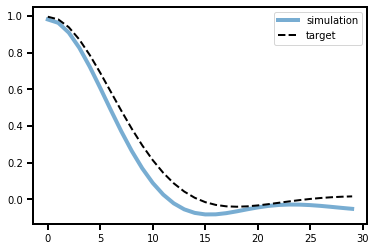

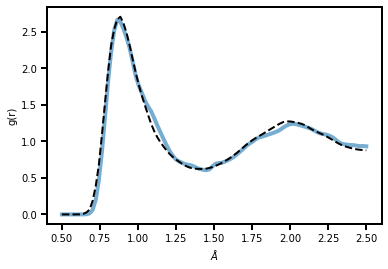

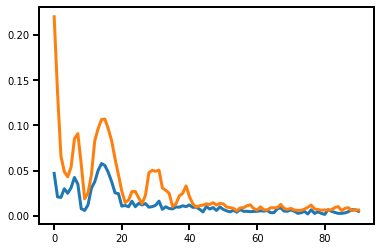

0.001726425252854824 0.006173828616738319
0.006321636028587818 0.00898850616067648
0.00831208098679781 0.0066461022943258286
0.006405613385140896 0.006369227077811956
0.0028006797656416893 0.006660946644842625


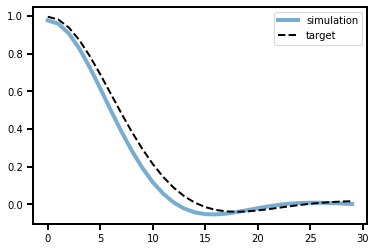

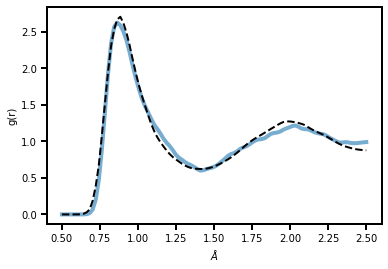

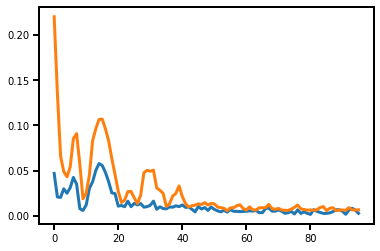

0.0036581321619451046 0.005164844449609518
0.002422956982627511 0.004985442850738764
0.005437204148620367 0.006033740937709808
0.00637005316093564 0.006009705364704132
0.0022803149186074734 0.006396559998393059


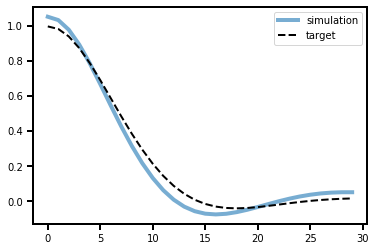

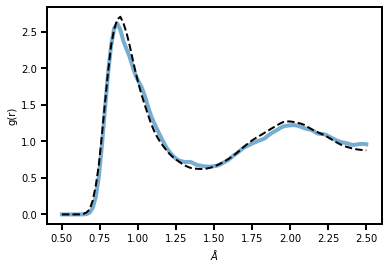

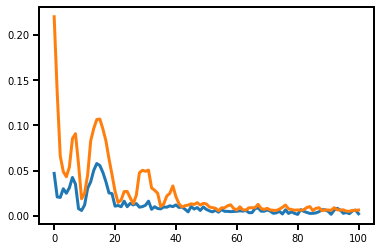

0.004274046514183283 0.006147032603621483
0.004342372063547373 0.004338469356298447
0.0037897410802543163 0.005739969201385975
0.003192081581801176 0.006441819481551647
0.004420536570250988 0.00591613631695509


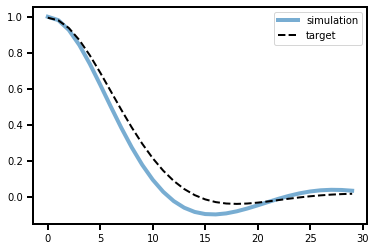

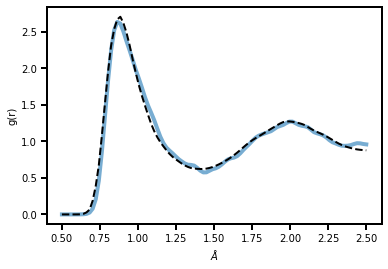

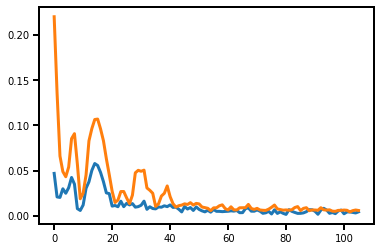

0.004915964789688587 0.005576229654252529
0.0032099580857902765 0.004794350825250149
0.0024585833307355642 0.005693818908184767
0.005289046559482813 0.004664472304284573
0.001923132804222405 0.005451734643429518


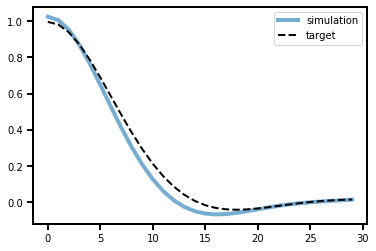

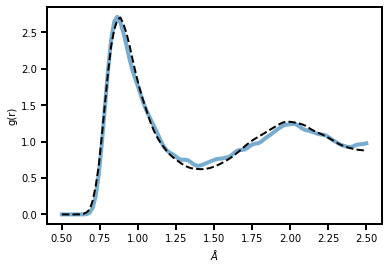

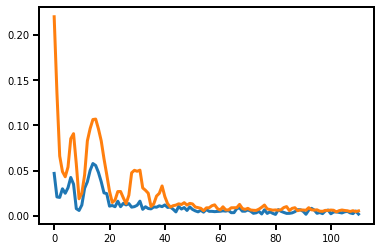

0.0028121466748416424 0.005336319096386433
0.005500226281583309 0.005337005481123924
0.0042579444125294685 0.003028969280421734
0.005143686197698116 0.005246140994131565
0.0029865570832043886 0.0062450235709548


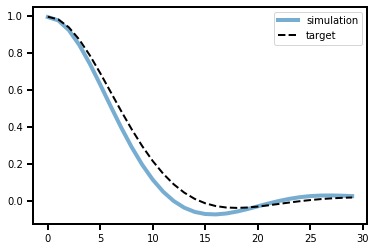

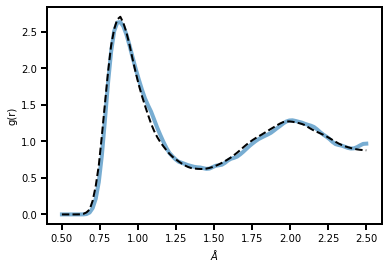

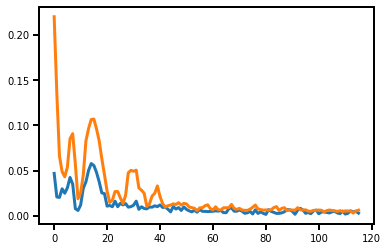

0.004238381050527096 0.0037746301386505365
0.002014648634940386 0.006627651862800121
0.008405040949583054 0.006156564690172672
0.0023505541030317545 0.0032782466150820255
0.0012561718467622995 0.003717138897627592


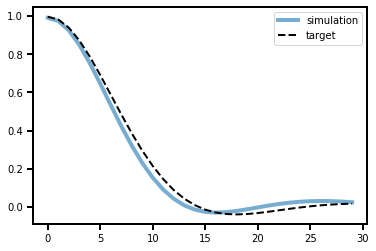

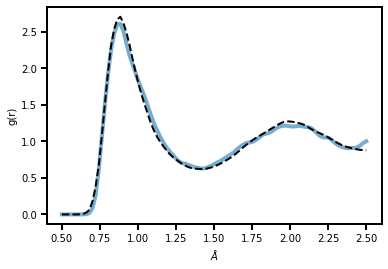

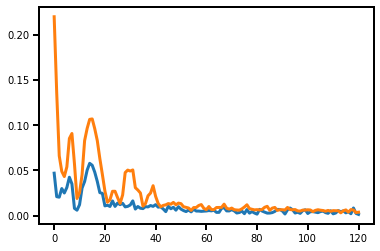

0.0018034776439890265 0.004791811108589172
0.0026205056346952915 0.006338115781545639
0.0038638380356132984 0.004615834914147854
0.0035198794212192297 0.0038975479546934366
0.0037988992407917976 0.0034580177161842585


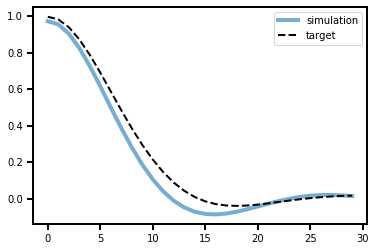

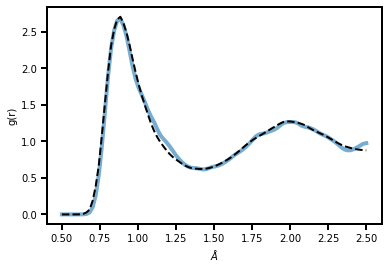

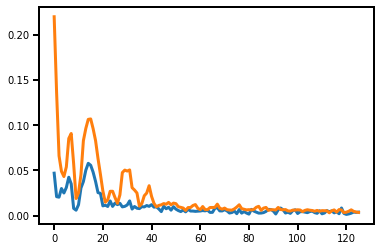

0.0013937399489805102 0.003067704848945141
0.00322136003524065 0.002583481837064028
0.0024188149254769087 0.003245975123718381
0.003972581587731838 0.0038415761664509773
0.0018567751394584775 0.003726430470123887


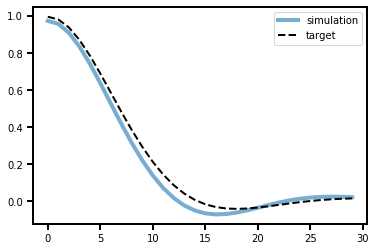

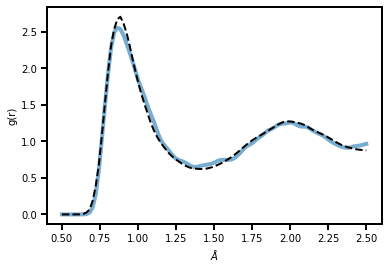

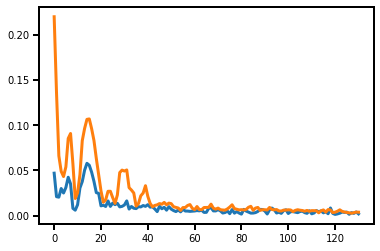

0.002875055419281125 0.0029877691995352507
0.0025054935831576586 0.002692703390493989
0.0017829947173595428 0.003694476094096899
0.003973641898483038 0.003150714561343193
0.0031294904183596373 0.001953211845830083


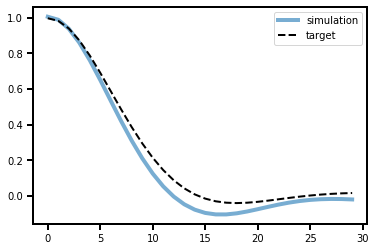

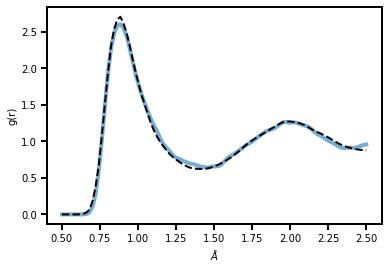

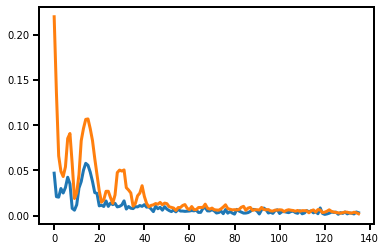

0.004841940943151712 0.0037392014637589455
0.004847387783229351 0.0038481736555695534
0.0022052801214158535 0.003320923075079918
0.0029857696499675512 0.002723367651924491
0.0005739183980040252 0.003635585308074951


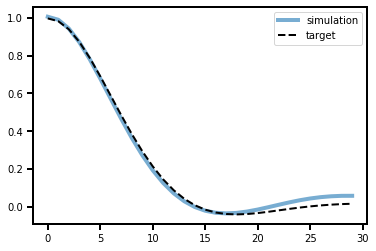

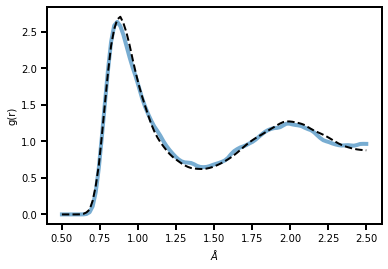

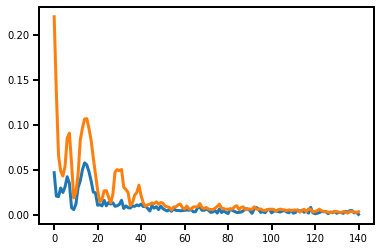

0.00222957250662148 0.0030633818823844194
0.003568233223631978 0.0025699003599584103
0.002704070182517171 0.003937668167054653
0.0025298388209193945 0.0027974878903478384
0.0037735728546977043 0.0029323217459023


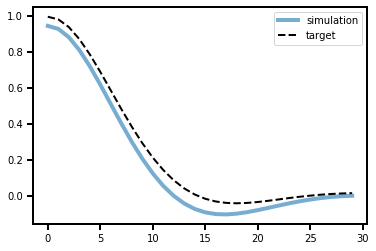

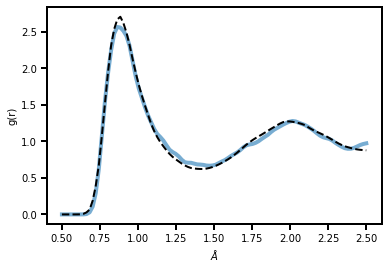

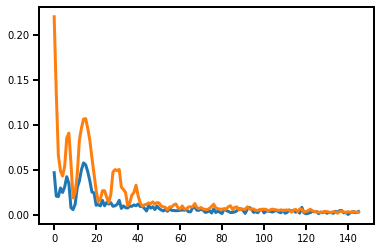

0.006518051493912935 0.002624416956678033
0.003083044895902276 0.0035351389087736607
0.0026597068645060062 0.0035773972049355507
0.0032441760413348675 0.003670950187370181
0.0017862943932414055 0.0034577446058392525


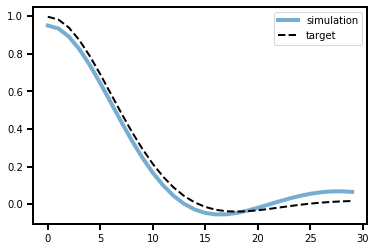

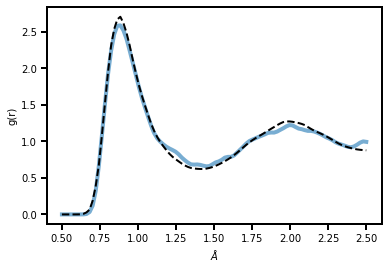

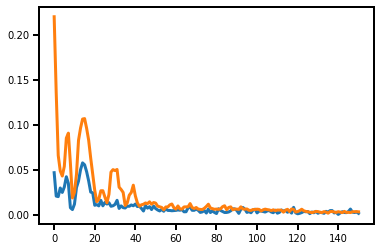

0.0009321951074525714 0.0029301969334483147
0.0035058336798101664 0.0030195345170795918
0.003440394764766097 0.0033160161692649126
0.006582518573850393 0.00482053030282259
0.005940280854701996 0.003757126396521926


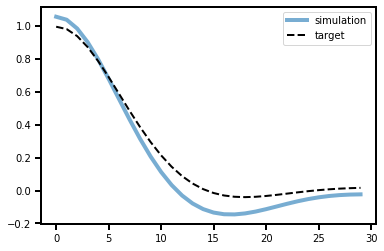

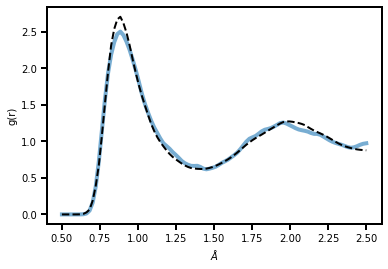

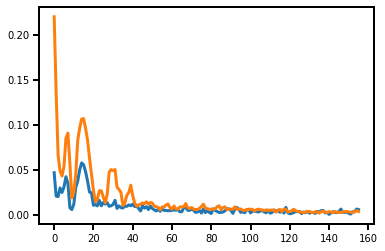

0.0029454962350428104 0.0023271923419088125
0.003403523238375783 0.003180302679538727
0.0029311475809663534 0.0032983713317662477
0.0010010693222284317 0.0034304664004594088
0.004604170098900795 0.0038373505230993032


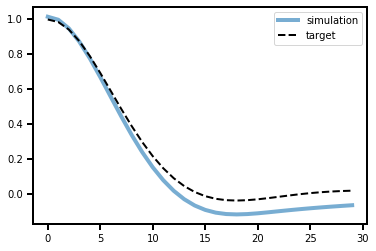

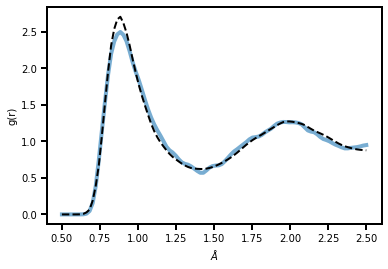

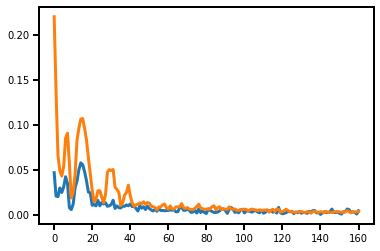

0.0037575517781078815 0.002889779396355152
0.00040987503598444164 0.004480092786252499
0.0012432215735316277 0.003686459269374609
0.0010480911005288363 0.002647093031555414
0.0007874625152908266 0.0031128828413784504


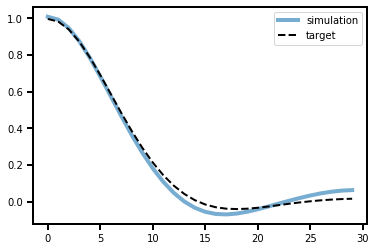

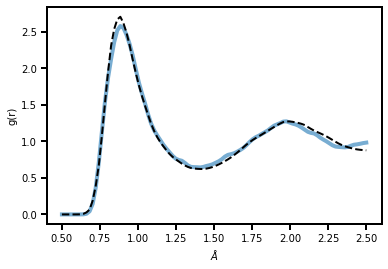

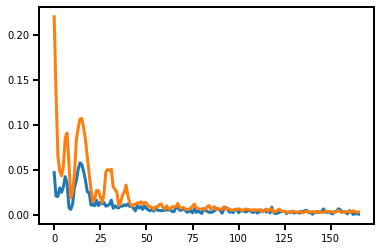

0.0029941238462924957 0.0028435648418962955
0.0031565395183861256 0.0029383916407823563
0.0029530548490583897 0.003325248369947076
0.0036848867312073708 0.005092039704322815
0.0020958040840923786 0.005004911217838526


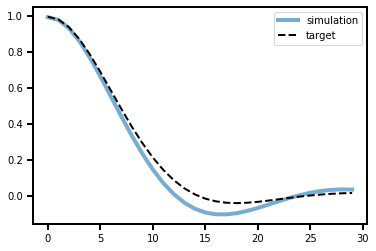

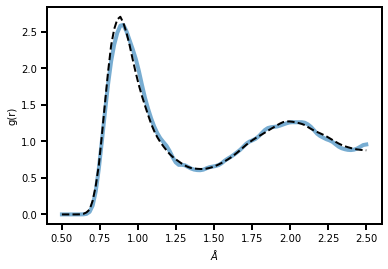

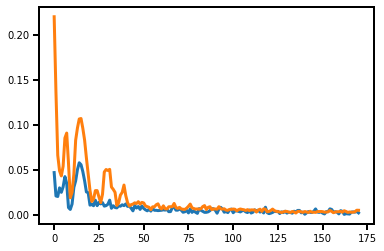

0.0032731438986957073 0.0031209492590278387
0.0004288743366487324 0.0025297850370407104
0.0015587718226015568 0.00317092752084136
0.0012012288207188249 0.0030560034792870283
0.0007372391992248595 0.002482588170096278


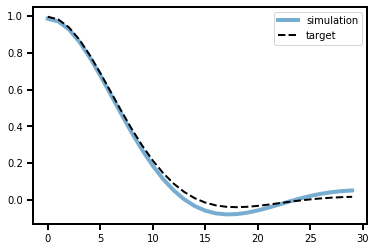

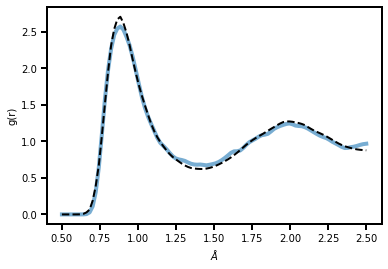

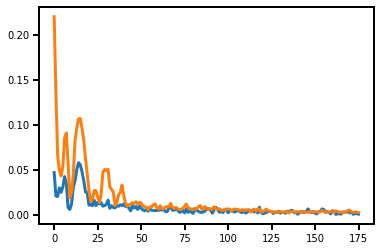

0.00242426386103034 0.002487343270331621
0.0034831834491342306 0.0018853337969630957
0.005611582193523645 0.003282142337411642
0.003627898171544075 0.00431374367326498
0.0022456394508481026 0.002971986774355173


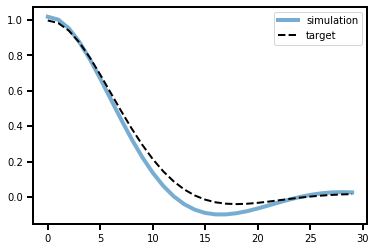

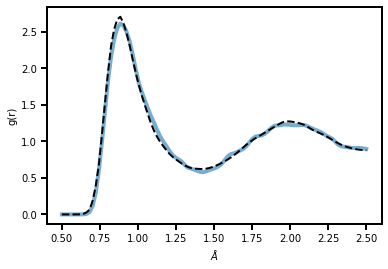

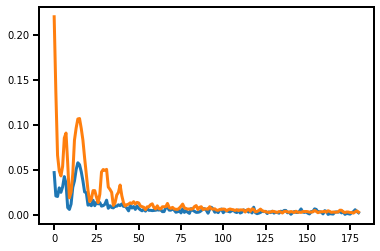

0.0009287364082410932 0.0034857471473515034
0.0021950278896838427 0.004074849188327789
0.0009291127207688987 0.002524405485019088
0.002286365954205394 0.006695732939988375
0.0012770947068929672 0.012538360431790352


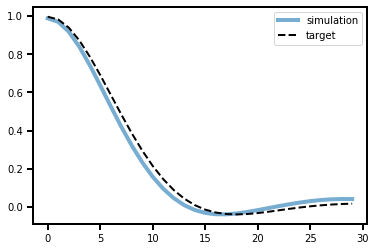

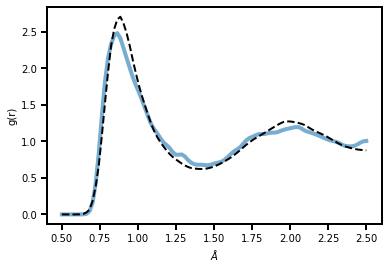

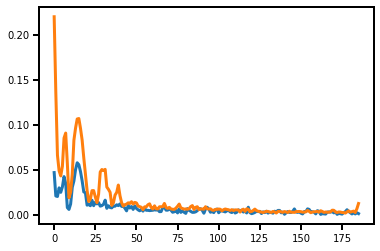

0.0024335873313248158 0.0035518365912139416
0.0032911067828536034 0.0026672733947634697
0.004526038188487291 0.0034734136424958706
0.0026935923378914595 0.006369485054165125
0.0031190949957817793 0.005358206108212471


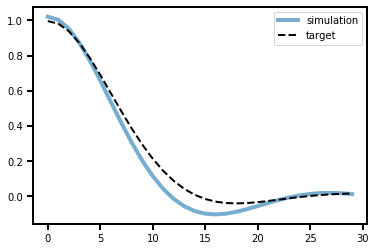

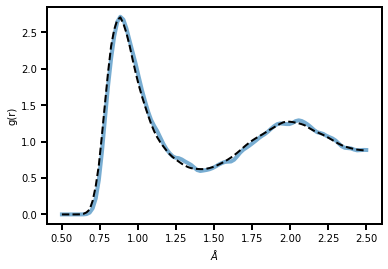

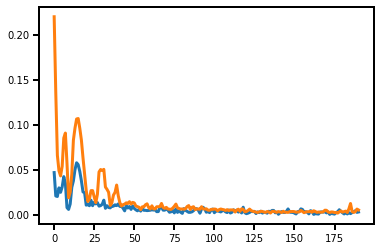

0.00860935915261507 0.009084120392799377
0.002290520118549466 0.010295900516211987
0.0035961002577096224 0.003154508536681533
Epoch   194: reducing learning rate of group 0 to 2.5000e-03.
0.0016168729634955525 0.004470053128898144
0.0015134370187297463 0.00604470819234848


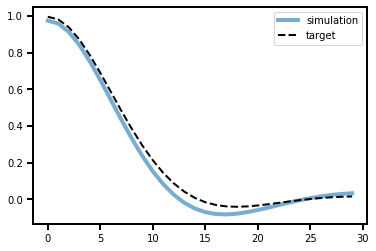

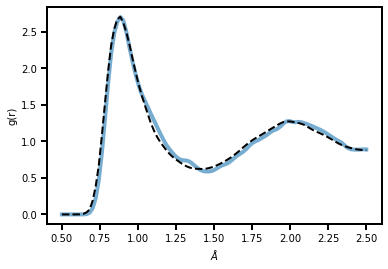

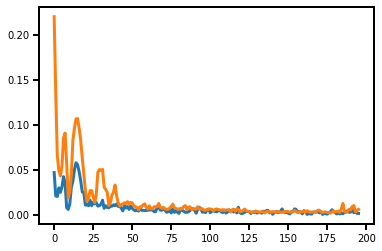

0.002854750258848071 0.0025810233782976866
0.0022140699438750744 0.0029318807646632195
0.0017184780444949865 0.0045263865031301975
0.0034946375526487827 0.005049073603004217
0.002145825419574976 0.0044087981805205345


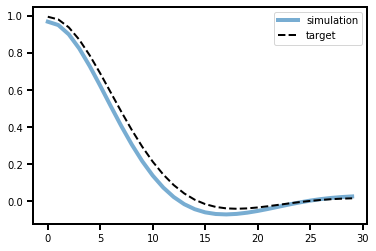

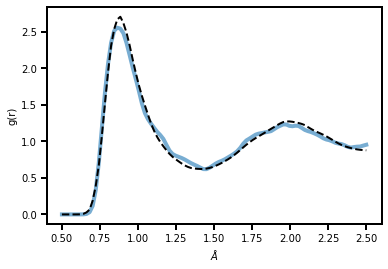

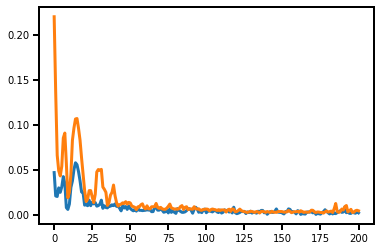

0.0019242140697315335 0.0032836657483130693
0.001773070776835084 0.0036216392181813717
0.002631252631545067 0.00457698805257678
0.0004025621456094086 0.003454784397035837
0.0016206024447456002 0.004091363400220871


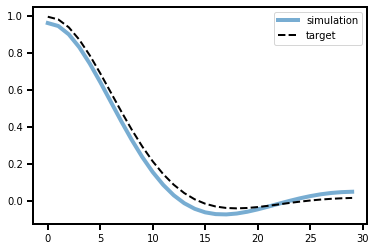

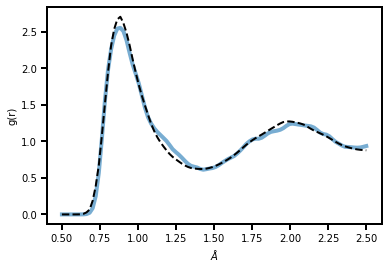

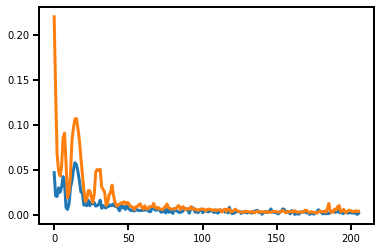

0.002052167896181345 0.00325499614700675
0.0019637555815279484 0.002873847493901849
0.006713162176311016 0.005499470978975296
0.004706478677690029 0.002885563764721155
0.003968729171901941 0.002919236198067665


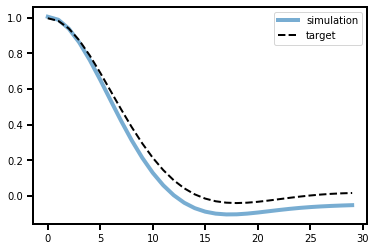

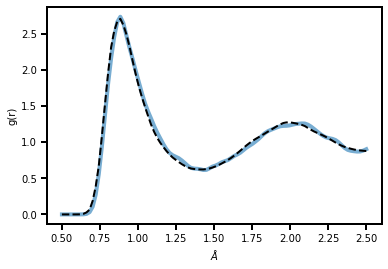

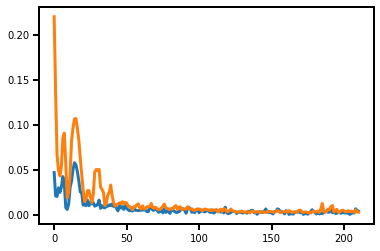

0.0009403954609297216 0.0047392696142196655
0.0006069905357435346 0.003628698643296957
0.0008477900410071015 0.0018500890582799911
0.0007221123087219894 0.0036919713020324707
0.0024986560456454754 0.0029561324045062065


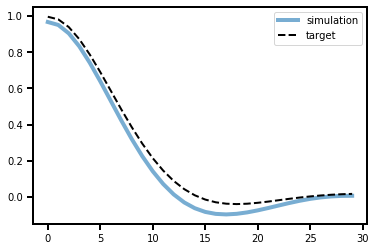

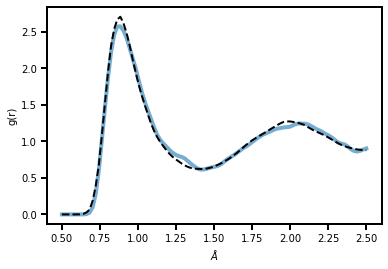

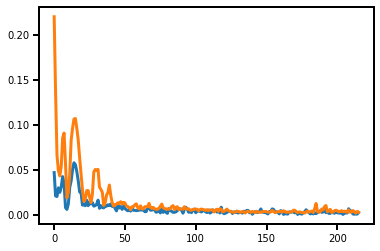

0.004220946691930294 0.003196737030521035
0.002283060923218727 0.00576549768447876
0.0007613495108671486 0.003958483226597309
0.0024853574577718973 0.002188039943575859
0.0031044757924973965 0.004279068671166897


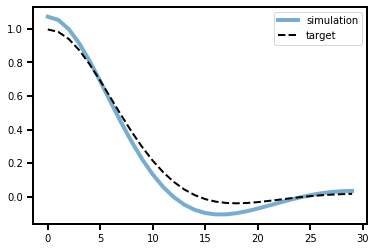

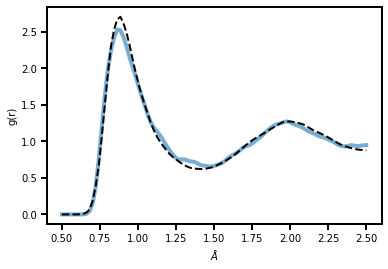

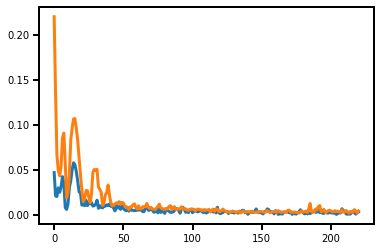

0.0013272685464471579 0.0035843495279550552
0.001271757297217846 0.004044526722282171
0.0017506306758150458 0.00447978125885129
0.004108003340661526 0.0026480737142264843
0.0021887565962970257 0.005653022322803736


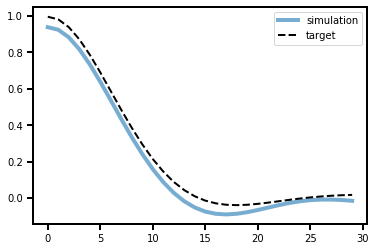

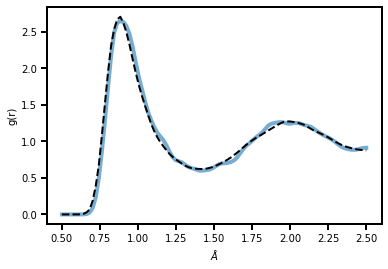

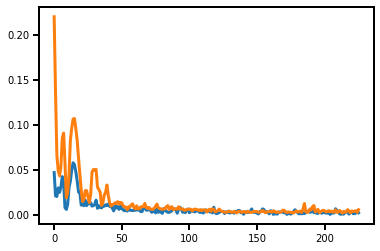

0.0021335729397833347 0.0028826233465224504
0.004164773505181074 0.002350546419620514
0.00210559437982738 0.0020609390921890736
0.002340832492336631 0.0020135901868343353
0.0025127616245299578 0.003402970964089036


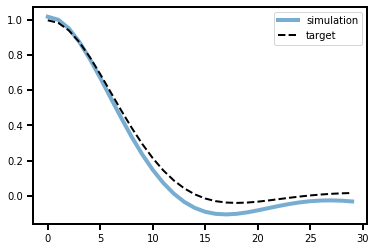

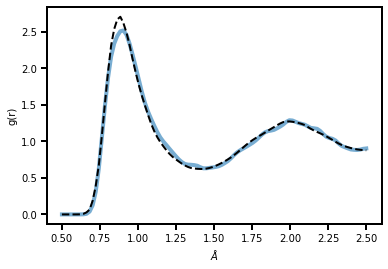

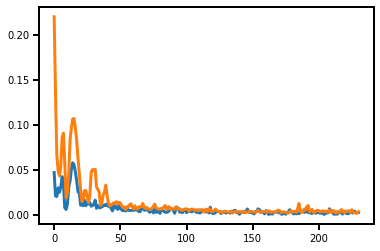

0.0016255551017820835 0.002880252432078123
0.0014996944228187203 0.002131253946572542
0.00044024307862855494 0.005243522115051746
0.0018766685388982296 0.004536210559308529
Epoch   235: reducing learning rate of group 0 to 1.2500e-03.
0.0005008636508136988 0.005901660304516554


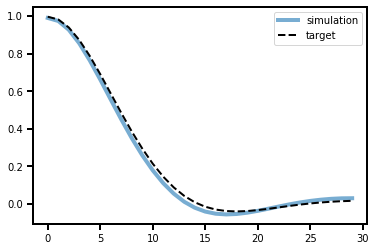

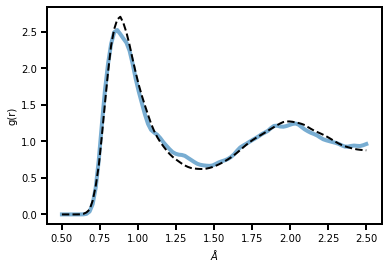

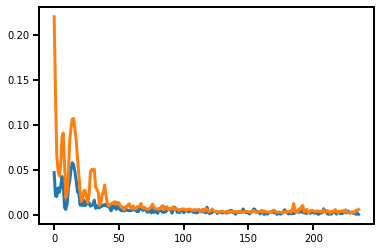

0.0021955654956400394 0.008791454136371613
0.0001700034481473267 0.004984155297279358
0.0023815843742340803 0.005320660304278135
0.0012672864831984043 0.0037802220322191715
0.0012246208498254418 0.0020957263186573982


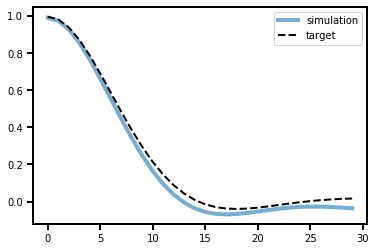

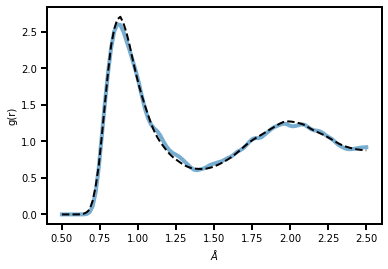

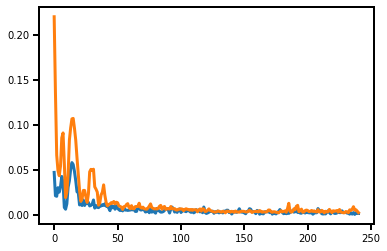

0.0017093478236347437 0.002163257682695985
0.000614110438618809 0.0021809919271618128
0.004643687978386879 0.005349775776267052
0.003995162434875965 0.0025417860597372055
0.0035852910950779915 0.00145547348074615


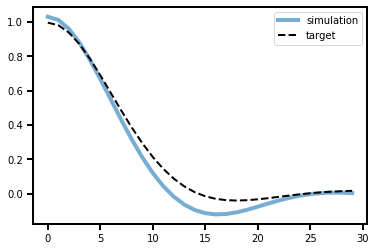

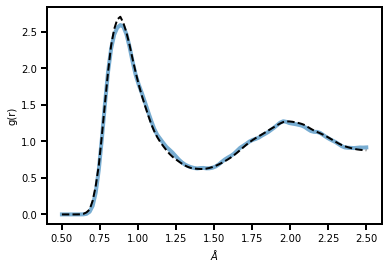

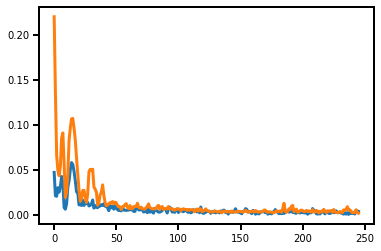

0.007306387182325125 0.004085892345756292
0.0014924186980351806 0.002581940498203039
0.0010001661721616983 0.002430511172860861
0.0039278920739889145 0.0018940865993499756
0.0008408293360844254 0.002514350228011608


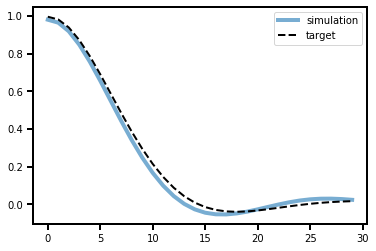

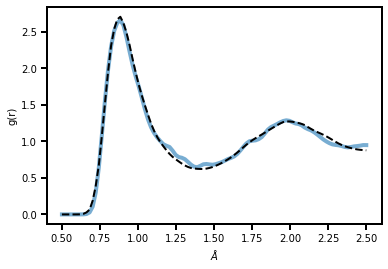

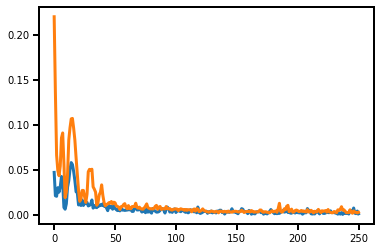

0.0006684440304525197 0.0035770931281149387
0.0027327623683959246 0.002257377142086625
0.0011939839459955692 0.0024022518191486597
0.00260115135461092 0.003168768249452114
0.001452393364161253 0.0016639993991702795
Epoch   256: reducing learning rate of group 0 to 6.2500e-04.


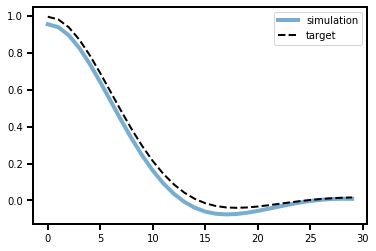

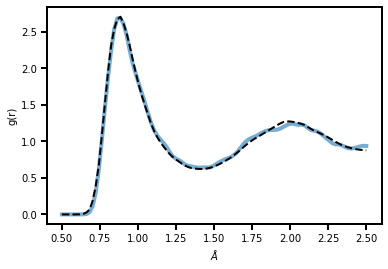

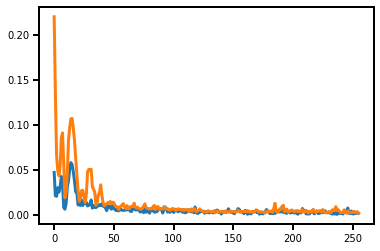

0.0007159521919675171 0.00211784103885293
0.000565266003832221 0.002106481697410345
0.00045590943773277104 0.0015820818953216076
0.000791736354585737 0.0017878884682431817
0.001847157604061067 0.0018943657632917166


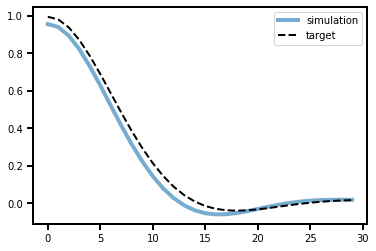

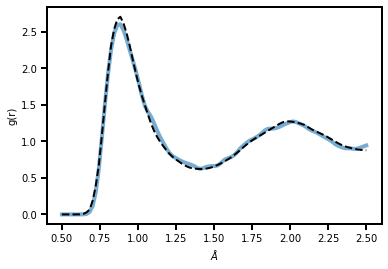

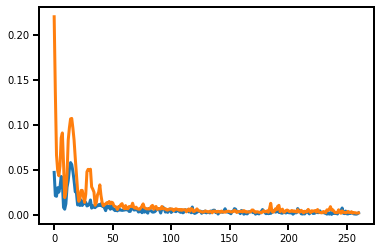

0.0037484876811504364 0.0018702842062339187
0.0022285394370555878 0.002949958201497793
0.002068870235234499 0.0016555747715756297
0.0011371865402907133 0.001795802265405655
0.0006940527819097042 0.00220554624684155


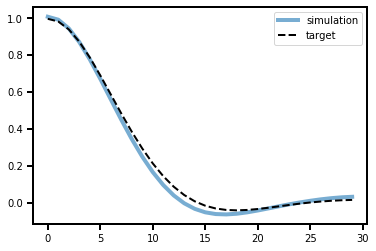

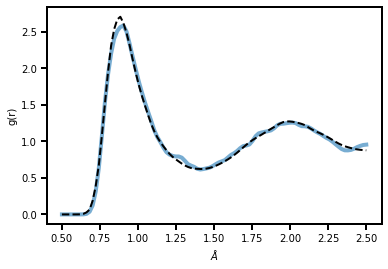

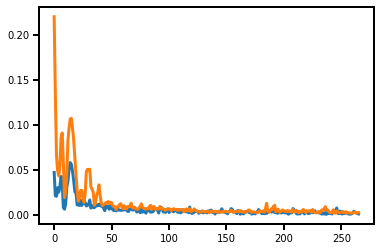

0.0032361294142901897 0.00251422799192369
0.002598983934149146 0.0019641330000013113
0.0006493342807516456 0.003433528821915388
0.0016433666460216045 0.002240418456494808
0.0017642282182350755 0.00206300662830472


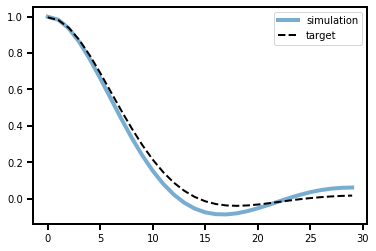

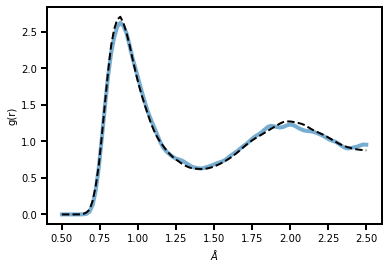

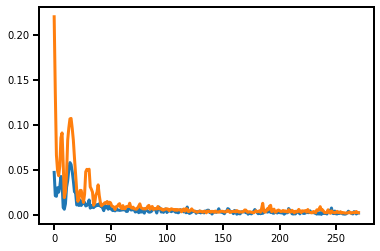

0.0018416020320728421 0.0018426051829010248
0.0020123019348829985 0.0018886136822402477
0.0024347833823412657 0.0014539423864334822
0.002641614992171526 0.002651214599609375
0.001461944542825222 0.0022080144844949245


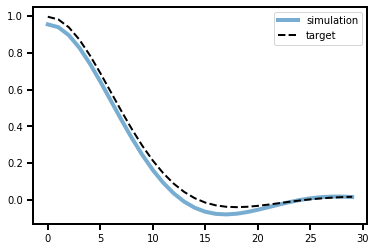

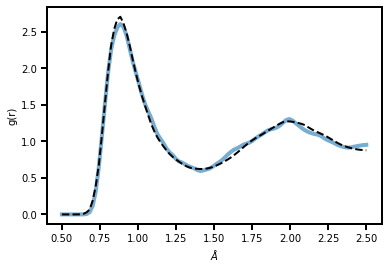

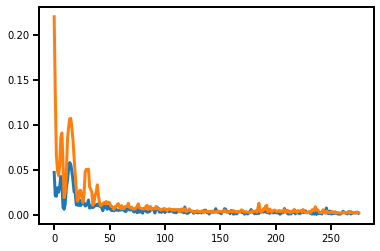

0.002369961002841592 0.0017708077793940902
0.002562269102782011 0.0020554603543132544
0.0011602852027863264 0.0014170750509947538
0.0018215456511825323 0.002269651275128126
Epoch   280: reducing learning rate of group 0 to 3.1250e-04.
0.0016604758566245437 0.002672645729035139


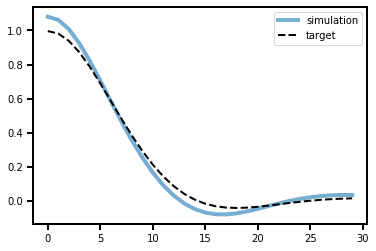

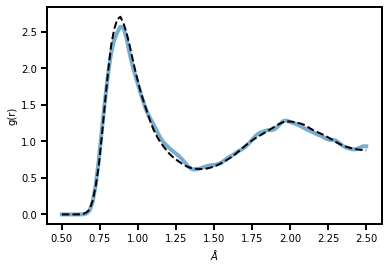

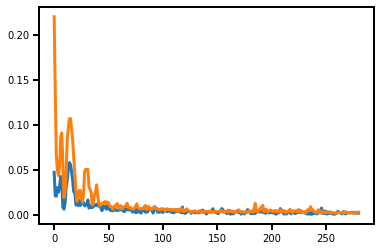

0.0019142561359331012 0.0017074125353246927
0.0004063841188326478 0.001569006242789328
0.0012013851664960384 0.002300746040418744
0.005573981441557407 0.002009906806051731
0.0024431373458355665 0.0021567330695688725


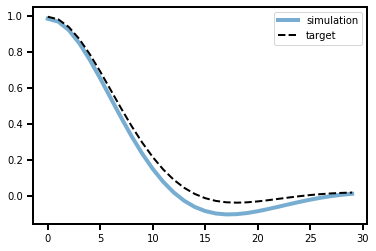

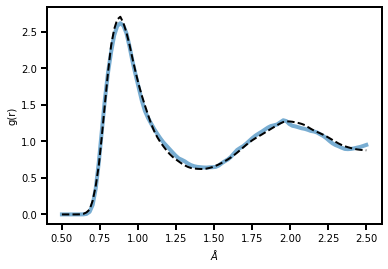

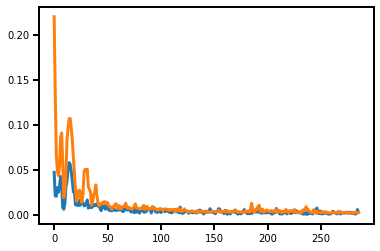

0.004775478970259428 0.0021062656305730343
0.0014184031169861555 0.001798870973289013
0.0007274882518686354 0.002377135679125786
0.0008808206184767187 0.0032352248672395945
0.0017592955846339464 0.002621367573738098


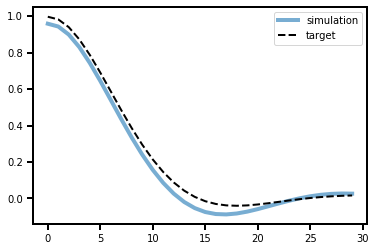

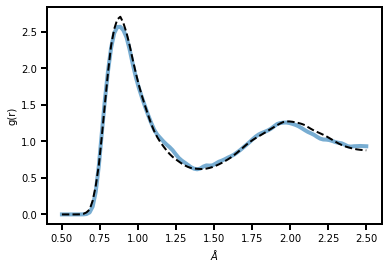

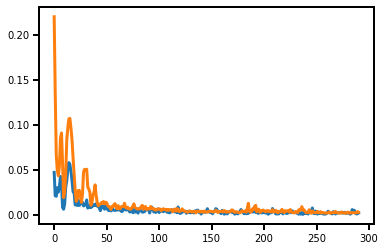

0.0008296787273138762 0.002279779175296426
0.0008056419901549816 0.0022453234996646643
0.0003416624094825238 0.002444228855893016
0.0030227876268327236 0.002024551620706916
0.0005220078164711595 0.0023303537163883448


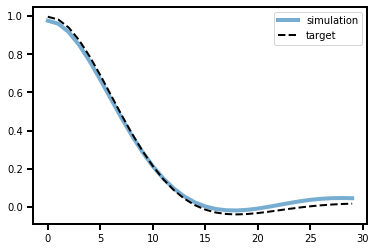

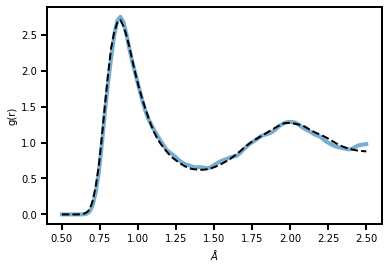

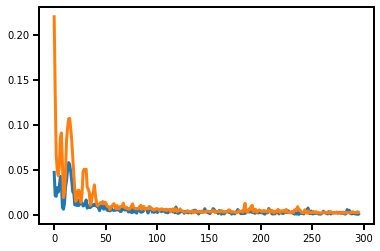

0.0007947207195684314 0.0020944508723914623
0.002008712152019143 0.0024204079527407885
0.0008121664868667722 0.002752742962911725
0.0010215335059911013 0.002560737542808056
0.0014407975832000375 0.0019471370615065098


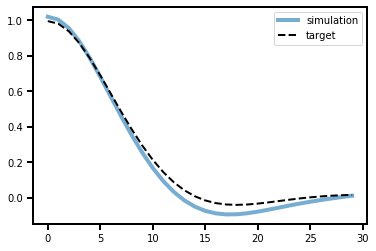

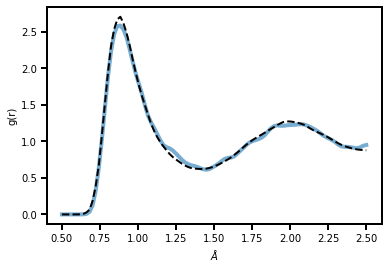

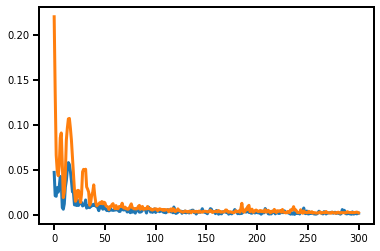

0.0017146274913102388 0.002209921134635806
0.003197440644726157 0.0015840585110709071
0.001363634248264134 0.0017587834736332297
Epoch   304: reducing learning rate of group 0 to 1.5625e-04.
0.001596934162080288 0.001799421850591898
0.0015921519370749593 0.001840304583311081


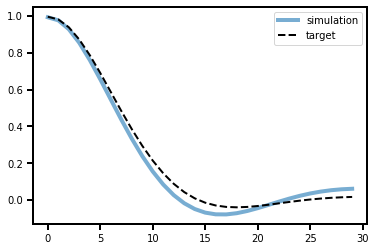

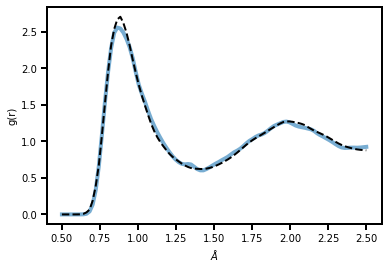

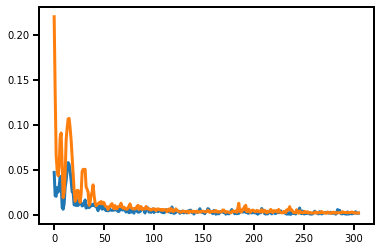

0.001378503511659801 0.0016774339601397514
0.002806262578815222 0.002139233984053135
0.001378455082885921 0.0018263590754941106
0.00439473195001483 0.002330007031559944
0.0007470630225725472 0.0020915407221764326


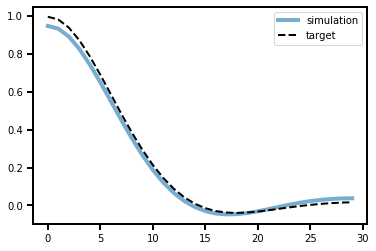

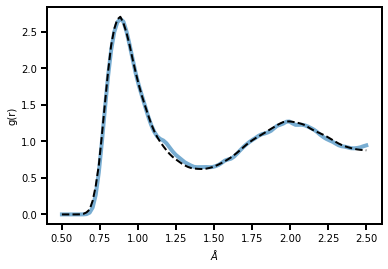

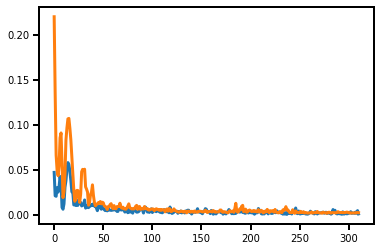

0.002108696149662137 0.001858357572928071
0.0036614295095205307 0.0013666460290551186
0.0034687991719692945 0.0020320862531661987
0.002200077986344695 0.0017893234035000205
0.0020366618409752846 0.002252900740131736


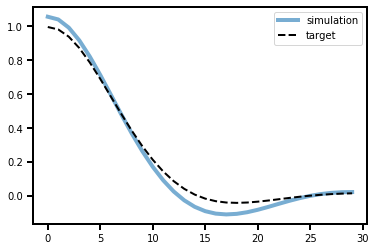

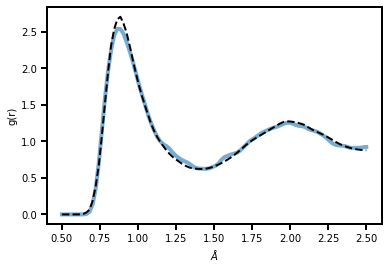

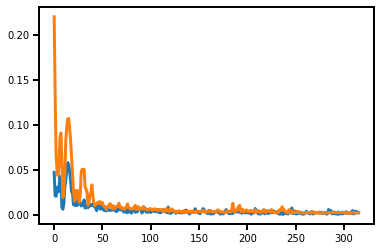

0.001393741462379694 0.0020972792990505695
0.003369151148945093 0.0018547647632658482
0.001288203289732337 0.002038447419181466
0.0015634477604180574 0.0018306765705347061
0.0014473857590928674 0.003064979799091816


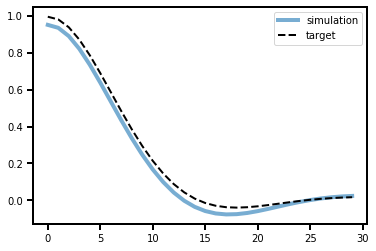

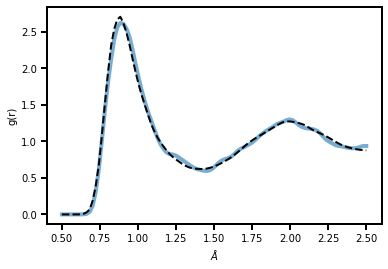

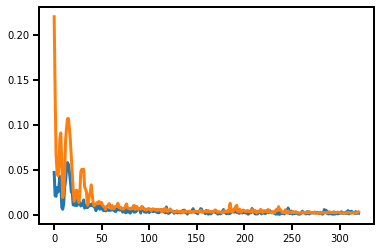

0.00039850891334936023 0.002024485031142831
0.0010791237000375986 0.0028572233859449625
0.0006105861975811422 0.002170330146327615
0.0003786373417824507 0.0016118166968226433
Epoch   325: reducing learning rate of group 0 to 7.8125e-05.
0.0010059139458462596 0.002424484584480524


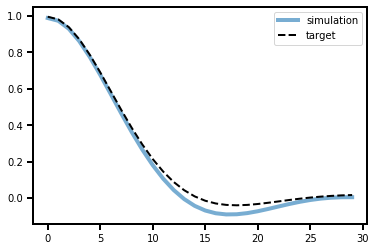

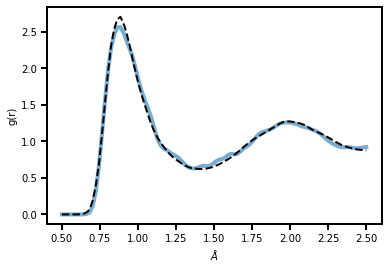

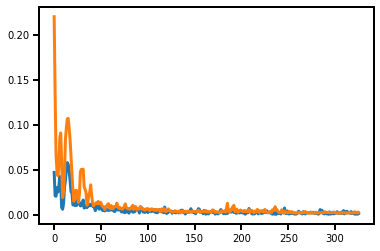

0.0011290180264040828 0.001866757171228528
0.0004690371570177376 0.0016929593402892351
0.000431417633080855 0.001993708312511444
0.0014441395178437233 0.0014467540895566344
0.0007756213890388608 0.0028273784555494785


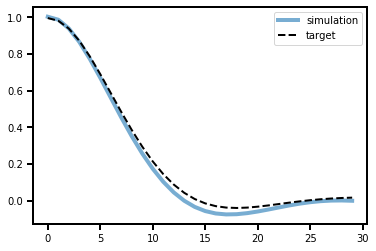

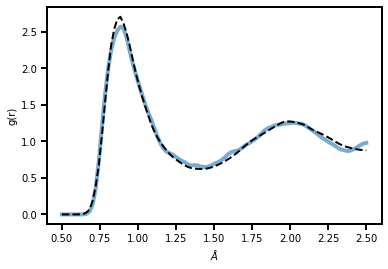

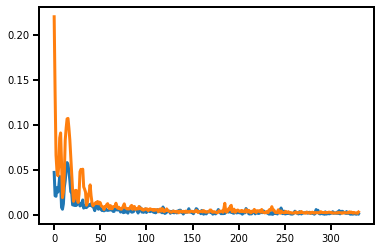

0.0008736752206459641 0.0029995921067893505
0.0006618528277613223 0.0024434998631477356
0.001375046675093472 0.0014761921484023333
0.003949249628931284 0.0023262398317456245
0.0016100152861326933 0.0018774083582684398


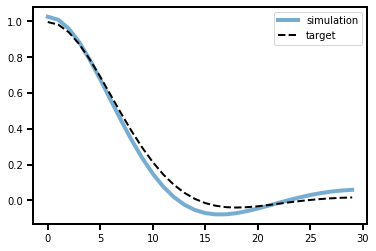

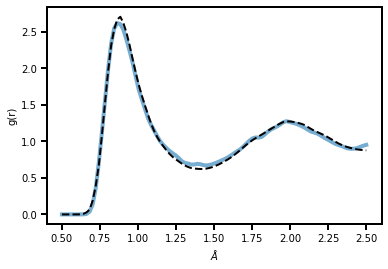

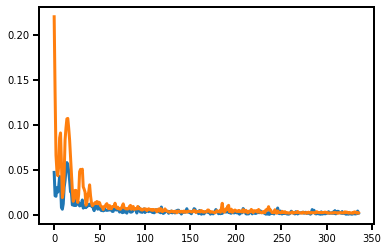

0.002563844434916973 0.001769401365891099
0.003301565535366535 0.0019376548007130623
0.0003349888138473034 0.0018113455735147
0.0012249607825651765 0.0015648587141186
0.0015203537186607718 0.0024714781902730465


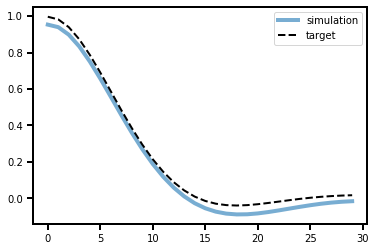

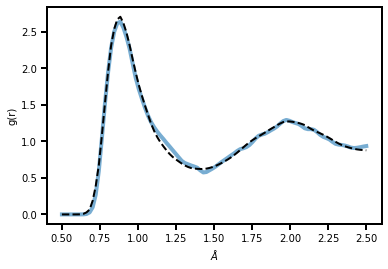

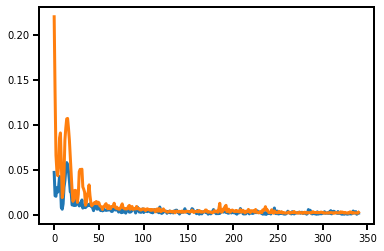

0.0006269055302254856 0.0017367192776873708
0.0022296039387583733 0.0028195767663419247
0.001616664812900126 0.001617551315575838
0.0010948276612907648 0.0018503213068470359
0.0021530617959797382 0.0022582239471375942
Epoch   346: reducing learning rate of group 0 to 3.9063e-05.


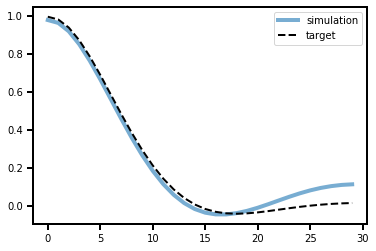

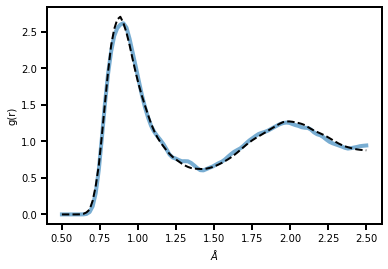

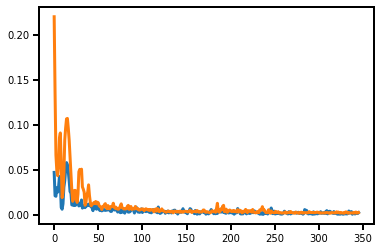

0.001519545097835362 0.0028626685962080956
0.005589579697698355 0.0023442786186933517
0.0016598900547251105 0.0023506716825067997
0.0004668059991672635 0.002615150064229965
0.002371910260990262 0.001960144843906164


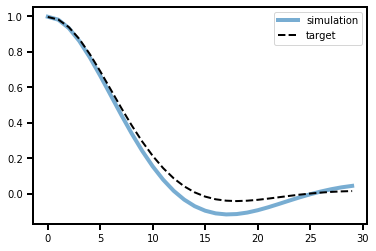

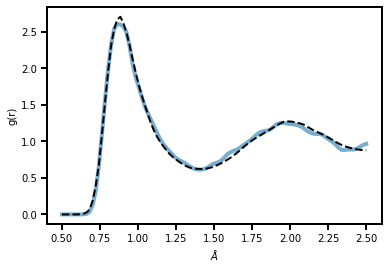

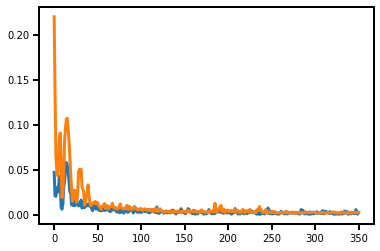

0.0013036741875112057 0.0026515121571719646
0.0007550609880127013 0.0018369932658970356
0.0016459962353110313 0.0021215910091996193
0.000619039754383266 0.0015894484240561724
0.0007736156694591045 0.001889616483822465


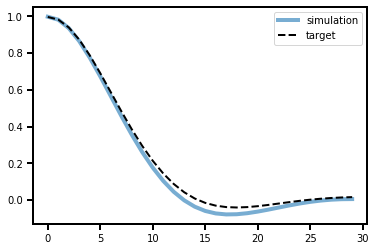

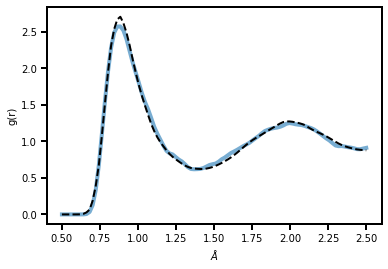

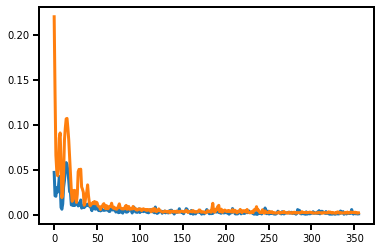

0.0016630275640636683 0.003128612879663706
0.0020623423624783754 0.002449246821925044
0.0007521400111727417 0.0022081066854298115
0.0004220982955303043 0.0019476859597489238
0.001338286674581468 0.0027284289244562387


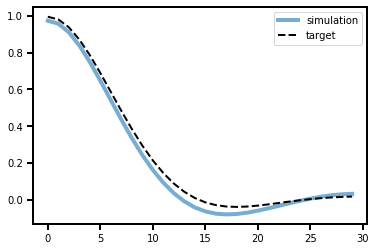

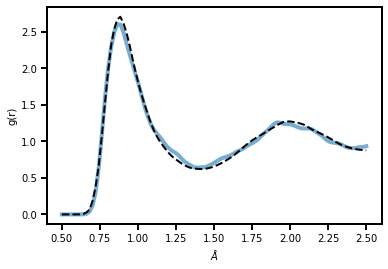

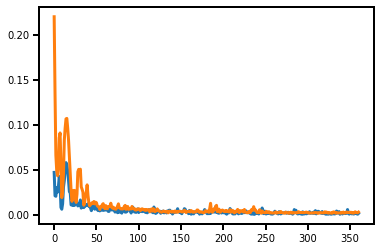

0.0023022154346108437 0.0016204785788431764
0.0012905736221000552 0.0015333842020481825
0.003055095672607422 0.002556809224188328
0.0012172757415100932 0.003812907263636589
0.0014282942283898592 0.002318780869245529


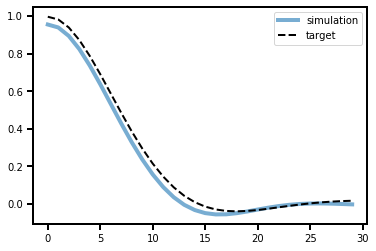

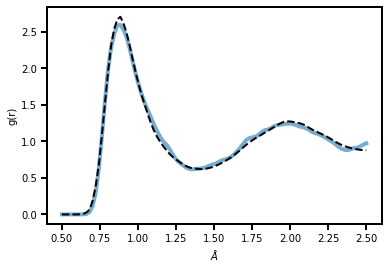

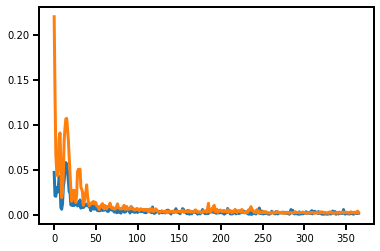

0.0008767057443037629 0.002178337424993515
Epoch   367: reducing learning rate of group 0 to 1.9531e-05.
0.0005217110738158226 0.0014150342904031277
0.002363688312470913 0.0020108239259570837
0.0012000043643638492 0.0013559601502493024
0.0017844141693785787 0.0016496318858116865


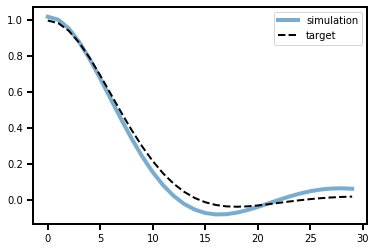

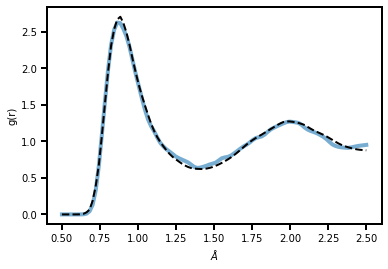

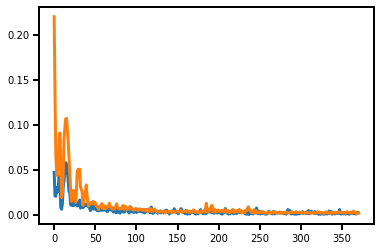

0.0021873400546610355 0.0020425431430339813
0.0014418413629755378 0.001594241475686431
0.00027030386263504624 0.002067192457616329
0.0019397952128201723 0.002417157404124737
0.0015693926252424717 0.0024844487197697163


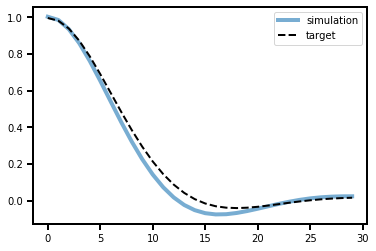

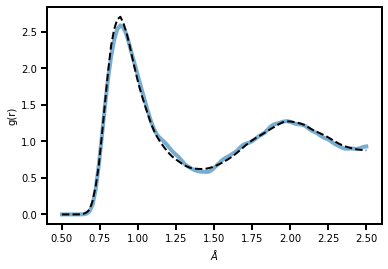

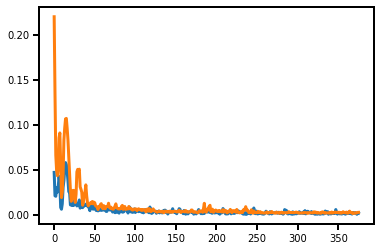

0.0017273958073928952 0.002163410186767578
0.001912651932798326 0.0028305468149483204
0.0019217401277273893 0.0027457016985863447
0.0023270302917808294 0.00237935408949852
0.003701770445331931 0.002188841113820672


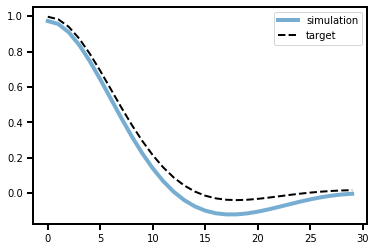

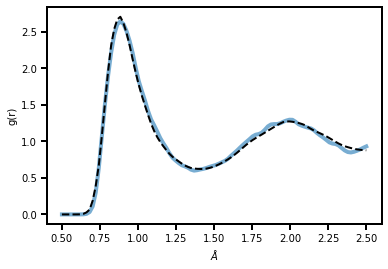

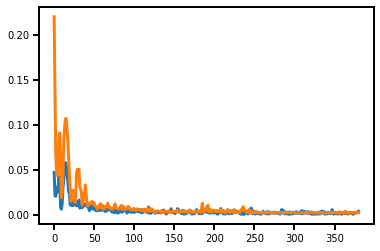

0.004116810392588377 0.003735306905582547
0.0017212250968441367 0.0016104541718959808
0.0031064467038959265 0.0016261619748547673
0.0011097332462668419 0.00240028603002429
0.00274360878393054 0.003220480401068926


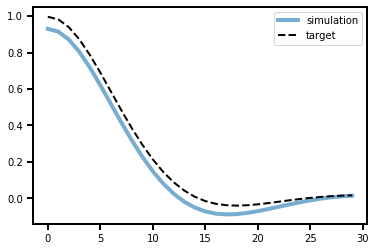

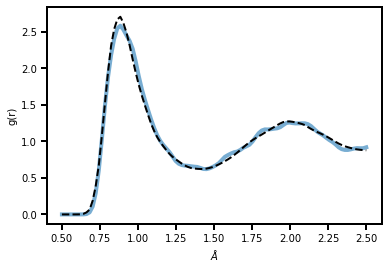

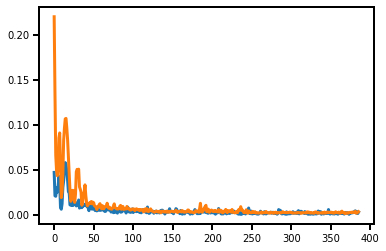

0.002139679156243801 0.002180493902415037
0.0015779276145622134 0.0018771464237943292
0.0016387917567044497 0.0017224571201950312
Epoch   389: reducing learning rate of group 0 to 9.7656e-06.
0.004352306481450796 0.0018468451453372836
0.002173125511035323 0.0021229716949164867


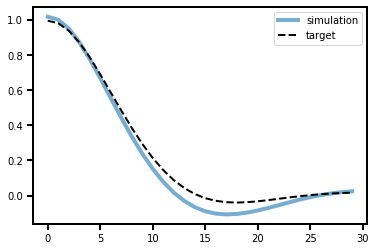

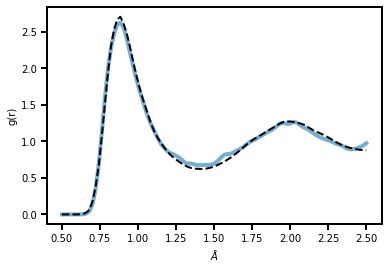

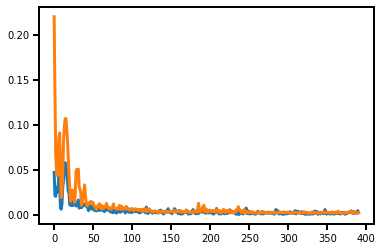

0.001279356423765421 0.002010440919548273
0.0009548963862471282 0.002106635831296444
0.0011723871575668454 0.0018814661307260394
0.0021500398870557547 0.0017580214189365506
0.0022037471644580364 0.002466584090143442


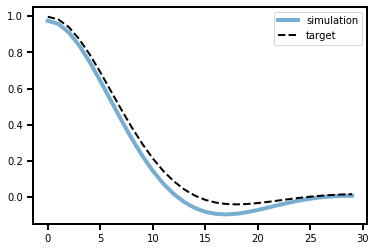

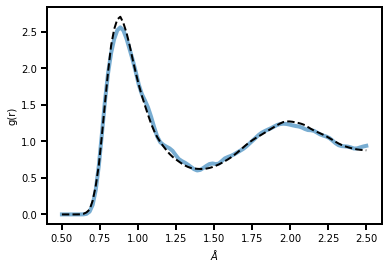

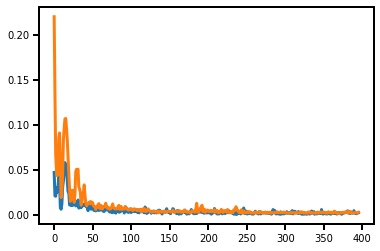

0.0009185287053696811 0.0031882734037935734
0.004982225131243467 0.0027527501806616783
0.004315085243433714 0.0024669754784554243
0.004837434738874435 0.002277522347867489
0.0034165270626544952 0.0018831808120012283


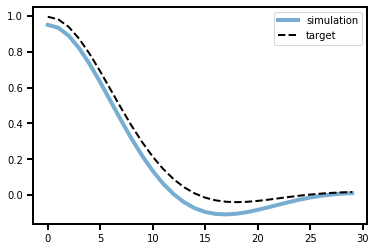

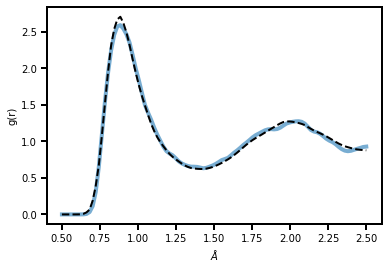

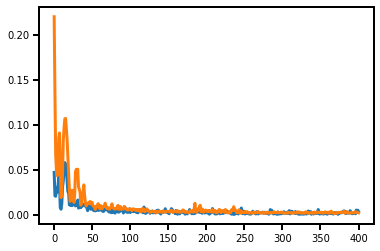

0.0015012379735708237 0.0026000449433922768
0.00024050753563642502 0.001807376160286367
0.0007236411329358816 0.0012688366696238518
0.0019151130691170692 0.0026807060930877924
0.00048459137906320393 0.0019381183665245771


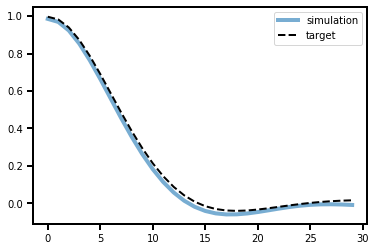

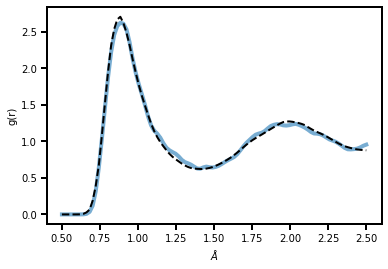

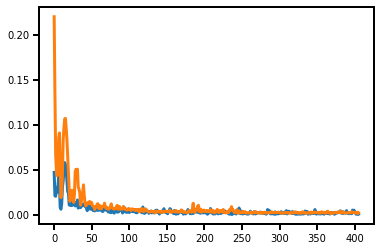

0.00464678043499589 0.002378987381234765
0.002398890210315585 0.0018584525678306818
0.0015456888359040022 0.001459193415939808
0.0014595360262319446 0.00197340059094131
Epoch   410: reducing learning rate of group 0 to 4.8828e-06.
0.0008046565926633775 0.0014444327680394053


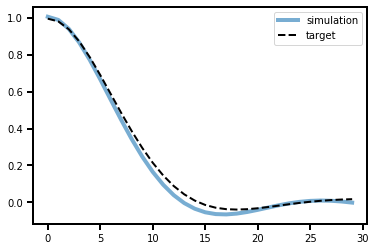

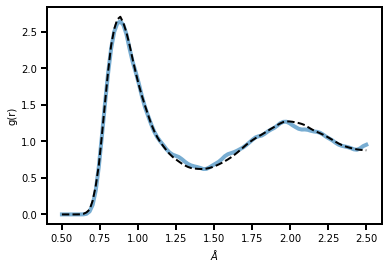

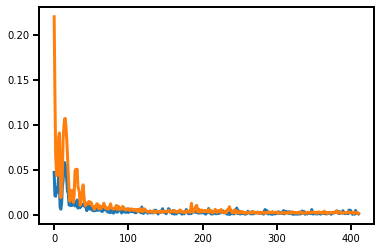

0.00030928474734537303 0.0019925273954868317
0.0005840923986397684 0.0015888209454715252
0.0004711113579105586 0.0017688402440398932
0.0021425187587738037 0.0017281767213717103
0.0020316969603300095 0.0027790074236691


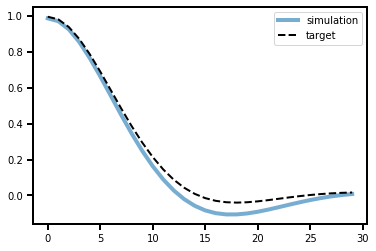

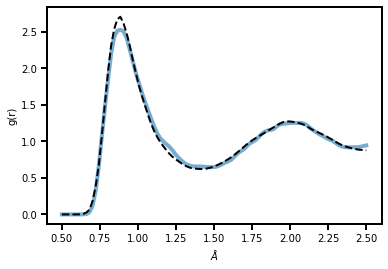

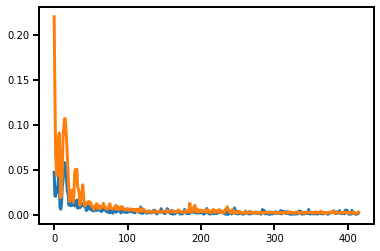

0.0027381000109016895 0.0016757999546825886
0.003571599954739213 0.0017320086481049657
0.001063878764398396 0.0022758841514587402
0.0015798883978277445 0.0036940642166882753
0.0005497424281202257 0.0029216394759714603


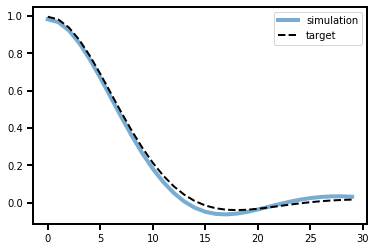

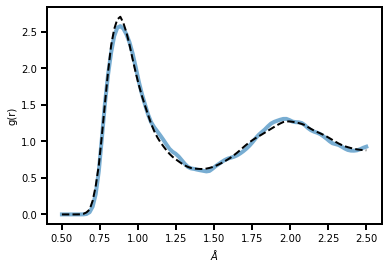

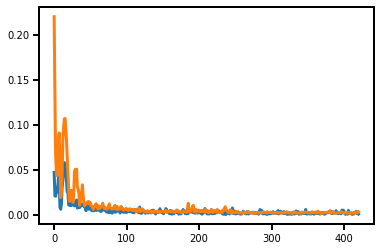

0.002121638972312212 0.0018844201695173979
0.0003896208363585174 0.0016829140949994326
0.0008779466734267771 0.0012907566269859672
0.003638866823166609 0.0017996698152273893
0.0020086923614144325 0.003307362785562873


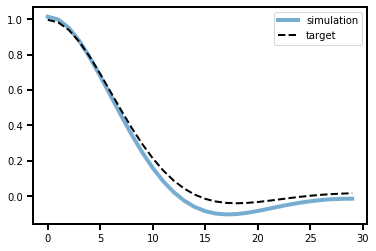

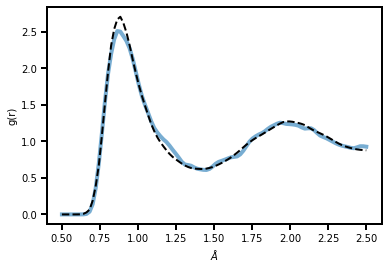

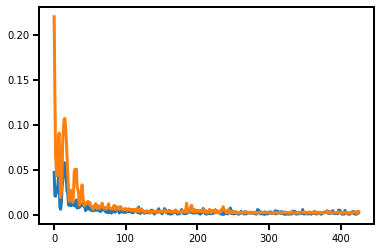

0.0034024990163743496 0.002411549910902977
0.0010041313944384456 0.0024441019631922245
0.0035722784232348204 0.0022633234038949013
0.003397664288058877 0.0023142406716942787
0.0012190177803859115 0.001969486940652132
Epoch   431: reducing learning rate of group 0 to 2.4414e-06.


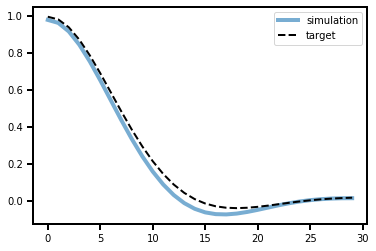

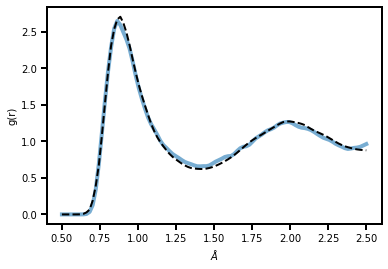

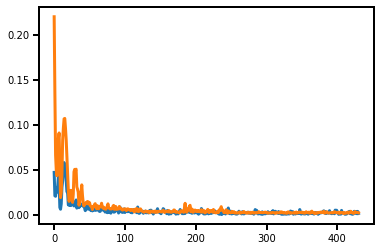

0.0018174286233261228 0.0018226003739982843
0.0013275040546432137 0.0022518348414450884
0.002304858062416315 0.0018222618382424116
0.0022028328385204077 0.002469413448125124
0.0016047008102759719 0.0019165066769346595


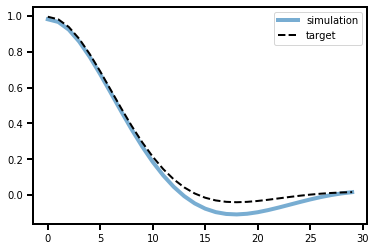

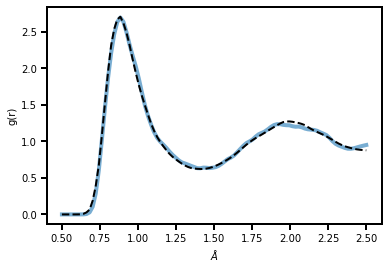

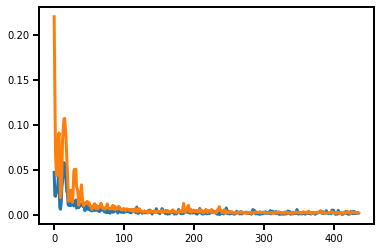

0.00185977085493505 0.001639009453356266
0.0029887554701417685 0.0023003530222922564
0.007396658416837454 0.0013946261024102569
0.0009142843191511929 0.0017954087816178799
0.001462216256186366 0.0017901279497891665


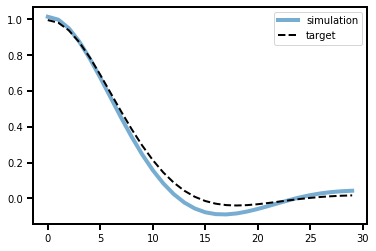

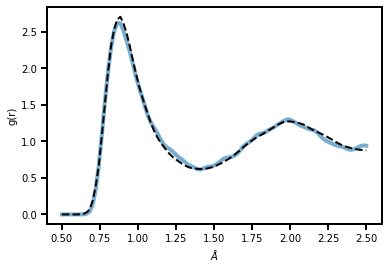

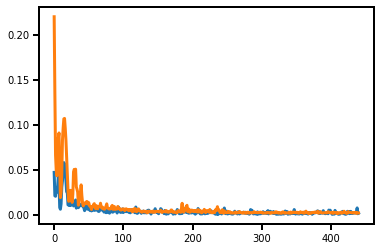

0.003624513978138566 0.0015037300763651729
0.007258870638906956 0.002322820480912924
0.004420281853526831 0.0049239108338952065
0.001065009506419301 0.002702996600419283
0.0026487018913030624 0.0017417857889086008


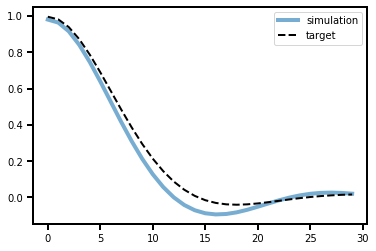

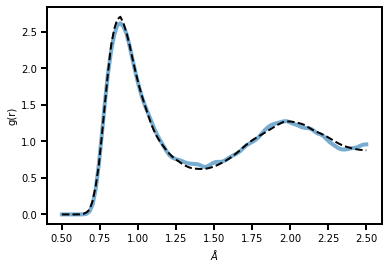

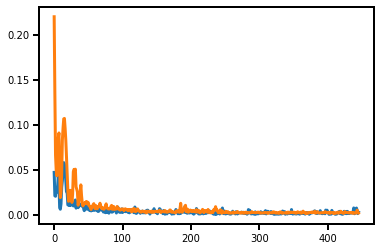

0.0006560917827300727 0.0017773546278476715
0.001715055899694562 0.002891545183956623
0.0031766712199896574 0.0021774740889668465
0.0005633182590827346 0.0016234414651989937
0.0007455273880623281 0.0015144811477512121


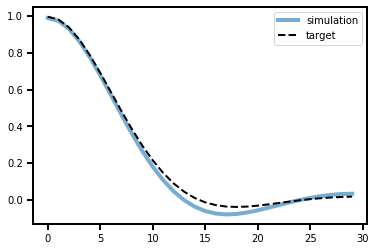

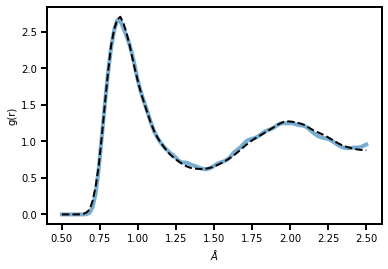

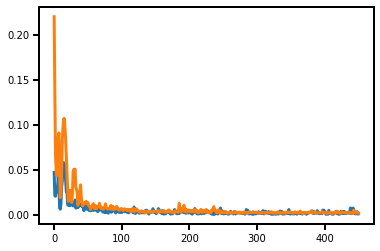

0.002189747989177704 0.0020889216102659702
Epoch   452: reducing learning rate of group 0 to 1.2207e-06.
0.00046103636850602925 0.0019246183801442385
0.001405252842232585 0.002890690928325057
0.0012086792849004269 0.0020263446494936943
0.002720808843150735 0.002005283022299409


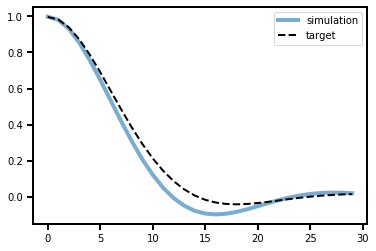

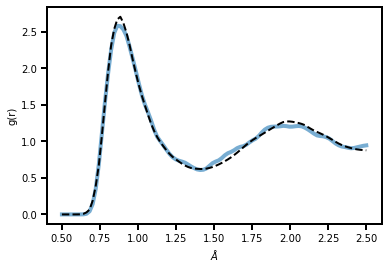

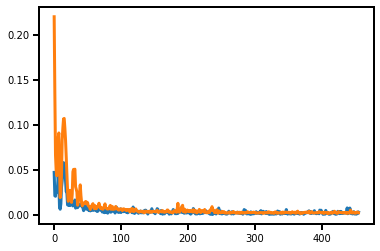

0.0030076028779149055 0.002087696921080351
0.0015522915637120605 0.0016814841656014323
0.001565819839015603 0.0016691810451447964
0.0007603835547342896 0.0028271395713090897
0.003983322065323591 0.0016038864850997925


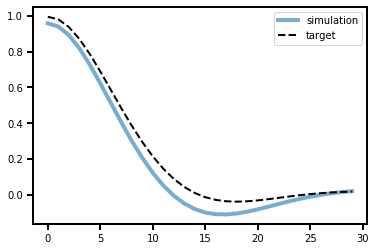

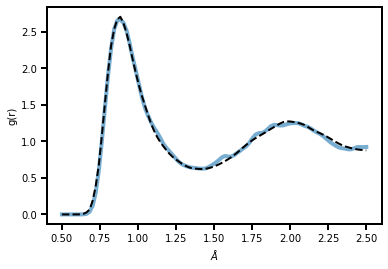

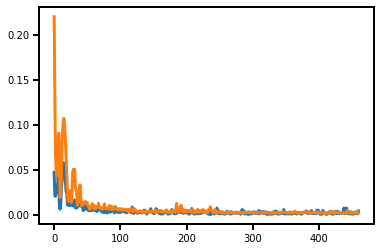

0.0030155316926538944 0.0021175076253712177
0.0029868034180253744 0.0018795955693349242
0.0008017460932023823 0.001968805445358157
0.0016377042047679424 0.0017355149611830711
0.00566529156640172 0.00225152843631804


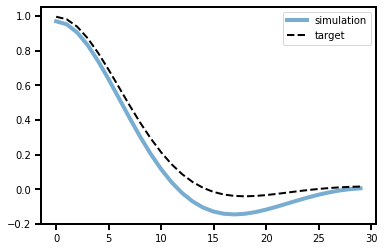

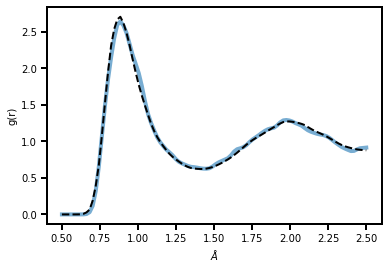

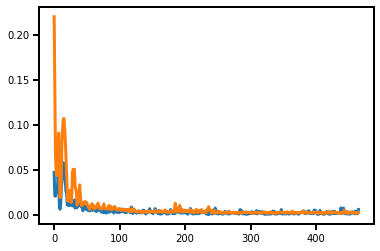

0.00127136567607522 0.0019396876450628042
0.00306570902466774 0.0028769206255674362
4.9455171392764896e-05 0.002087530680000782
0.002235230291262269 0.002644768450409174
0.0021352104377001524 0.0033591855317354202


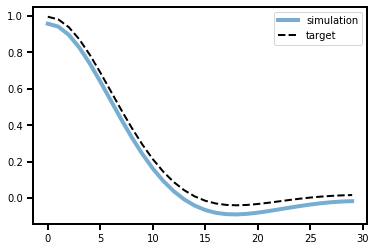

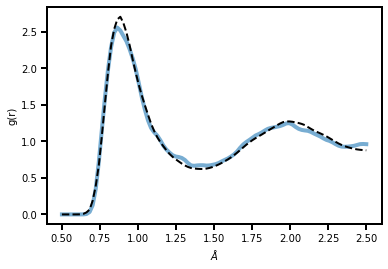

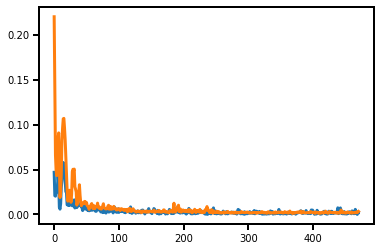

0.0019623187836259604 0.0033854462672024965
0.0006240532384254038 0.0019525892566889524
Epoch   473: reducing learning rate of group 0 to 6.1035e-07.
0.0012811323394998908 0.001748058246448636
0.001922721159644425 0.0029299624729901552
0.003524929052218795 0.0015295010525733232


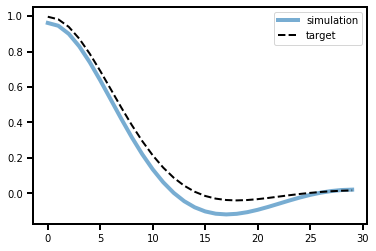

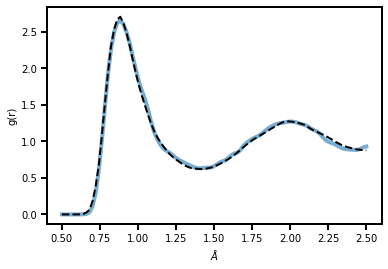

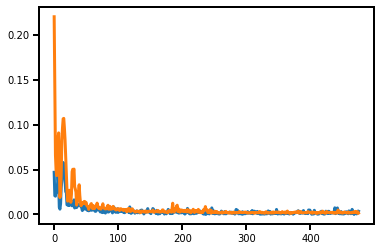

0.0005811710725538433 0.0024044106248766184
0.0012397575192153454 0.0024720849469304085
0.005827261134982109 0.00153538363520056
0.0038590156473219395 0.0022227957379072905
0.0008524045697413385 0.0025664079003036022


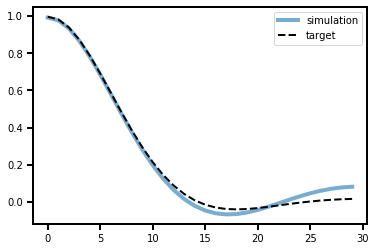

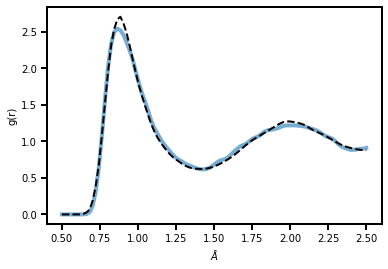

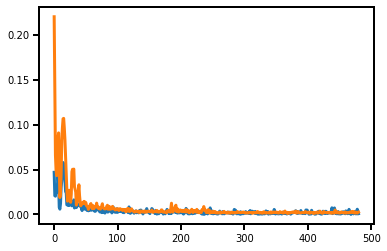

0.003385951044037938 0.0030414913780987263
0.0005736954626627266 0.001625989330932498
0.0016664396971464157 0.0019961518701165915
0.0021833963692188263 0.0023660599254071712
0.0019677276723086834 0.002980658784508705


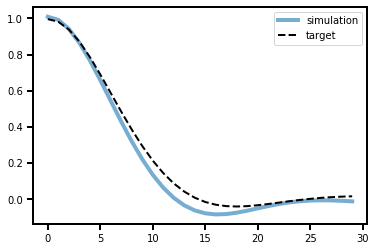

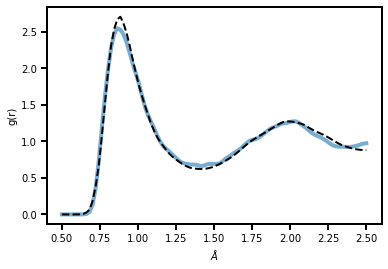

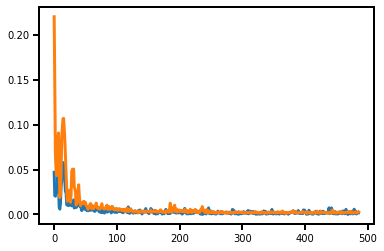

0.0014483107952401042 0.0019697980023920536
0.0020888319704681635 0.0024204435758292675
0.0013893281575292349 0.0020773205906152725
0.003405090421438217 0.0024448002222925425
0.004980367608368397 0.0016401914181187749


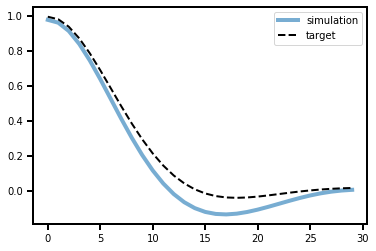

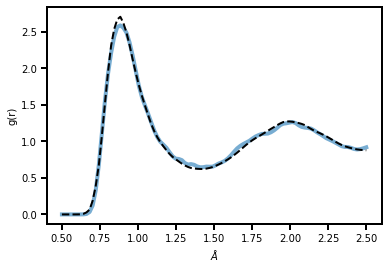

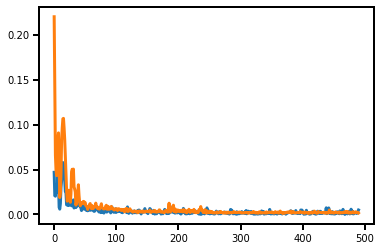

0.003989155869930983 0.002065438311547041
0.0016409261152148247 0.001552873756736517
0.0016646727453917265 0.0017919833771884441
Epoch   494: reducing learning rate of group 0 to 3.0518e-07.
0.0006320115062408149 0.0025190701708197594
0.0030719207134097815 0.0014865465927869081


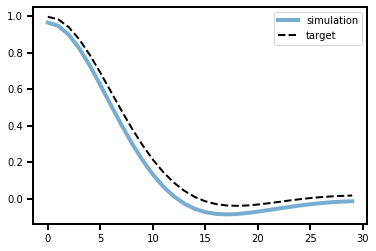

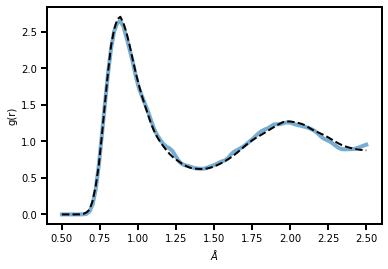

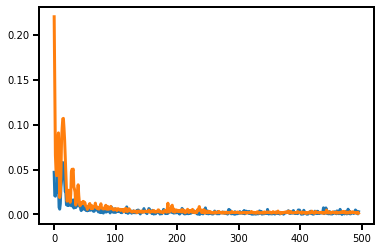

0.00038088037399575114 0.0024339030496776104
0.004354656673967838 0.0015189585974439979
0.002748805098235607 0.0024031889624893665
0.0016588906291872263 0.0018836675444617867
0.0013585109263658524 0.003138238098472357


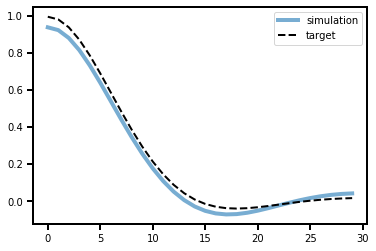

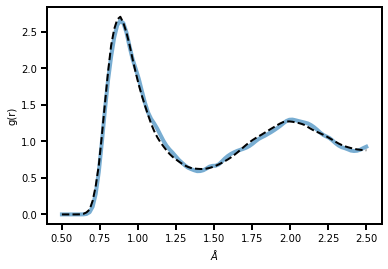

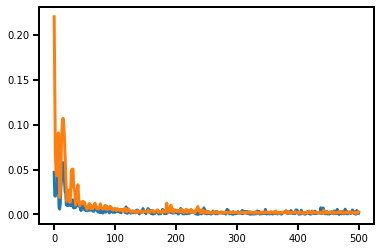

0.001141012879088521 0.0024824966676533222
0.0006682727835141122 0.0019041290506720543
0.00032130948966369033 0.0018823002465069294
0.0009727651486173272 0.0017438010545447469
0.001752507989294827 0.0022155167534947395


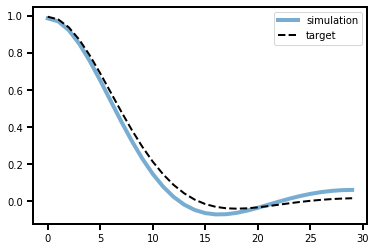

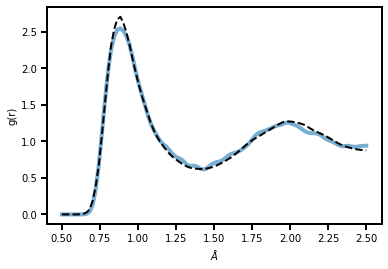

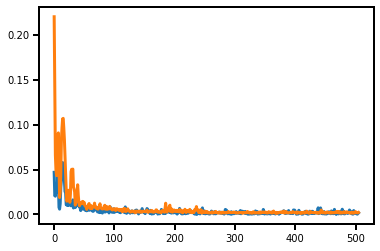

0.0006238382193259895 0.0018963773036375642
0.0022852958645671606 0.002188183832913637
0.0034975793678313494 0.0020455766934901476
0.0033273594453930855 0.0019091826397925615
0.0017909823218360543 0.0018732587341219187


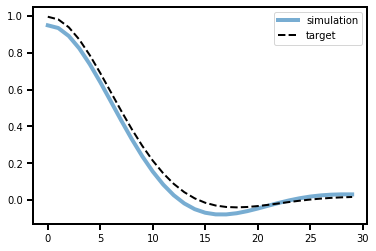

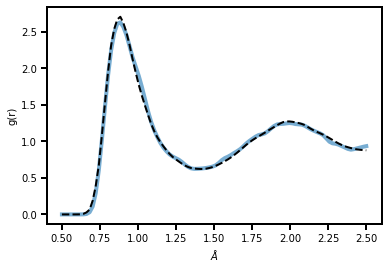

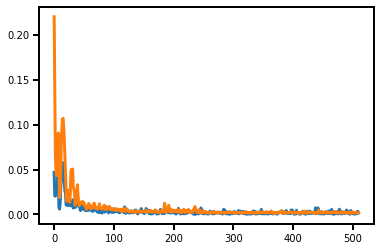

0.0012769859749823809 0.0023764045909047127
0.0032573738135397434 0.001927521312609315
0.003152902703732252 0.0014192827511578798
0.00111248844768852 0.003300862153992057
Epoch   515: reducing learning rate of group 0 to 1.5259e-07.
0.0008410685113631189 0.0017059105448424816


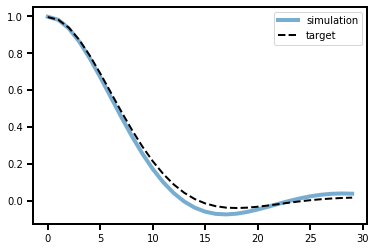

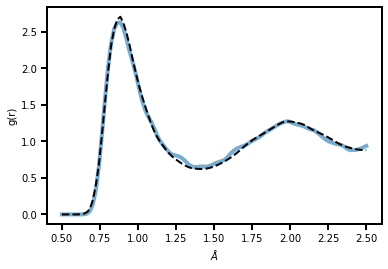

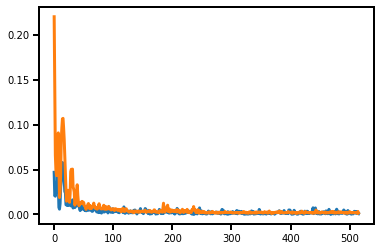

0.001001438475213945 0.0018291543237864971
0.0025385261978954077 0.002437528921291232
0.0011420022929087281 0.003191727679222822
0.004159360192716122 0.0018927797209471464
0.0016420435858890414 0.0025703860446810722


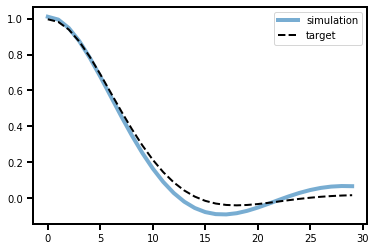

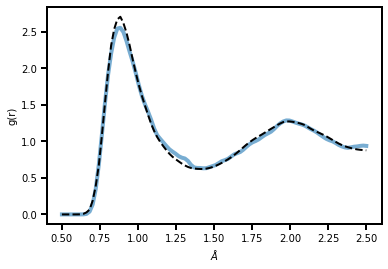

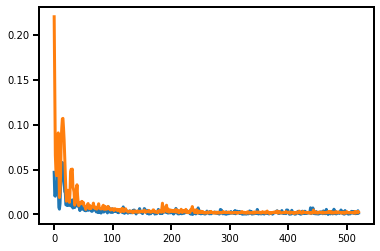

0.0023468565195798874 0.002209511585533619
0.0005561112193390727 0.0023233462125062943
0.0007538139470852911 0.0020029768347740173
0.0010625866707414389 0.0026743258349597454
0.0036379469092935324 0.0018804783467203379


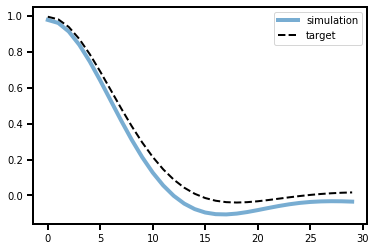

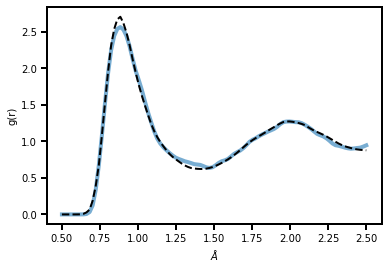

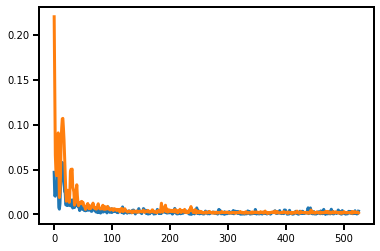

0.004680159036070108 0.0026955604553222656
0.0005794320604763925 0.0021085531916469336
0.0019017200684174895 0.0027026727329939604
0.001232916722074151 0.0016077726613730192
0.0015414805384352803 0.0025700395926833153


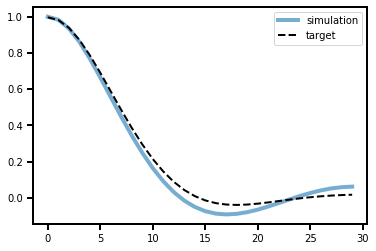

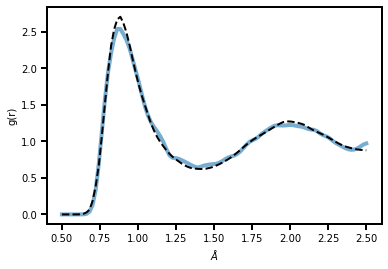

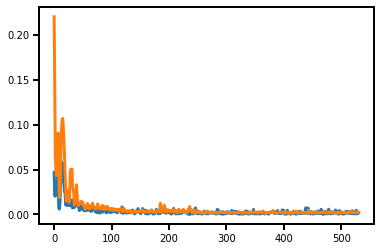

0.0017009542789310217 0.0015648170374333858
0.0021289496216923 0.004881519358605146
0.002562250243499875 0.0028474638238549232
0.0016627617878839374 0.0013797583524137735
0.002957588993012905 0.0015966873615980148
Epoch   536: reducing learning rate of group 0 to 7.6294e-08.


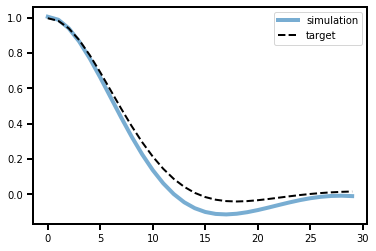

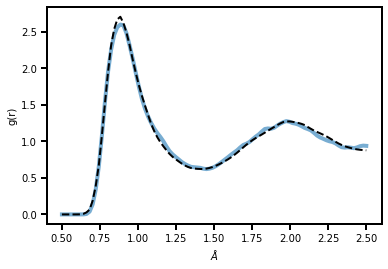

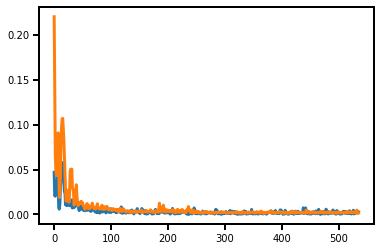

0.002581726061180234 0.001958646811544895
0.004027415998280048 0.0017479609232395887
0.0016233050264418125 0.0026170997880399227
0.004100044257938862 0.0019629118032753468
0.0031077766325324774 0.001972775673493743


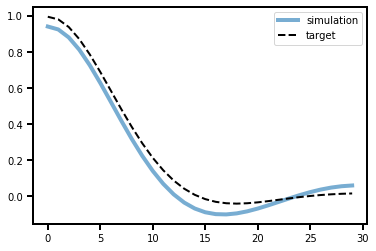

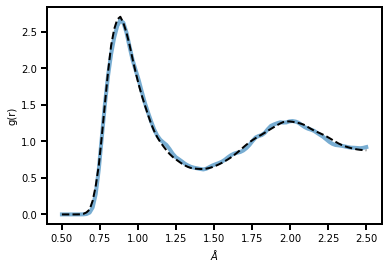

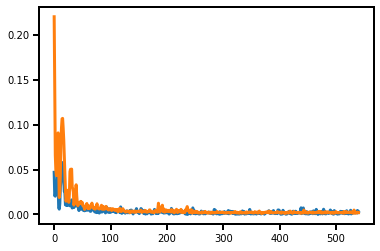

0.001558809308335185 0.002840419067069888
0.0014104119036346674 0.001870249747298658
0.0012769639724865556 0.0018939112778753042
0.0028990115970373154 0.0019387106876820326
0.0004720989381894469 0.001574608264490962


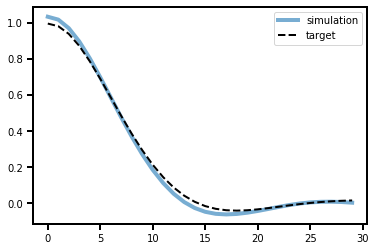

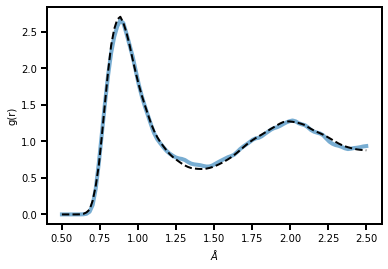

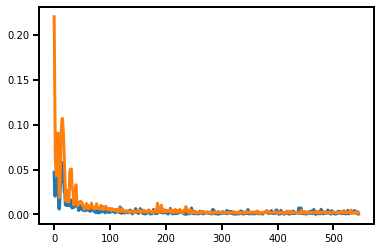

0.0008703831699676812 0.002881174674257636
0.0007064860546961427 0.0015541748143732548
0.0027999221347272396 0.0018749566515907645
0.0020313244313001633 0.0020797604229301214
0.0009480231092311442 0.0013122569071128964


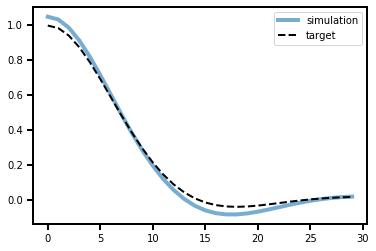

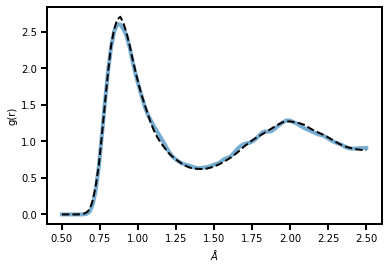

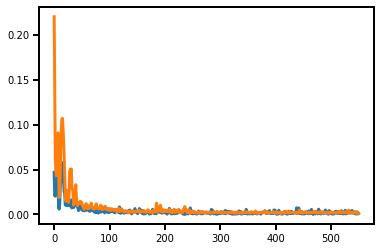

0.002185132820159197 0.0019913697615265846
0.0020227571949362755 0.0027023558504879475
0.0014684745110571384 0.0021281910594552755
0.0017311524134129286 0.003717968240380287
0.0021999236196279526 0.0036058942787349224


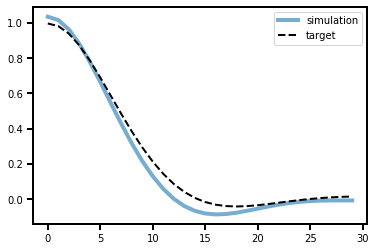

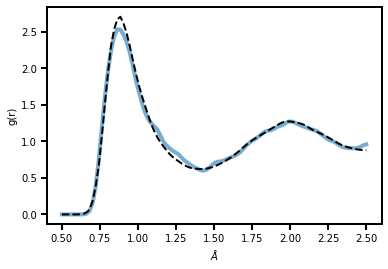

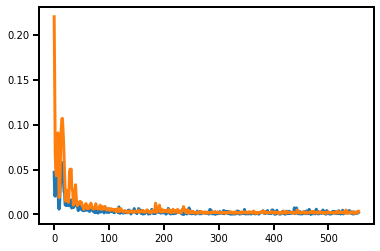

0.0021542187314480543 0.0021702514495700598
Epoch   557: reducing learning rate of group 0 to 3.8147e-08.
0.001547478954307735 0.0029982656706124544
0.0026248530484735966 0.003032668260857463
0.0023154050577431917 0.0022718035615980625
0.002527432283386588 0.001838085474446416


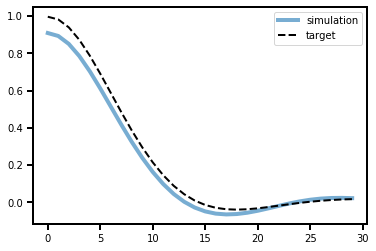

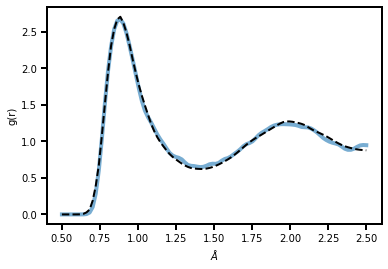

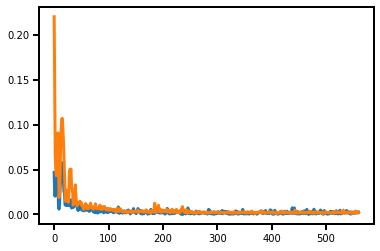

0.0014025162672623992 0.0015738140791654587
0.0018370014149695635 0.003868582658469677
0.004559225868433714 0.0015260456129908562
0.004281002562493086 0.0024064541794359684
0.001968491356819868 0.002764443401247263


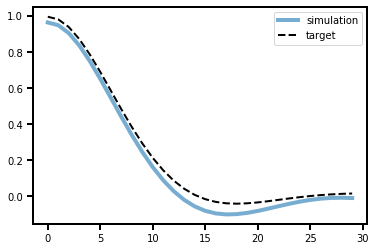

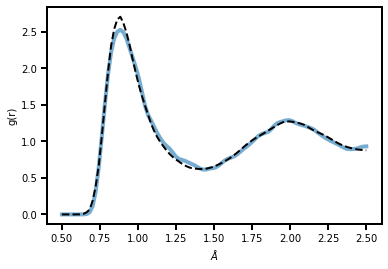

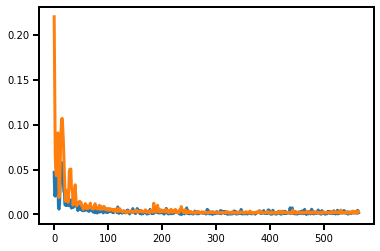

0.002105050953105092 0.0023029244039207697
0.0017402964876964688 0.002220448572188616
0.00219045695848763 0.002088941168040037
0.0009140819893218577 0.0026677099522203207
0.001869106199592352 0.0023580011911690235


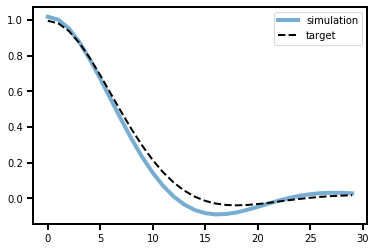

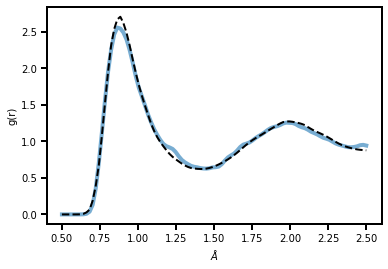

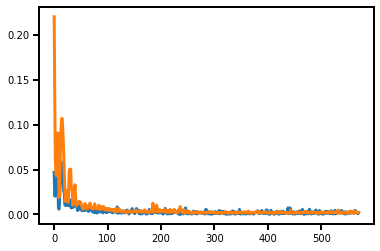

0.0014809668064117432 0.0021140016615390778
0.0003539499011822045 0.0013676496455445886
0.0006195213063620031 0.0017752660205587745
0.0035481846425682306 0.0023230223450809717
0.0017343732761219144 0.0021825202275067568


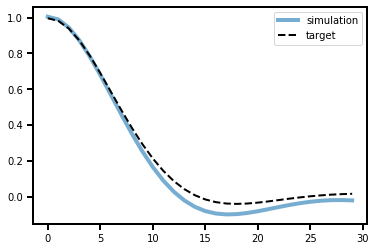

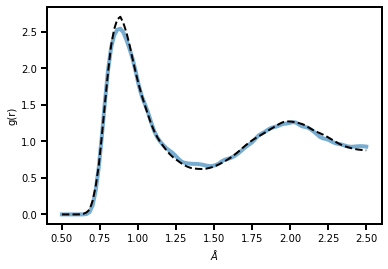

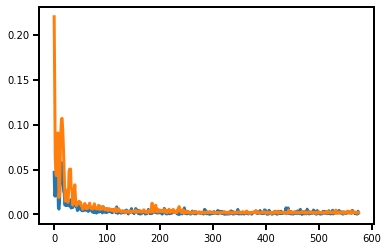

0.0054982732981443405 0.0014716817531734705
0.003051961539313197 0.0020916247740387917
0.001921564806252718 0.0032146875746548176
0.0019173631444573402 0.002825055969879031
0.0035383848007768393 0.001819065073505044


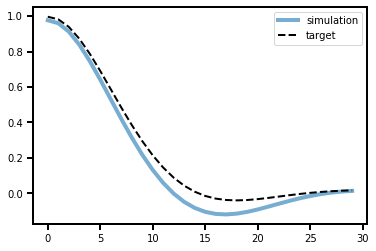

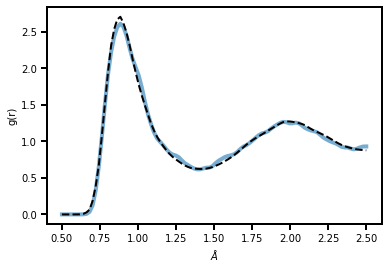

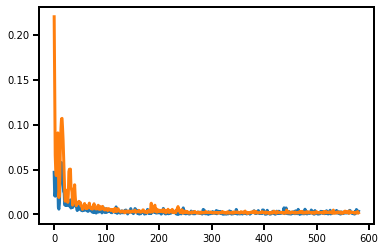

0.0012721131788566709 0.002788481768220663
0.0002581027802079916 0.0028888978995382786
0.0014384210808202624 0.0024681836366653442
0.0013838951708748937 0.0029135195072740316
0.0028152884915471077 0.0016553597524762154


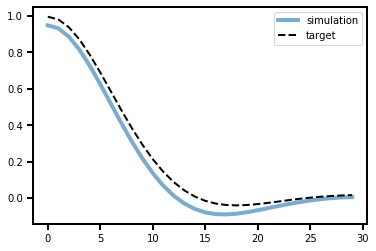

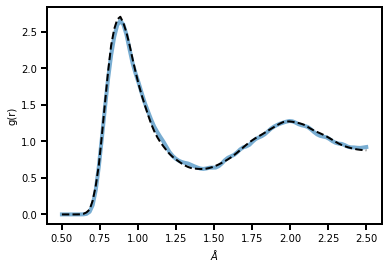

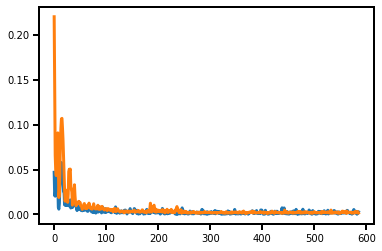

0.0033211559057235718 0.001690922537818551
0.003799592610448599 0.0033621888142079115
0.0019887809175997972 0.002185401041060686
0.0023340003099292517 0.002218975918367505
0.0022283042781054974 0.0021331231109797955


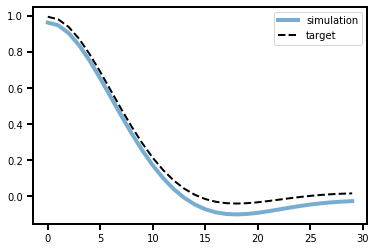

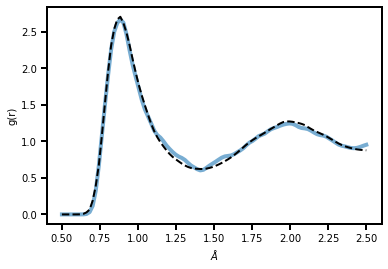

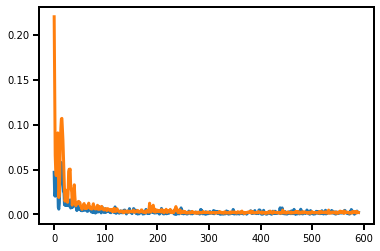

0.00018408063624519855 0.0022080198395997286
0.0038110376335680485 0.0044767167419195175
0.0012324658455327153 0.0017597773112356663
Epoch   594: reducing learning rate of group 0 to 1.9073e-08.
0.002078505465760827 0.0016198426019400358
0.0020295765716582537 0.0028691634070128202


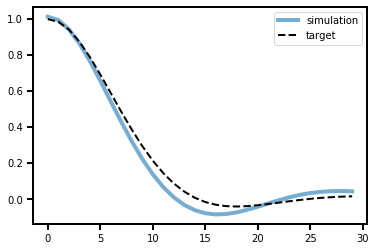

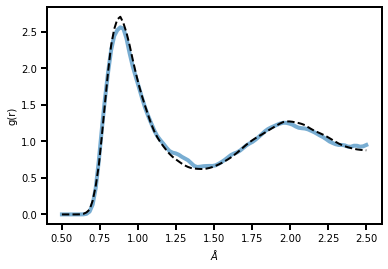

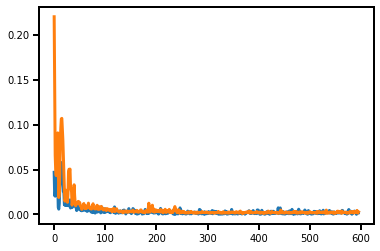

0.00037196886842139065 0.001965816132724285
0.0009867461631074548 0.001401753630489111
0.0006972500705160201 0.0017631337977945805
0.0013049623230472207 0.0021030150819569826
0.0038137587253004313 0.0018676039762794971


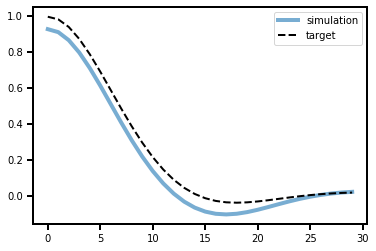

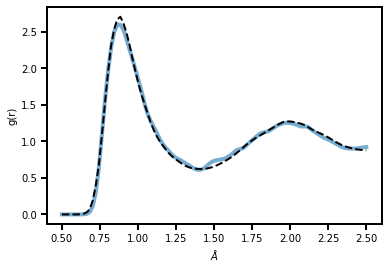

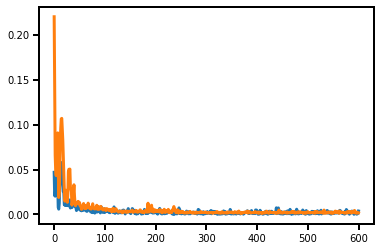

0.0008039291715249419 0.0018697456689551473
0.002601868938654661 0.0014527786988765001
0.0043664309196174145 0.0020300159230828285
0.0009989694226533175 0.003523407503962517
0.0017051735194399953 0.0022523945663124323


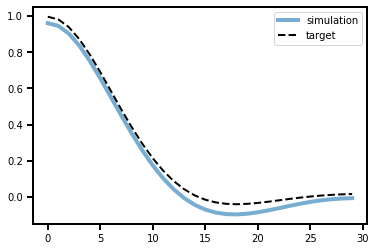

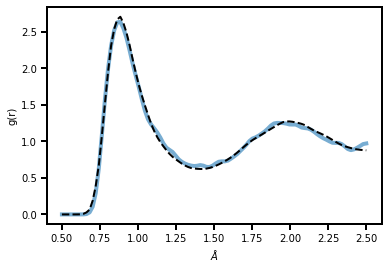

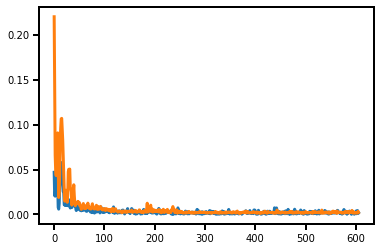

0.0007083222735673189 0.0019163754768669605
0.0005881196120753884 0.0022467211820185184
0.001256840187124908 0.0021317806094884872
0.0022309073247015476 0.00319528765976429
0.003700599540024996 0.0031382485758513212


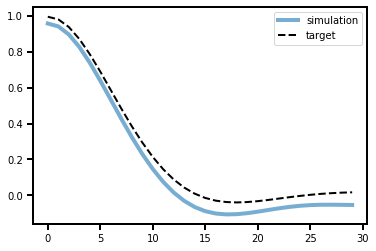

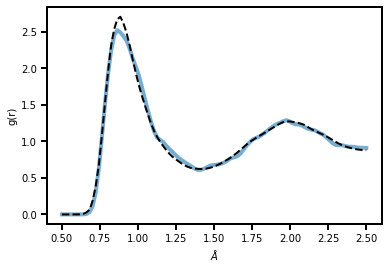

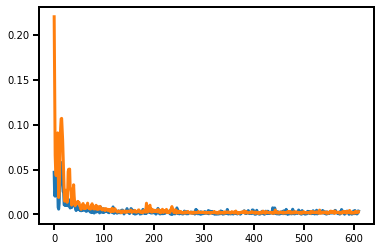

0.003343008691444993 0.0025192215107381344
0.003927656915038824 0.002668661531060934
0.0032760545145720243 0.001579288742505014
0.0014034900814294815 0.0016086958348751068
0.001298501156270504 0.0033154026605188847


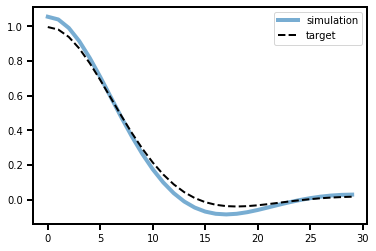

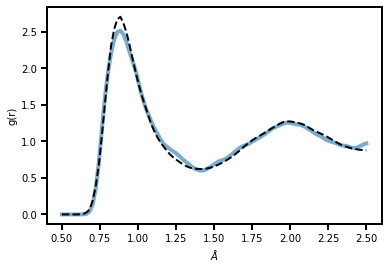

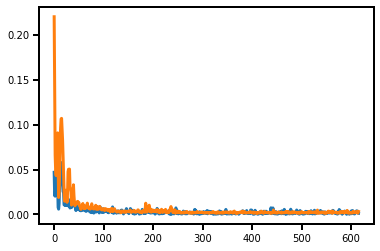

0.0010791260283440351 0.002699487842619419
0.0017504257848486304 0.0018244972452521324
0.006878488697111607 0.0018743431428447366
0.001618392881937325 0.0022800408769398928
0.004065190441906452 0.0021530527155846357


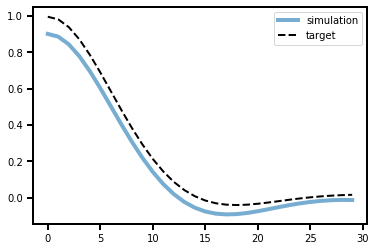

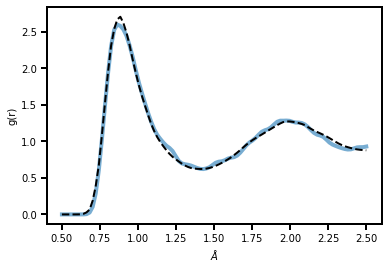

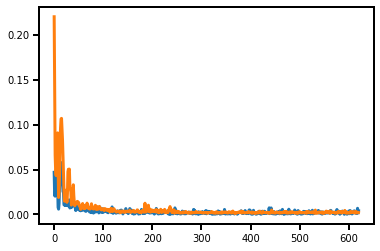

0.001593439606949687 0.0015716602792963386
0.0005056484951637685 0.0018796855583786964
0.0021050928626209497 0.0019519866909831762
0.0007884789956733584 0.002824793104082346
0.0009128465899266303 0.0017145359888672829


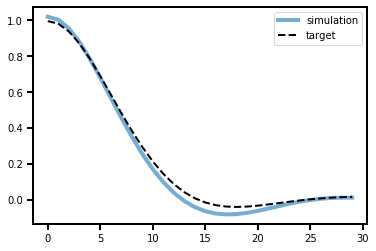

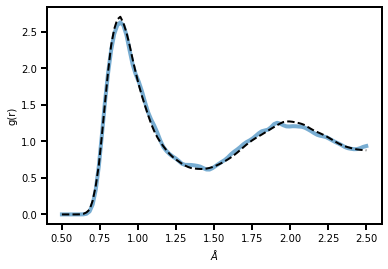

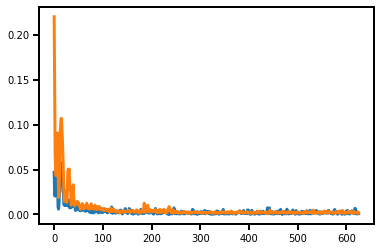

0.0010542420204728842 0.002156010363250971
0.002462641568854451 0.001612087246030569
0.0014848366845399141 0.0021294988691806793
0.001918484573252499 0.002099856734275818
0.0010318889981135726 0.003675253828987479


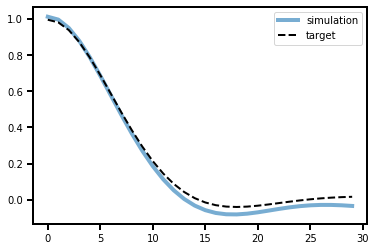

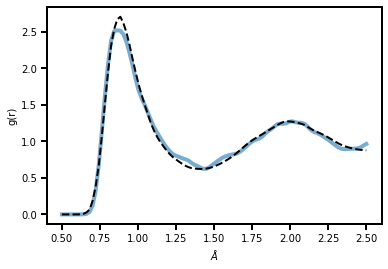

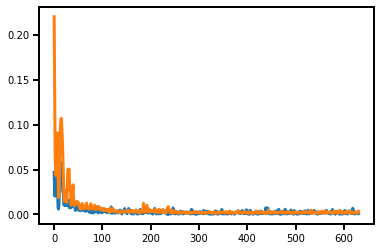

0.0007202265551313758 0.0019002067856490612
0.0019707917235791683 0.0034089470282197
0.004160262644290924 0.0020780067425221205
0.0024932485539466143 0.001520640915259719
0.003627836238592863 0.0024715126492083073


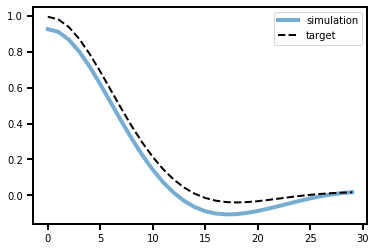

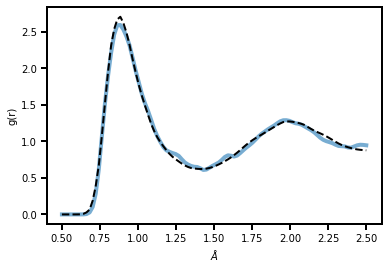

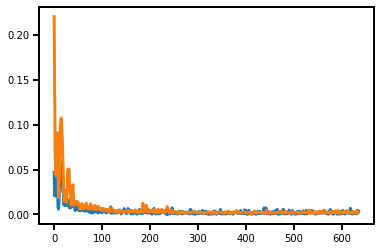

0.0033634426072239876 0.002308653434738517
0.0008271306287497282 0.001608874648809433
0.0013375100679695606 0.0023920261301100254
0.0020569467451423407 0.0016519749769940972
0.002164594829082489 0.00119555345736444


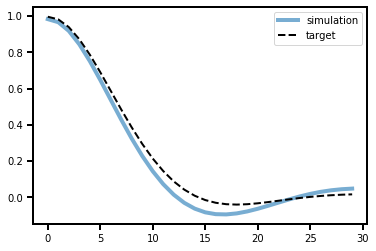

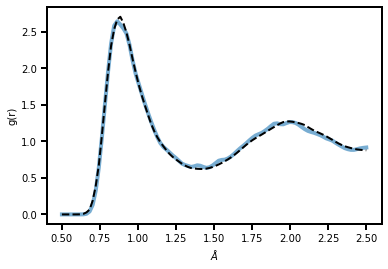

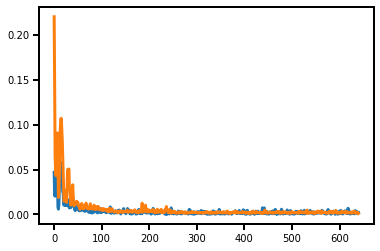

0.0011985101737082005 0.0020545285660773516
0.0020851686131209135 0.0026819207705557346
0.0015346996951848269 0.0018826766172423959
0.0028384143952280283 0.002948640612885356
0.0012905653566122055 0.0019364816835150123


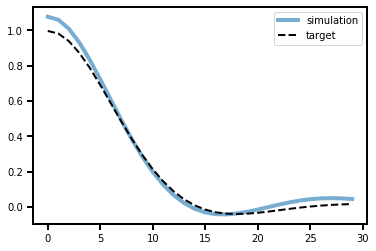

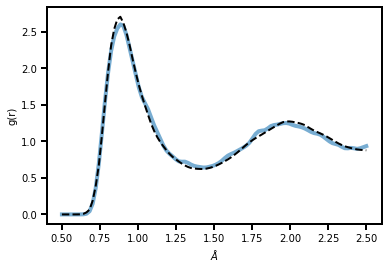

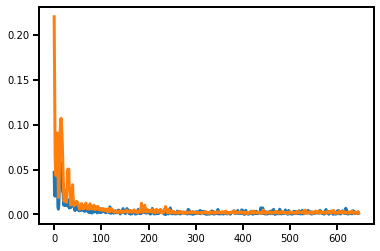

0.0009438628912903368 0.001676514046266675
0.0006535711581818759 0.002476191846653819
0.001412769895978272 0.0018721605883911252
0.004402562044560909 0.0026877985801547766
0.0013263978762552142 0.0016766786575317383


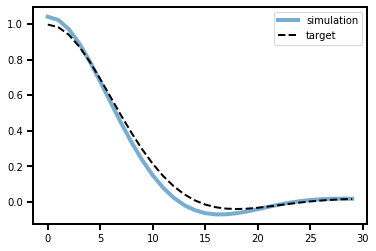

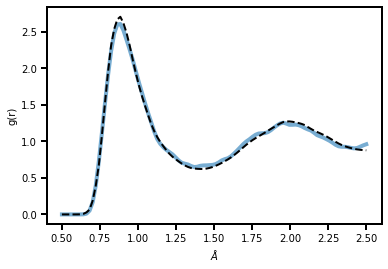

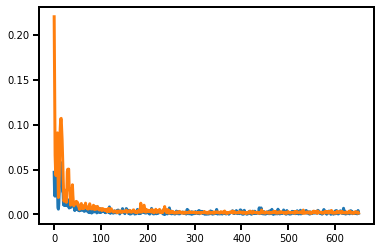

0.003820963203907013 0.0032465197145938873
0.0015173947904258966 0.002129260916262865
0.004079355392605066 0.002522263443097472
0.00642003770917654 0.002385915257036686
0.0012435142416507006 0.0015147593803703785


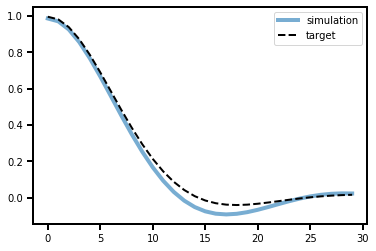

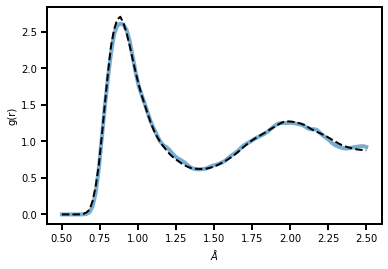

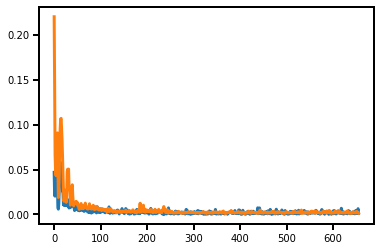

0.0013400374446064234 0.0018931272206827998
0.003770560258999467 0.0022574258036911488
0.006309903226792812 0.0023397915065288544
0.0011097702663391829 0.0018742503598332405
0.0007936981855891645 0.001349440193735063


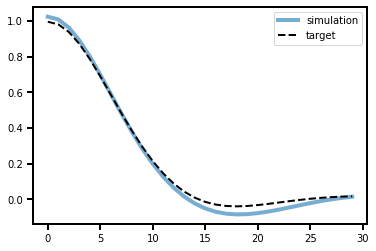

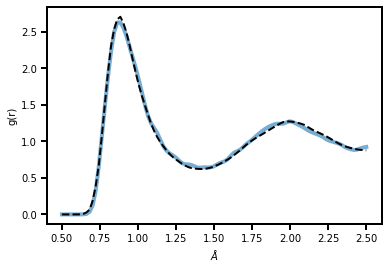

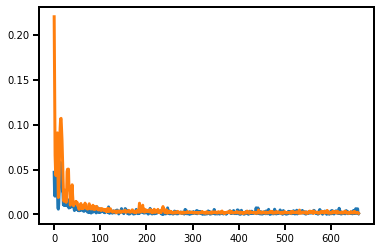

0.003110910765826702 0.0017747549572959542
0.0013695452362298965 0.0016691922210156918
0.0021886189933866262 0.0019245463190600276
0.0010243289871141315 0.001579849049448967
0.0006253077881410718 0.00204885913990438


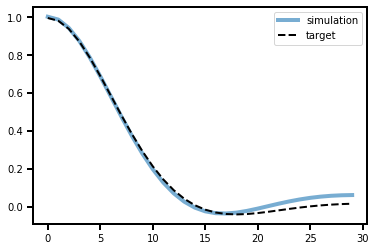

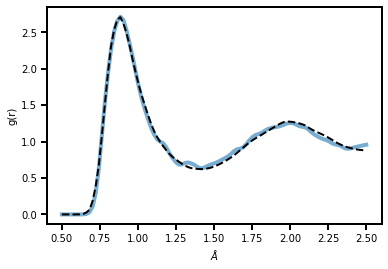

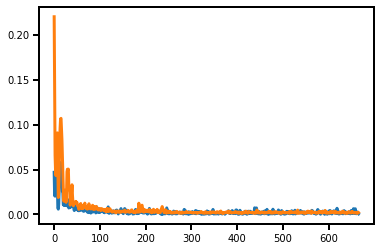

0.0005479372921399772 0.002664891304448247
0.0035644543822854757 0.0016691985074430704
0.00035897266934625804 0.001792512251995504
0.0013416652800515294 0.0018626800738275051
0.0024893772788345814 0.0015420455019921064


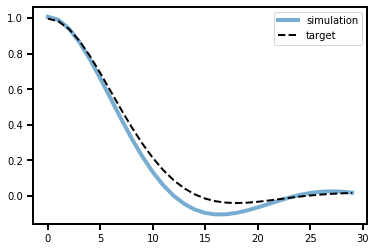

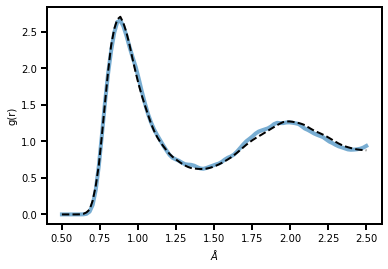

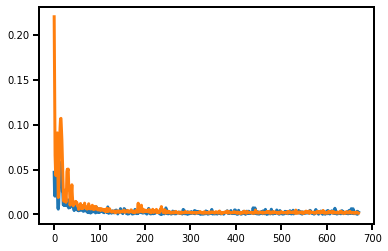

0.001493889489211142 0.004270006436854601
0.003962444141507149 0.0017641502199694514
0.0005848395521752536 0.0018751873867586255
0.002586818765848875 0.0021505330223590136
0.004020976833999157 0.003482381347566843


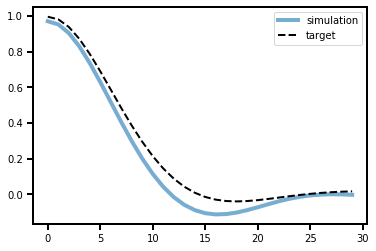

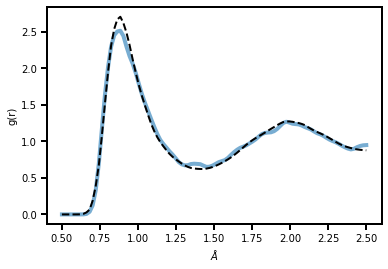

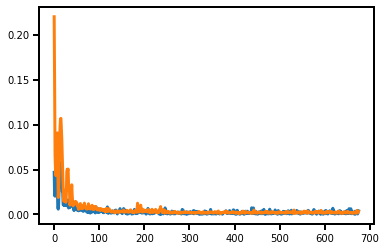

0.0007517766207456589 0.001703360816463828
0.0009924492333084345 0.002307185670360923
0.0006698689539916813 0.002154022455215454
0.000502256618347019 0.0021074903197586536
0.002137464703992009 0.0014888820005580783


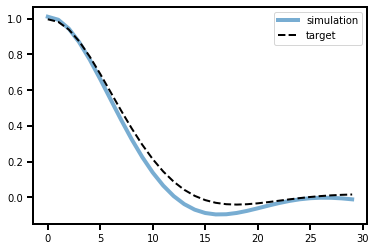

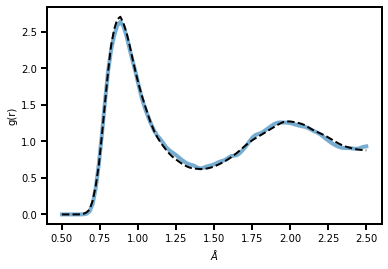

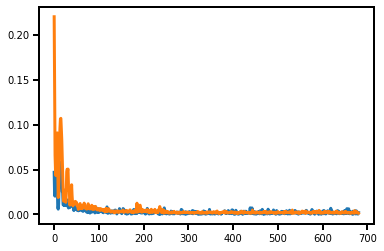

0.0017891115276142955 0.0019119996577501297
0.0009161197813227773 0.001751134404912591
0.0016129835275933146 0.0017805933021008968
0.0020134206861257553 0.0023935437202453613
0.0015703171957284212 0.0028887370135635138


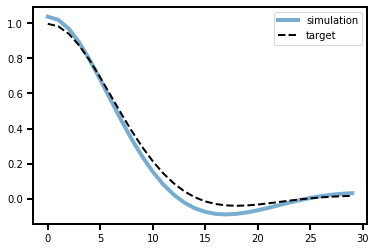

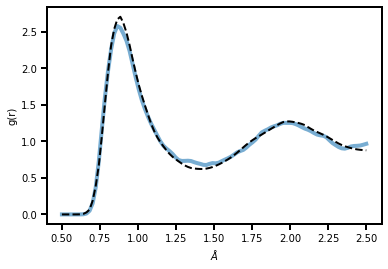

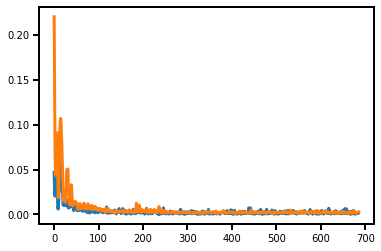

0.002178229158744216 0.0025859507732093334
0.0016464459476992488 0.0018796981312334538
0.002550841076299548 0.003363036084920168
0.0011173306265845895 0.002194437198340893
0.0013261019485071301 0.0020158232655376196


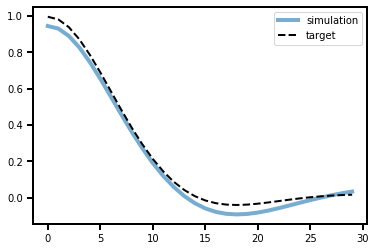

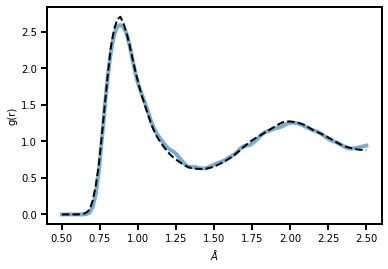

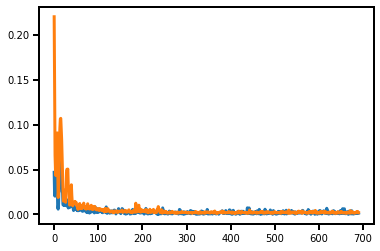

0.0006667985580861568 0.0026640803553164005
0.0029782529454678297 0.0023147540632635355
0.004601073917001486 0.0013623943086713552
0.0006511560641229153 0.00279060541652143
0.004252392333000898 0.001800876809284091


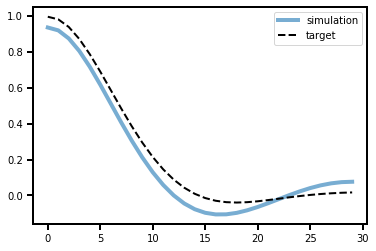

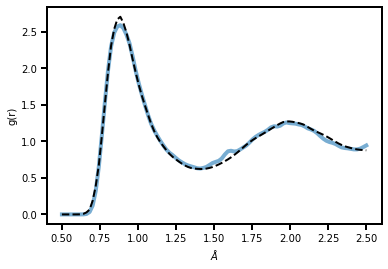

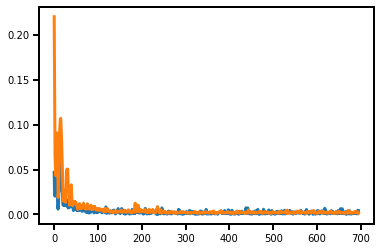

0.0009854944655671716 0.0015145079232752323
0.0008610509685240686 0.002415069378912449
0.0026419656351208687 0.0019095523748546839
0.0007157900836318731 0.001652431208640337
0.0007031650166027248 0.0017397936899214983


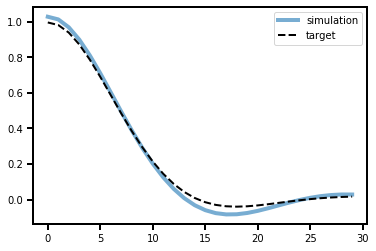

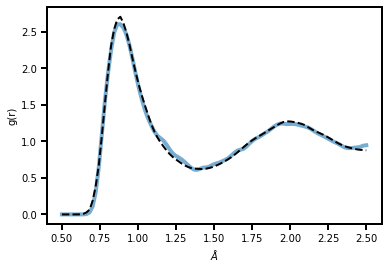

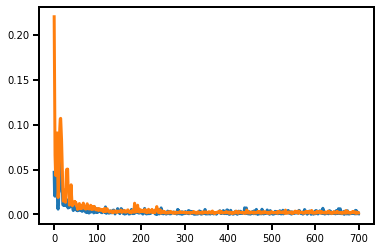

0.0026816308964043856 0.00214584032073617
0.0005145492614246905 0.0017535688821226358
0.0008463129051961005 0.0023140334524214268
0.0006992935086600482 0.002455489244312048
0.0007095523760654032 0.00223749247379601


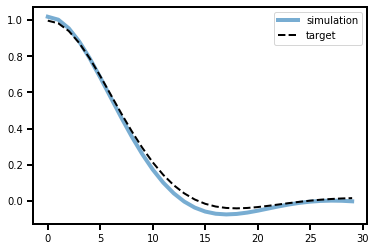

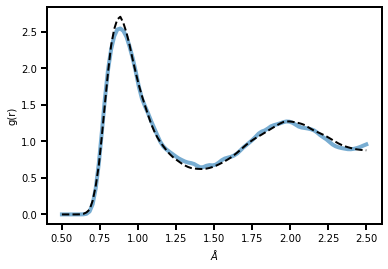

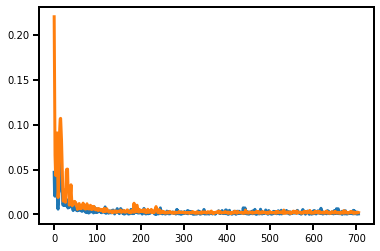

0.0012596538290381432 0.0019100869540125132
0.0030055830720812082 0.0027817944064736366
0.0007111392333172262 0.0016252384521067142
0.003336307592689991 0.002125886967405677
0.0016416965518146753 0.0013223320711404085


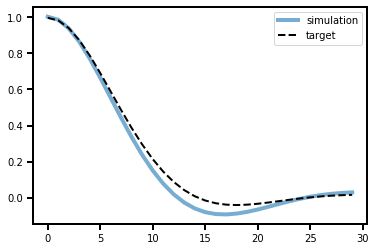

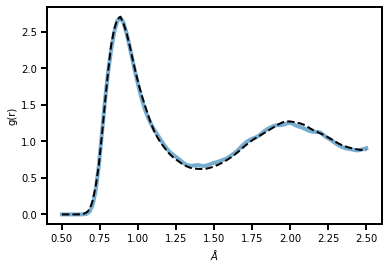

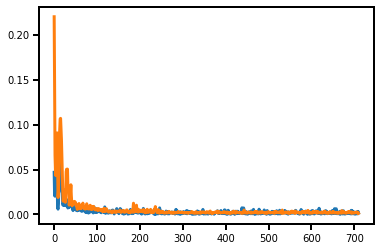

0.0017757606692612171 0.0015856495592743158
0.0032213525846600533 0.0030739419162273407
0.0028445161879062653 0.0023164856247603893
0.0009495033882558346 0.0019530243007466197
0.0023848984856158495 0.002065605018287897


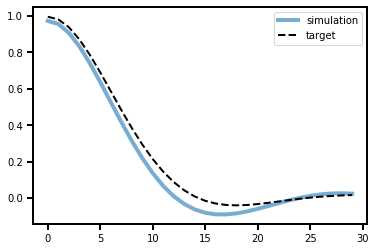

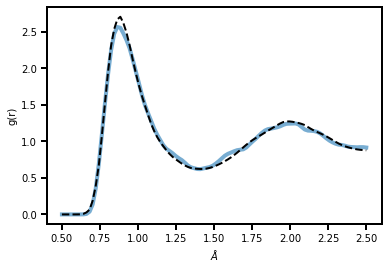

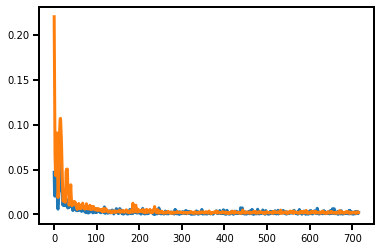

0.003018168732523918 0.0016269151819869876
0.0048650880344212055 0.0031220766250044107
0.003626462072134018 0.001216322067193687
0.0006677240016870201 0.0027687912806868553
0.001730361138470471 0.0029750450048595667


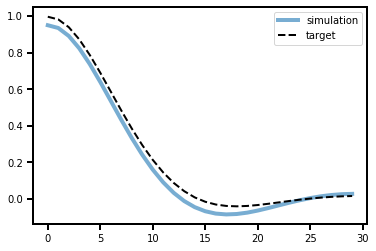

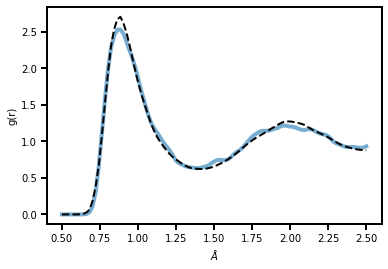

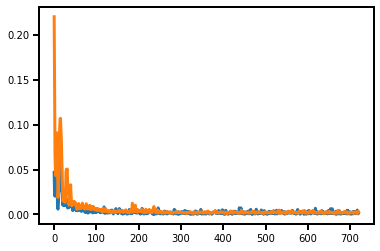

0.002548311371356249 0.00250182393938303
0.002394112991169095 0.002051995135843754
0.005398995243012905 0.002156941220164299
0.0015038260025903583 0.0020064429845660925
0.0005200176383368671 0.0020181620493531227


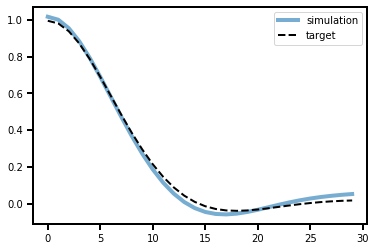

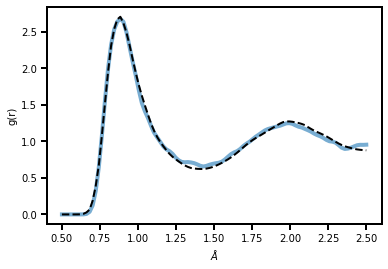

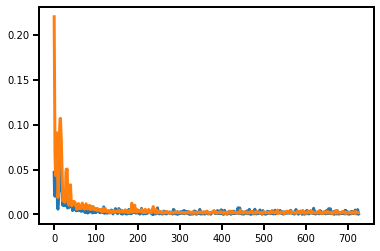

0.0013179881498217583 0.0017815949395298958
0.004081789869815111 0.0012483171885833144
0.003613263601437211 0.0029326919466257095
0.0012683611130341887 0.002482313197106123
0.0003905298071913421 0.0018972230609506369


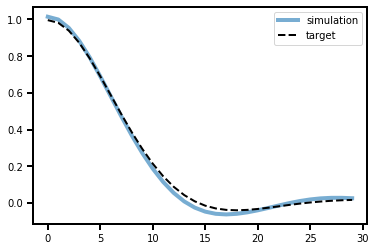

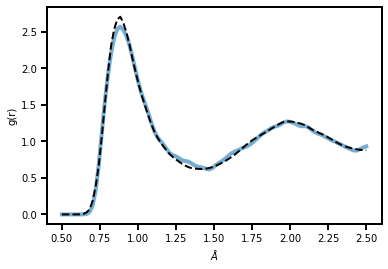

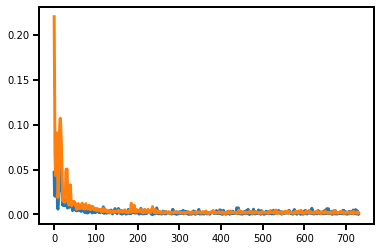

0.0007529840222559869 0.0019046771340072155
0.004172040149569511 0.0016101875808089972
0.0009527698857709765 0.0022115129977464676
0.0029166864696890116 0.0024726237170398235
0.002492107916623354 0.001709585776552558


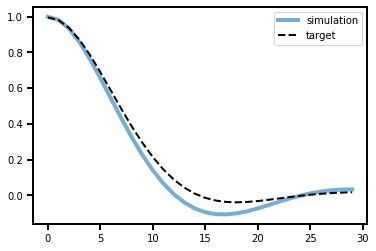

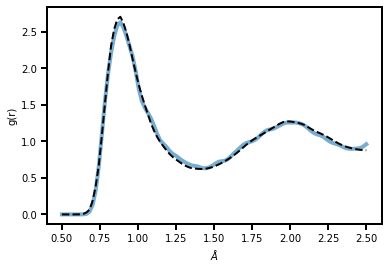

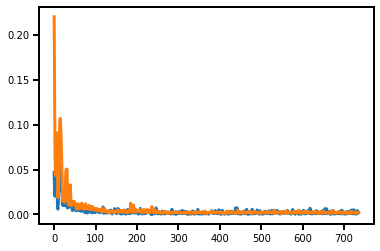

0.0017209344077855349 0.001676858402788639
0.000490357109811157 0.0014645725023001432
0.0033576665446162224 0.0018573520937934518
0.0018818433163687587 0.0033424238208681345
0.0029421949293464422 0.002014605328440666


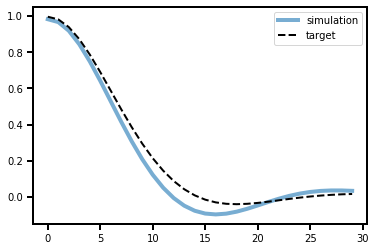

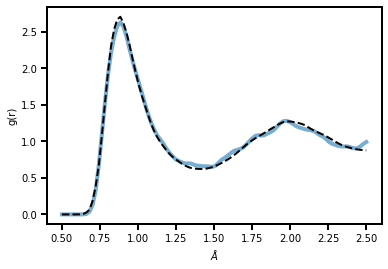

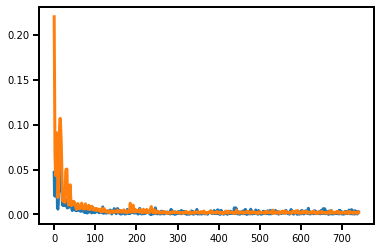

0.002466228324919939 0.0022673201747238636
0.0016751964576542377 0.0016872204141691327
0.0004555937193799764 0.0016210003523156047
0.0024510687217116356 0.0014000852825120091
0.0018482255982235074 0.0029216676484793425


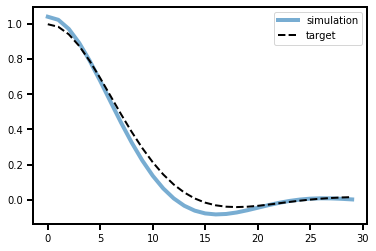

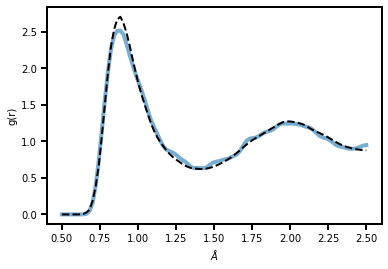

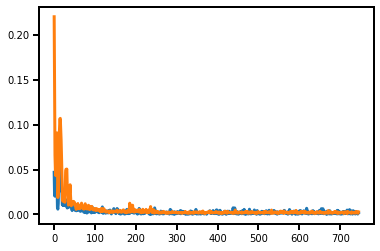

0.0007164681446738541 0.0025578190106898546
0.0030790797900408506 0.002082377439364791
0.0019215561915189028 0.0025525225792080164
0.00259760906919837 0.0021054744720458984
0.0014422264648601413 0.002106309635564685


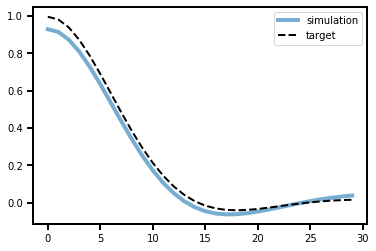

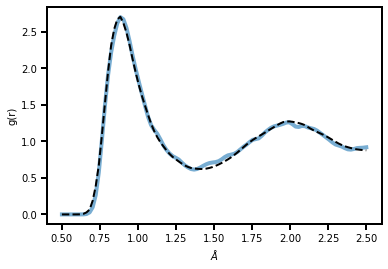

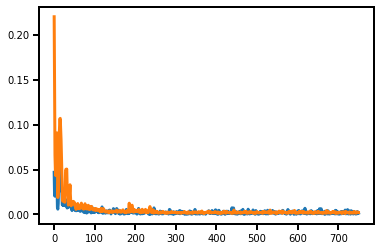

0.0007465856615453959 0.0023854447063058615
0.0002372647577431053 0.0023762318305671215
0.0015203554648905993 0.0023219059221446514
0.0030611406546086073 0.0025296472012996674
0.0003577416355255991 0.0015735498163849115


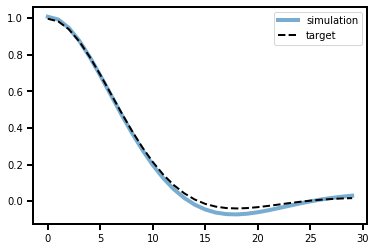

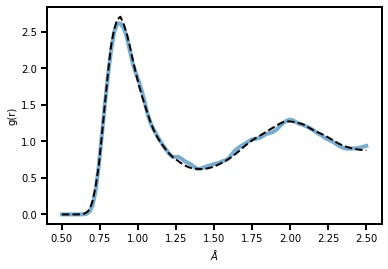

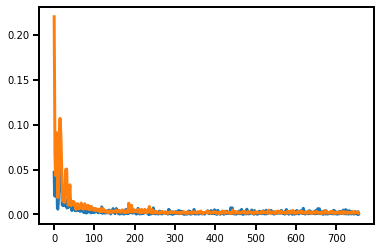

0.0005870272289030254 0.0016522171208634973
0.0016185170970857143 0.0016113256569951773
0.0017614802345633507 0.0017373338341712952
0.0014179490972310305 0.002572225173935294
0.0021737960632890463 0.00263965199701488


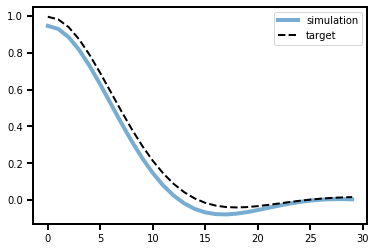

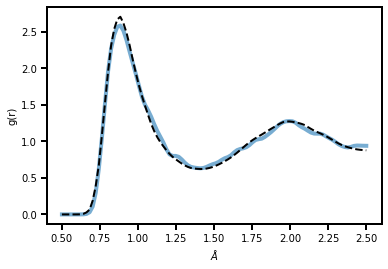

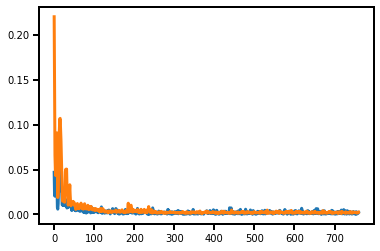

0.0027921111322939396 0.0018352376064285636
0.004298408981412649 0.0017511032056063414
0.0048652105033397675 0.0017816873732954264
0.003457237035036087 0.0029081888496875763
0.00017145917809102684 0.002336554229259491


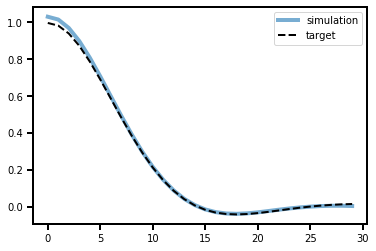

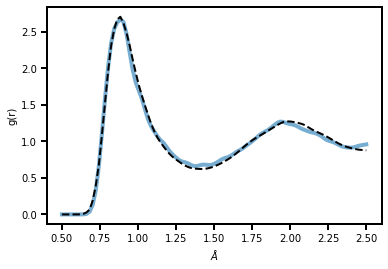

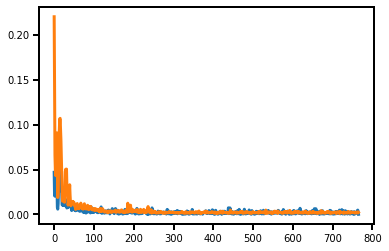

0.0017159455455839634 0.0013424860080704093
0.0006875863764435053 0.0025043683126568794
0.0013369604712352157 0.0039185043424367905
0.002076384611427784 0.0015386731829494238
0.0007111778249964118 0.0017628781497478485


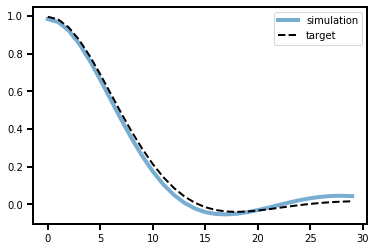

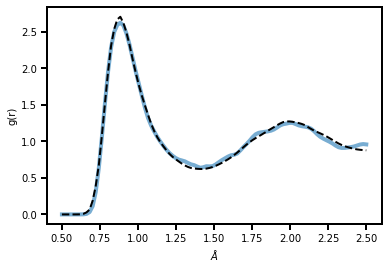

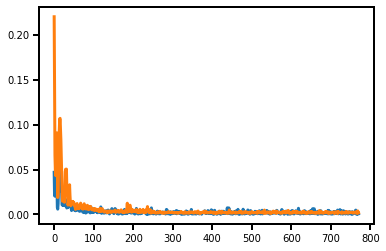

0.0018855731468647718 0.0022671164479106665
0.0019542023073881865 0.002933636773377657
0.0011751349084079266 0.00188961043022573
0.0038113391492515802 0.002351901028305292
0.00113503891043365 0.002137918956577778


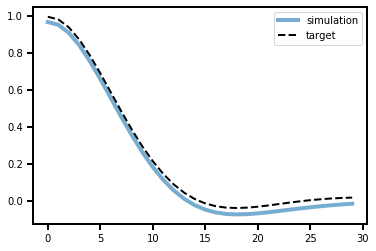

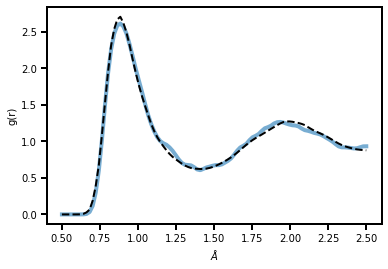

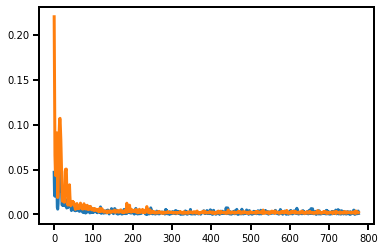

0.006429534871131182 0.002134535228833556
0.0003360903065185994 0.0013713324442505836
0.0031463627237826586 0.0015841926215216517
0.0017707596998661757 0.0021916439291089773
0.0004204857687000185 0.003028940875083208


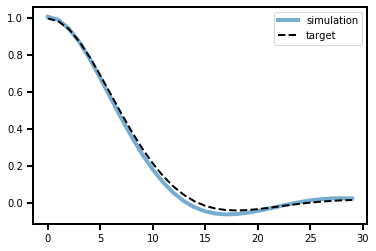

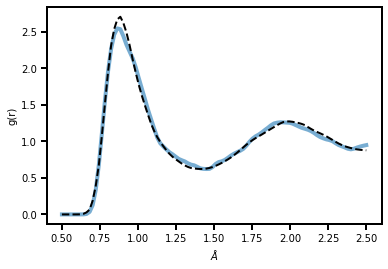

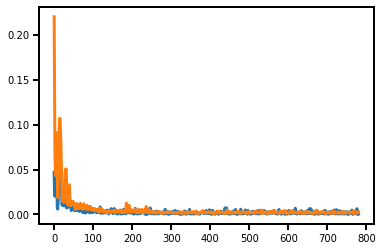

0.0012912086676806211 0.00196677353233099
0.0006352940108627081 0.0028051810804754496
0.0017560903215780854 0.002685932908207178
0.0022055774461477995 0.003083842806518078
0.0006238954374566674 0.0015883093001320958


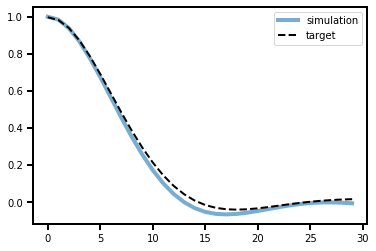

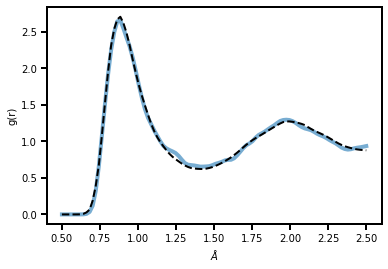

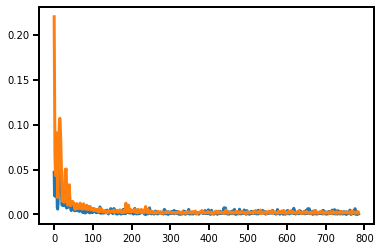

0.003580691060051322 0.0020177641417831182
0.0009320952231064439 0.0015117257134988904
0.0028910760302096605 0.002843682188540697
0.00047463172813877463 0.001777673838660121
0.002016392070800066 0.0019179757218807936


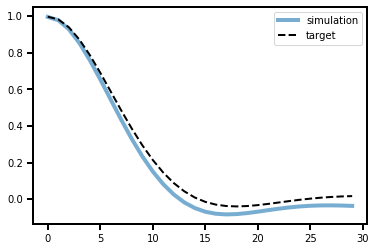

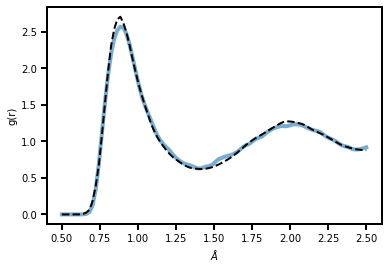

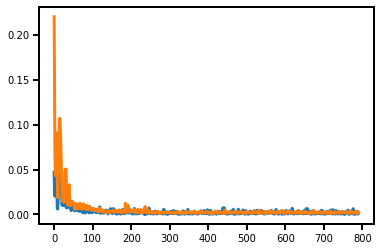

0.0031803003512322903 0.0026818362530320883
0.0007115249172784388 0.0018494253745302558
0.003038376336917281 0.0018120906315743923
0.00435316376388073 0.002255829982459545
0.0023210113868117332 0.0021788235753774643


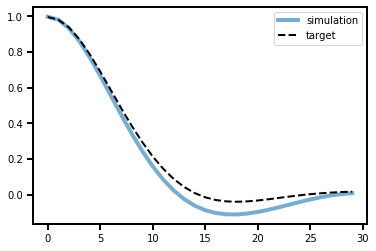

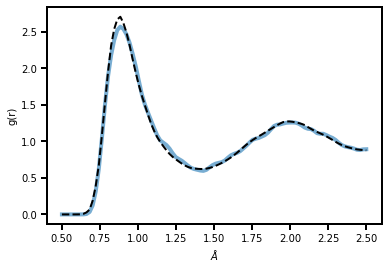

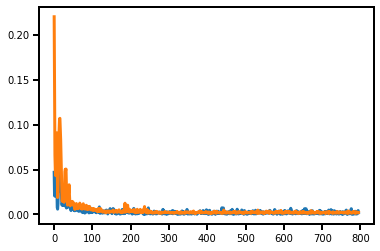

0.0021668036933988333 0.0016597555950284004
0.00046766470768488944 0.002888257848098874
0.001212236937135458 0.0019346184562891722
0.0026503524277359247 0.0028366041369736195
0.004927901551127434 0.0027578226290643215


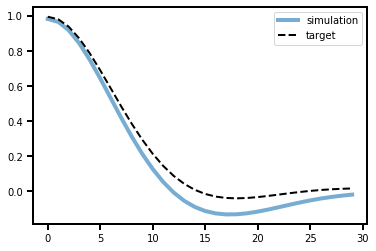

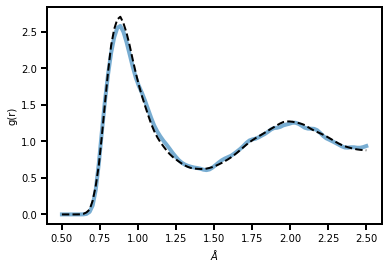

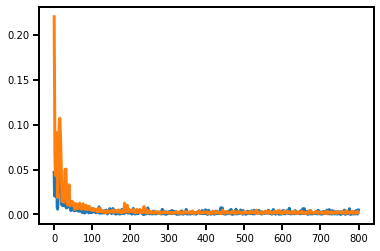

0.0017285773064941168 0.002106731990352273
0.002948887413367629 0.0020763901993632317
0.0014782324433326721 0.002601372078061104
0.0010071141878142953 0.0020887183491140604
0.0014555499656125903 0.002347602741792798


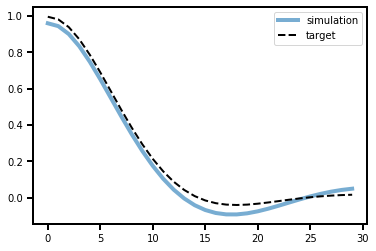

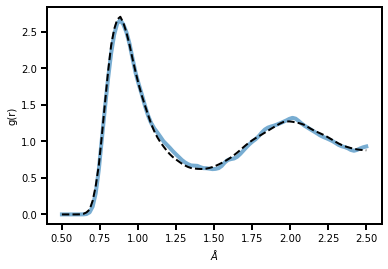

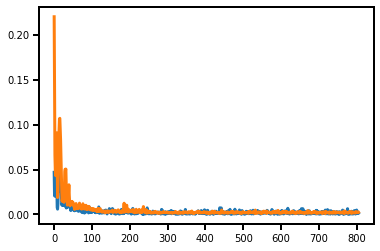

0.0020952990744262934 0.0024980183225125074
0.002060198923572898 0.0019456222653388977
0.0013936005998402834 0.002406833693385124
0.0021146745420992374 0.0020033775363117456
0.00279616704210639 0.0033871273044496775


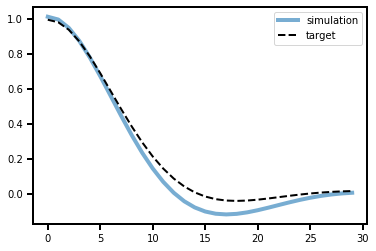

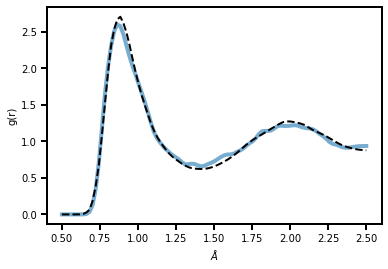

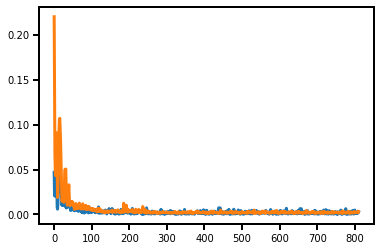

0.003680457826703787 0.002152038039639592
0.00017166144971270114 0.0027199264150112867
0.004258300643414259 0.001474330434575677
0.0019450096879154444 0.00210643676109612
0.0011659687152132392 0.002547778654843569


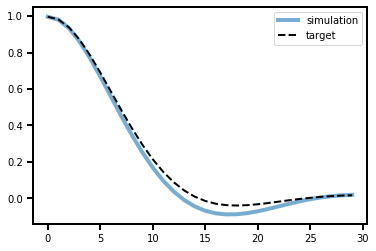

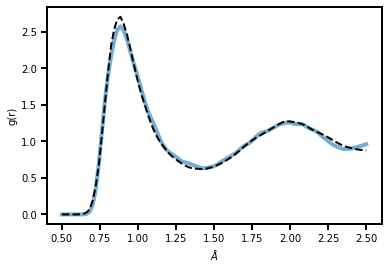

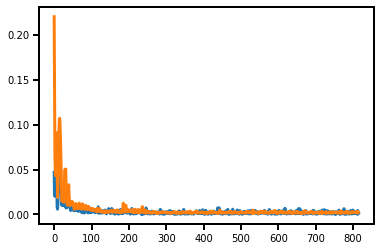

0.004047449678182602 0.0022936828900128603
0.0015264913672581315 0.0036390461027622223
0.0037311045452952385 0.0022080973722040653
0.00295250047929585 0.001947721466422081
0.001030903309583664 0.0026928146835416555


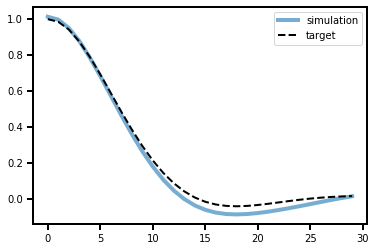

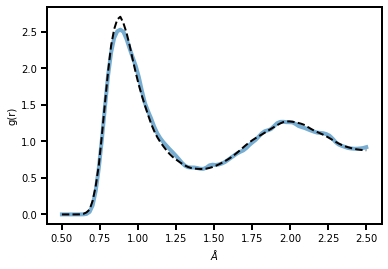

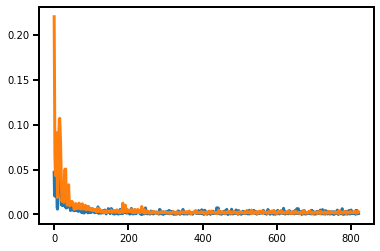

0.0026408755220472813 0.0020590259227901697
0.0044866446405649185 0.001346311648376286
0.0032337757293134928 0.002156923757866025
0.0032277898862957954 0.0026060459204018116
0.0017466348363086581 0.0017480889800935984


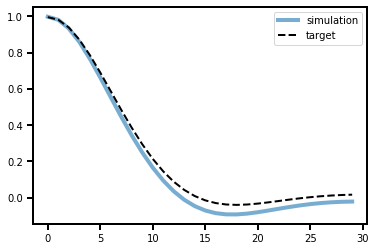

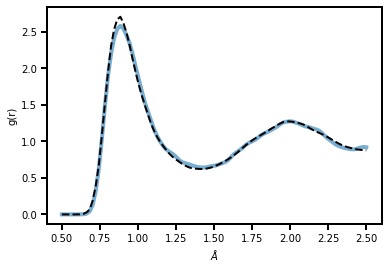

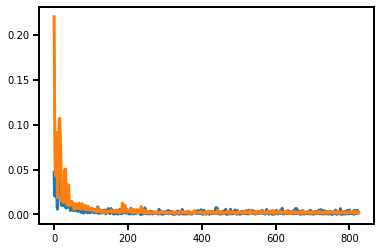

0.002360882703214884 0.0018686035182327032
0.0020943826530128717 0.002590597840026021
0.0007525936234742403 0.002734092064201832
0.001192329335026443 0.001557211042381823
0.003696659579873085 0.0018288013525307178


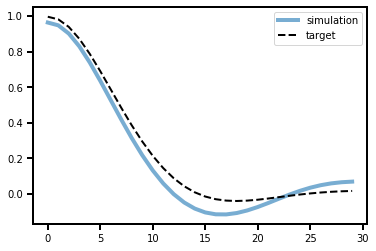

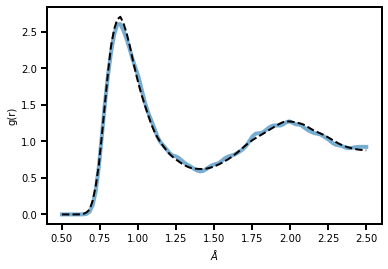

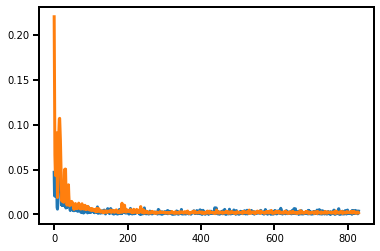

0.001422383706085384 0.0026726769283413887
0.0022040437906980515 0.0024989501107484102
0.0007486108806915581 0.0014123746659606695
0.001342074596323073 0.0018227352993562818
0.0016082057263702154 0.0024735331535339355


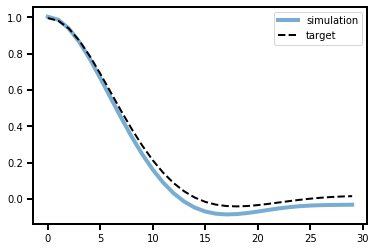

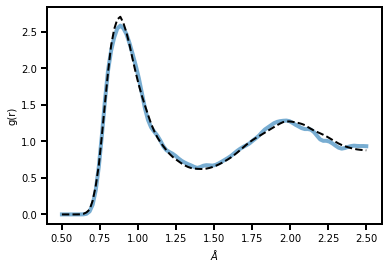

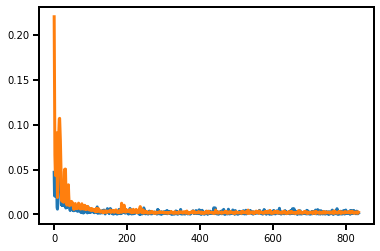

0.004675290081650019 0.0024307339917868376
0.001437957165762782 0.0019566777627915144
0.0010339155560359359 0.002512784907594323
0.002030368195846677 0.0021647887770086527
0.0010486588580533862 0.002199807669967413


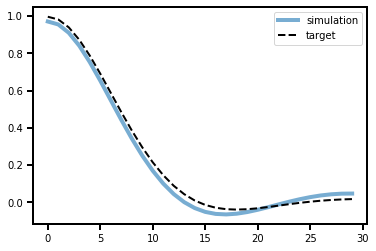

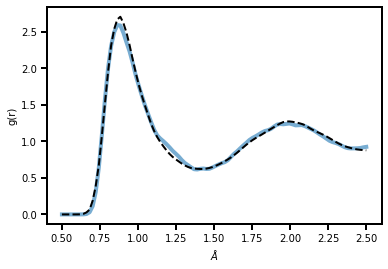

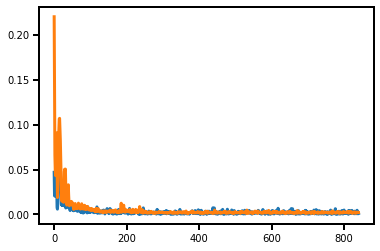

0.0016403893241658807 0.0014441757230088115
0.00037443917244672775 0.001495863078162074
0.0027856992091983557 0.0018082682508975267
0.004065327346324921 0.003133532591164112
0.003312712535262108 0.0023657057899981737


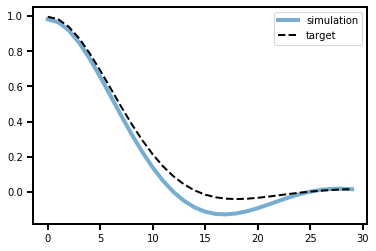

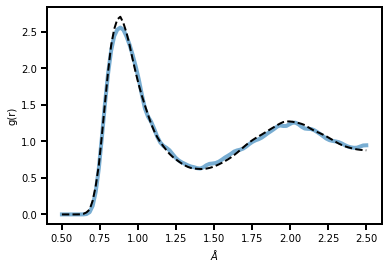

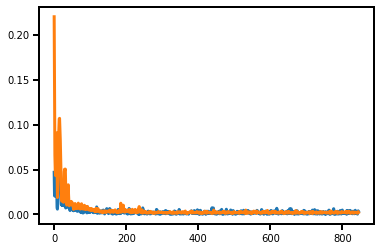

0.003536887699738145 0.0015124542405828834
0.0035859160125255585 0.0029763830825686455
0.0009562359773553908 0.0021683594677597284
0.0019441419281065464 0.0018587650265544653
0.004330887459218502 0.003675329964607954


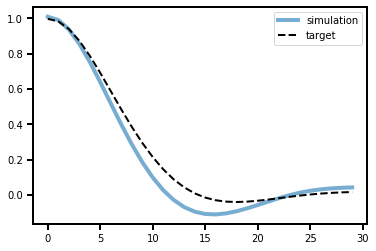

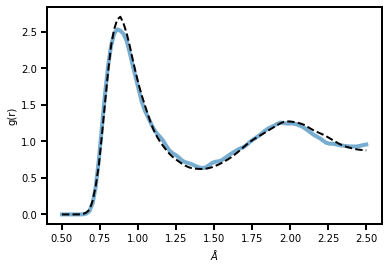

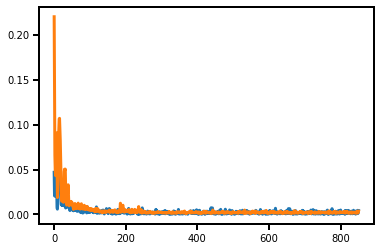

0.004071970470249653 0.0018945469055324793
0.0014221433084458113 0.0014268661616370082
0.003662185976281762 0.0021274778991937637
0.0023503368720412254 0.0018122002948075533
0.001135223195888102 0.0023009655997157097


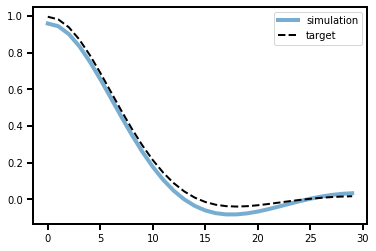

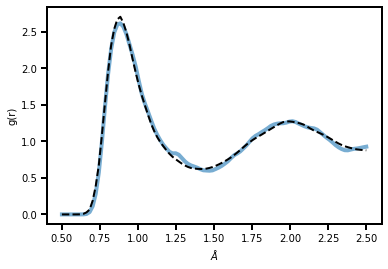

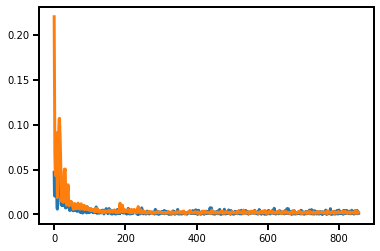

0.0020924792625010014 0.001806570333428681
0.0014474114868789911 0.0017566871829330921
0.002768720267340541 0.002271284582093358
0.0009794716024771333 0.00210762326605618
0.002725486410781741 0.0021466000471264124


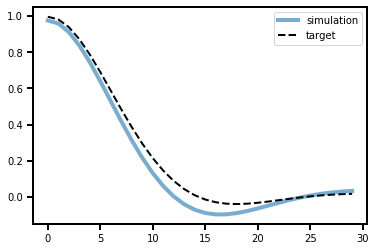

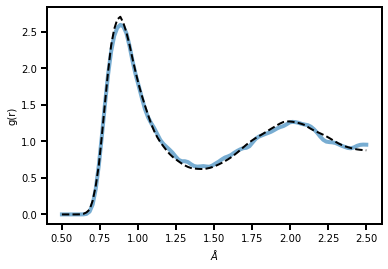

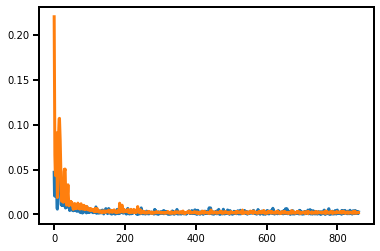

0.002732977271080017 0.0023183519951999187
0.0008056934457272291 0.0025343047454953194
0.001203008578158915 0.0022051234263926744
0.002394570969045162 0.001686258241534233
0.002118221251294017 0.0020111599005758762


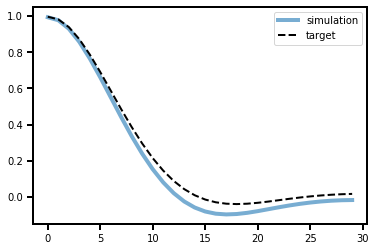

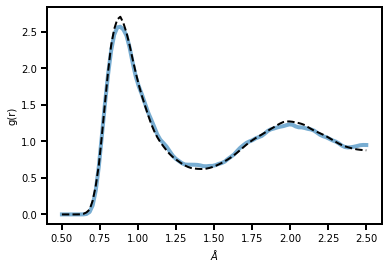

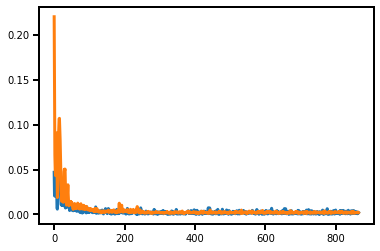

0.004204487893730402 0.002424472477287054
0.0006150848348625004 0.002039771992713213
0.0002889398892875761 0.0018710114527493715
0.0028524911031126976 0.0017315916484221816
0.00015792409249115735 0.0016163450200110674


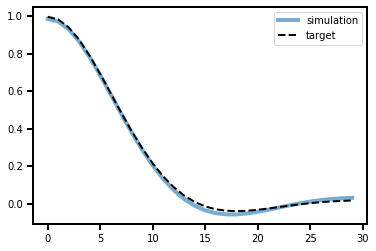

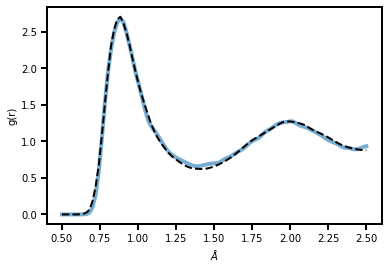

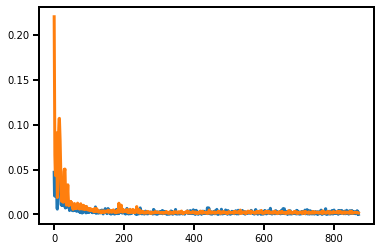

0.00047654853551648557 0.001447021495550871
0.0016689994372427464 0.0019687763415277004


KeyboardInterrupt: 

In [15]:
# %%timeit

loss_log = []

for i in range(2000):

    # Simulate 
    v_t, q_t, pv_t = sim.simulate(steps=50, frequency=50, dt=0.01)

    # compute observable 
    _, _, g_sim = obs(q_t)

    vacf_sim = vacf_obs(v_t)
    vacf_sim = vacf_sim # / vacf_sim[0]

    loss_vacf = (vacf_sim - vacf_target[:30]).pow(2).mean()
    loss_rdf = (g_sim - rdf_target).pow(2).mean() + JS_rdf(g_sim, rdf_target)

    loss = loss_rdf + loss_vacf
    
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    
    print(loss_vacf.item(), loss_rdf.item())
    
    scheduler.step(loss)
    
    loss_log.append([loss_vacf.item(), loss_rdf.item() ])
    
    if i % 5 ==0 :
        plot(vacf_sim, vacf_target[:30], g_sim, rdf_target)
        
        plt.plot(np.array( loss_log)[:, 0])
        plt.plot(np.array( loss_log)[:, 1])
        
        plt.show()
    

In [34]:
# compare the learned pair function 

x = torch.linspace(0.9, 2.5, 50)[:, None].to(device)

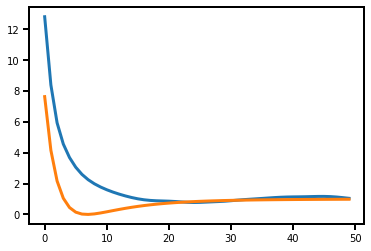

In [35]:
plt.plot( pairNN.model(x).detach().cpu().numpy() + pair.model(x).detach().cpu().numpy())

plt.plot( pair_true(x).detach().cpu().numpy() + 1.0)

In [ ]:
# from utils import display_traj

# display_traj(system, diffeq.traj)

In [ ]:
def get_exp_rdf(data, nbins, r_range, obs):
    # load RDF data 
    f = interpolate.interp1d(data[0], data[1])
    start = r_range[0]
    end = r_range[1]
    xnew = np.linspace(start, end, nbins)
    g_obs = torch.Tensor(f(xnew)).to(obs.device)
    
    return g_obs
    

In [ ]:
get_exp_rdf(rd)

In [ ]:
data